<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [55]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-02-04 12:06:10.075488: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_950964/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum    version  \
_id                                                                            
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d      3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1      1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e      2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a     1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3  23.1.27.1   
...                         ...                               ...        ...   
638085816a07f3e980b2c3a7     db  00fe34ae13d83734166e1af381071dd2      3.0.0   
638085556a07f3e980b2bfcc     db  33197ec224fd15eaa85bbc8dd171b6c8      3.0.0   
62a9bf57326a4191e5f1746e     db  41ebbb7646314b574b2541f54d47a8da      3.0.0   
638f0a82b1363747e929f30b     db  087a1634b74d6e8076abedb4c6f1d50b    22.12.6   
635fa41bbf4cb23cbb3927ef     db  0112d13a24346dfa78688fd10df75288      3.0.0   

                                         export_date     len  \
_id                                                            
6340244c9d08c565cfa12341  2023-01-31 18:37:33.526517  6740.0   
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394  5840.0   
5edbc62eda3678279fbcadf3  2023-02-04 11:26:06.198066  1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-04 11:26:02.945815   460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376  8530.0   
...                                              ...     ...   
638085816a07f3e980b2c3a7  2023-01-31 18:38:02.189240  1880.0   
638085556a07f3e980b2bfcc  2023-01-31 18:38:00.827989  1230.0   
62a9bf57326a4191e5f1746e  2023-01-31 18:37:33.245891  5360.0   
638f0a82b1363747e929f30b  2023-01-31 18:38:07.428181   640.0   
635fa41bbf4cb23cbb3927ef  2023-01-31 18:38:00.464502   890.0   

                                             analyze_date         value  \
_id                                                                       
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
63ce49f8e83d1ee490f3f21c 2023-01-28 09:34:50.691000+00:00  3.000000e+09   
...                                                   ...           ...   
638085816a07f3e980b2c3a7 2022-11-25 15:18:41.579000+00:00           NaN   
638085556a07f3e980b2bfcc 2022-11-25 12:50:24.036000+00:00           NaN   
62a9bf57326a4191e5f1746e 2022-06-15 14:19:17.704000+00:00           NaN   
638f0a82b1363747e929f30b 2022-12-06 12:29:18.793000+00:00           NaN   
635fa41bbf4cb23cbb3927ef 2022-10-31 13:33:24.683000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...   
63ce49f8e83d1ee490f3f21c    21.821878       337.0      RUB  ...   
...                               ...         ...      ...  ...   
638085816a07f3e980b2c3a7          NaN         NaN      NaN  ...   
638085556a07f3e980b2bfcc          NaN         NaN      NaN  ...   
62a9bf57326a4191e5f1746e          NaN         NaN      NaN  ...   
638f0a82b1363747e929f30b          NaN         NaN      NaN  ...   
635fa41bbf4cb23cbb3927ef          NaN         NaN      NaN  ...   

                                     user_correction_date valid documentType  \
_id                                                                            
6340244c9d08c565cfa12341 2022-10-07 13:43:21.470000+00:00  True    AGREEMENT   
5ec2b8da665f7603e03b1255 2023-01-27 10:27:22.086000+00:00  True

In [17]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]
len(user_dataset)


1220

In [18]:
print(len(stats))

2989


In [19]:
user_dataset[user_dataset.subj_len>=150]

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
639316f61002115a6029f3c8     db  670b730e664306d9e1e7f19a358cc0ab  22.12.7   
63908ca4a1bded13e629f2e4     db  665a638dc4f2c42ce670679ca76cff77  22.12.6   
62838b2e4d1bfe5e5b297ddb     db  c81664bbc202b2a143fe57dfcb950348    3.0.0   
5fb399dd39d5e82e90818477     db  44d1c22fb92ce75663dc046c184df359    2.0.5   
62d149464ae369b4976e31f3     db  31b2973970123953ebc9074a4dfaa421    3.0.0   
6380859e6a07f3e980b2c5c4     db  5d8d2a674adffa2c30fa1254e1047e40    3.0.0   
638085646a07f3e980b2c0e5     db  43519987735b5d2180168facc4404545    3.0.0   
6380857e6a07f3e980b2c343     db  24195a650ec51184b0b507d73fd67b7a    3.0.0   
638085686a07f3e980b2c124     db  0330bc8b29d42453fb0350e80da94743    3.0.0   
638085976a07f3e980b2c561     db  ec297f3094591fbad5418b2167357d4d    3.0.0   
638085ac6a07f3e980b2c733     db  7440524bbf921c898bfc35d1885bda2f    3.0.0   
638085a36a07f3e980b2c623     db  85bd0228e9e167ca8a7eb78c0ba8c305    3.0.0   
5fb3d7a178df3635f5441d6a     db  5e410fc2e9e1068575cf860ad7a4a632    2.0.5   
5fe4821fb770574a00555741     db  8dceb00aaefe9c38b75de9d170b212f5   2.3.13   
62c54895e599c73b751b7974     db  9756e819859af5192b5e44806f173d8c    3.0.0   
638085976a07f3e980b2c575     db  d7756a8860dee9f6d2c4e825566aaa6c    3.0.0   
638085b16a07f3e980b2c7e1     db  9ad16aad3ee3f858d3cd3462a8138488  22.12.7   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-02-04 11:26:24.239638   1990.0   
639316f61002115a6029f3c8  2023-01-31 21:26:42.950175   1260.0   
63908ca4a1bded13e629f2e4  2023-02-04 11:26:24.220406   2020.0   
62838b2e4d1bfe5e5b297ddb  2023-01-31 18:32:43.216593  25010.0   
5fb399dd39d5e82e90818477  2023-02-04 11:26:22.006244   5210.0   
62d149464ae369b4976e31f3  2023-02-04 11:26:23.137047   2050.0   
6380859e6a07f3e980b2c5c4  2023-01-31 18:32:52.073085   4180.0   
638085646a07f3e980b2c0e5  2023-01-31 18:32:45.290596  28200.0   
6380857e6a07f3e980b2c343  2023-01-31 18:32:46.337373   5020.0   
638085686a07f3e980b2c124  2023-01-31 18:32:45.969271   2970.0   
638085976a07f3e980b2c561  2023-01-31 18:32:48.530026   4480.0   
638085ac6a07f3e980b2c733  2023-01-31 18:32:48.969831   1980.0   
638085a36a07f3e980b2c623  2023-01-31 18:32:48.780383   4090.0   
5fb3d7a178df3635f5441d6a  2023-01-31 18:36:01.135666   2030.0   
5fe4821fb770574a00555741  2023-01-31 18:36:06.228625   2030.0   
62c54895e599c73b751b7974  2023-01-31 18:32:26.584587   1950.0   
638085976a07f3e980b2c575  2023-01-31 18:32:48.568796   6460.0   
638085b16a07f3e980b2c7e1  2023-01-31 18:36:14.692907   3660.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
639316f61002115a6029f3c8 2022-12-09 14:08:03.016000+00:00  3.433397e+09   
63908ca4a1bded13e629f2e4 2022-12-07 15:55:04.590000+00:00  1.500000e+10   
62838b2e4d1bfe5e5b297ddb 2022-05-17 14:47:43.209000+00:00  3.050000e+09   
5fb399dd39d5e82e90818477 2020-11-17 09:58:23.635000+00:00  4.338600e+05   
62d149464ae369b4976e31f3 2022-07-15 14:09:08.607000+00:00  1.000000e+04   
6380859e6a07f3e980b2c5c4 2022-11-25 20:00:26.236000+00:00  1.705600e+06   
638085646a07f3e980b2c0e5 2022-11-25 12:30:29.763000+00:00  3.147910e+05   
6380857e6a07f3e980b2c343 2022-11-25 12:31:32.455000+00:00  2.923300e+07   
638085686a07f3e980b2c124 2022-11-25 12:30:38.681000+00:00  5.897600e+05   
638085976a07f3e980b2c561 2022-11-25 12:33:11.663000+00:00  4.949780e+05   
638085ac6a07f3e980b2c733 2022-11-25 12:34:24.346000+00:00  1.230600e+05   
638085a36a07f3e980b2c623 2022-11-25 12:34:06.806000+00:00  5.085000e+04   
5fb3d7a178df3635f5441d6a 2020-11-17 15

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [20]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2715


CONTRACT                   0.640518
SUPPLEMENTARY_AGREEMENT    1.087063
AGREEMENT                  1.272419
Name: documentType, dtype: float64

In [21]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [22]:
%time

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.01 µs


1.0
1.0
0.020447337717887263
0.15016182082729343
6.102677523519979
6.662783265186846


Service                              0.122880
Deal                                 0.239533
Renting                              0.399048
GeneralContract                      0.421159
Other                                0.444968
Loans                                0.481843
AgencyContract                       0.587351
DealIntellectualProperty             0.667721
Charity                              0.776079
Insurance                            0.865445
RealEstate                           1.136240
RealEstateTransactions               2.135677
BankGuarantees                       2.642573
PledgeEncumbrance                    2.878307
ParticipationInOtherOrganizations    3.165507
SecuritiesTransactions               4.578784
Name: subject, dtype: float64

In [23]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [24]:
%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 5.48 µs


2715


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [25]:

len(stats_valid)

2715

In [26]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0
1.0
1.0
0.15016182082729343


sample_weight
MIN	 0.020447337717887263
MEAN	 1.0


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


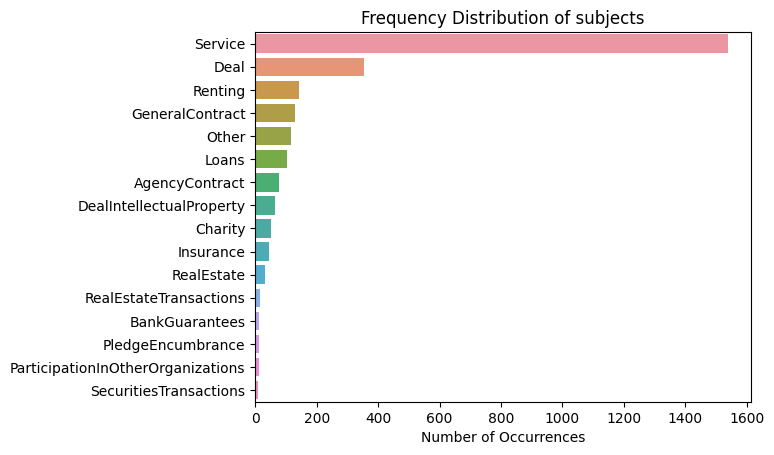


min 8
max 1538
total 2715


In [27]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [28]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Loans', 'Service', 'AgencyContract', 'Charity', 'BankGuarantees', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.497158
Deal                                 0.621043
Renting                              0.736221
GeneralContract                      0.749576
Other                                0.763442
Loans                                0.783974
AgencyContract                       0.837464
DealIntellectualProperty             0.874041
Charity                              0.918972
Insurance                            0.952971
RealEstate                           1.043494
RealEstateTransactions               1.287791
BankGuarantees                       1.382534
PledgeEncumbrance                    1.422478
ParticipationInOtherOrganizations    1.468299
SecuritiesTransactions               1.660543
Name: subject, dtype: float64

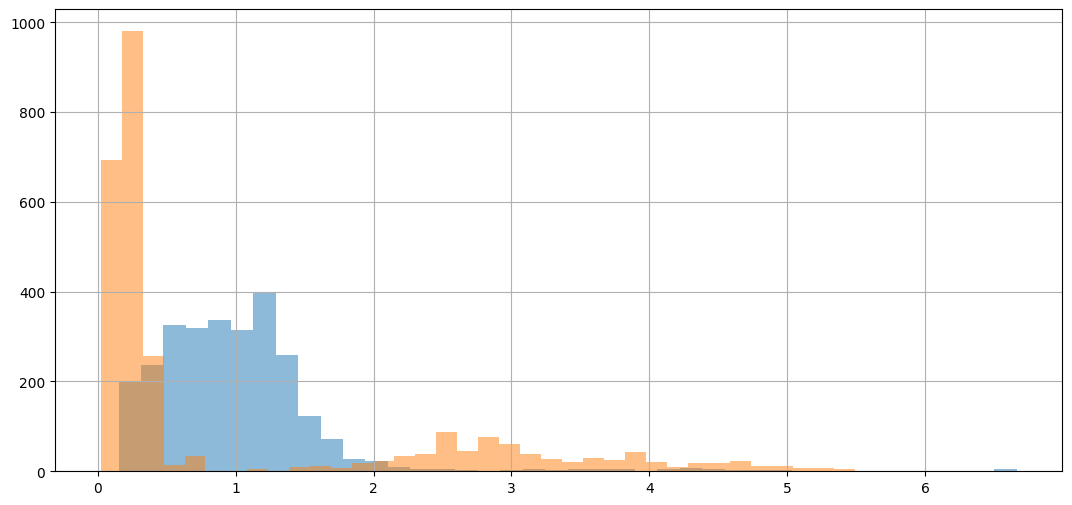

In [29]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

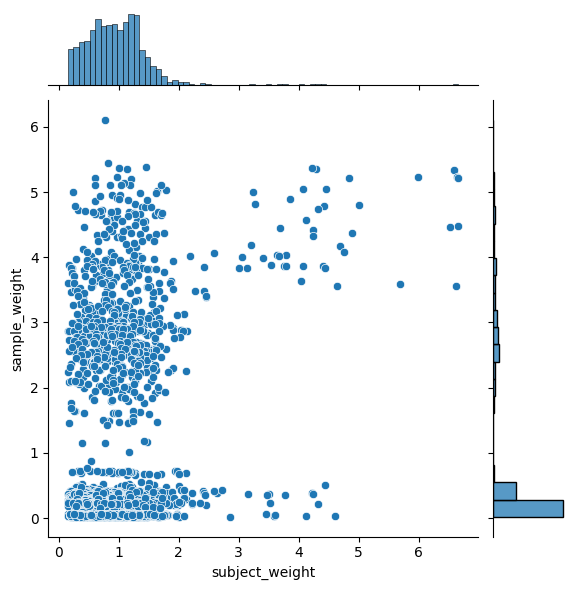

In [30]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


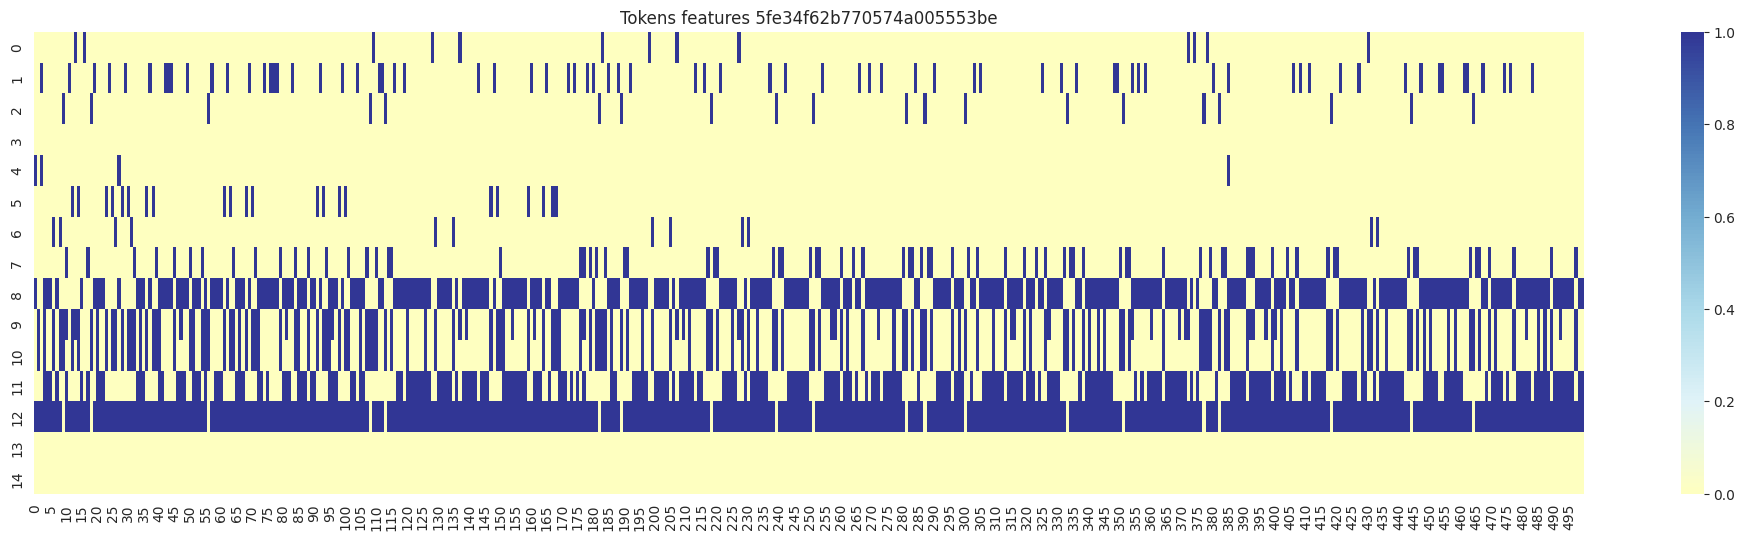

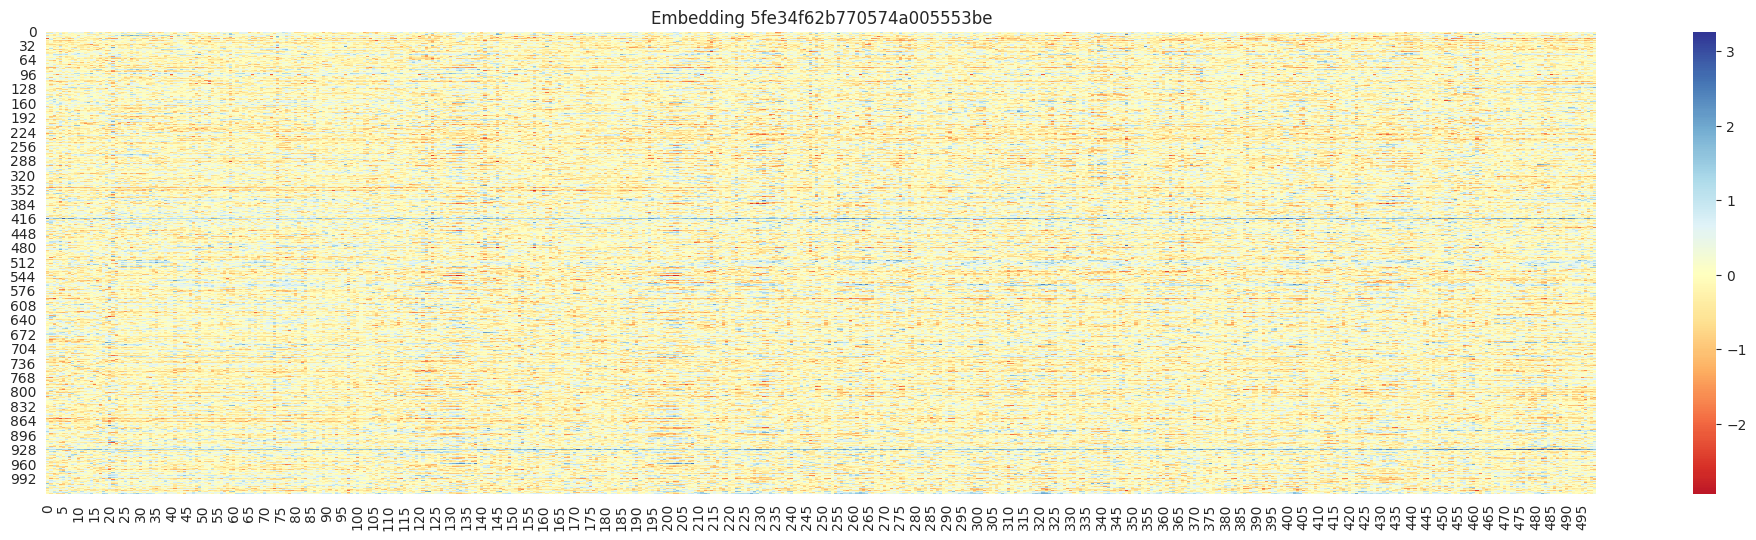

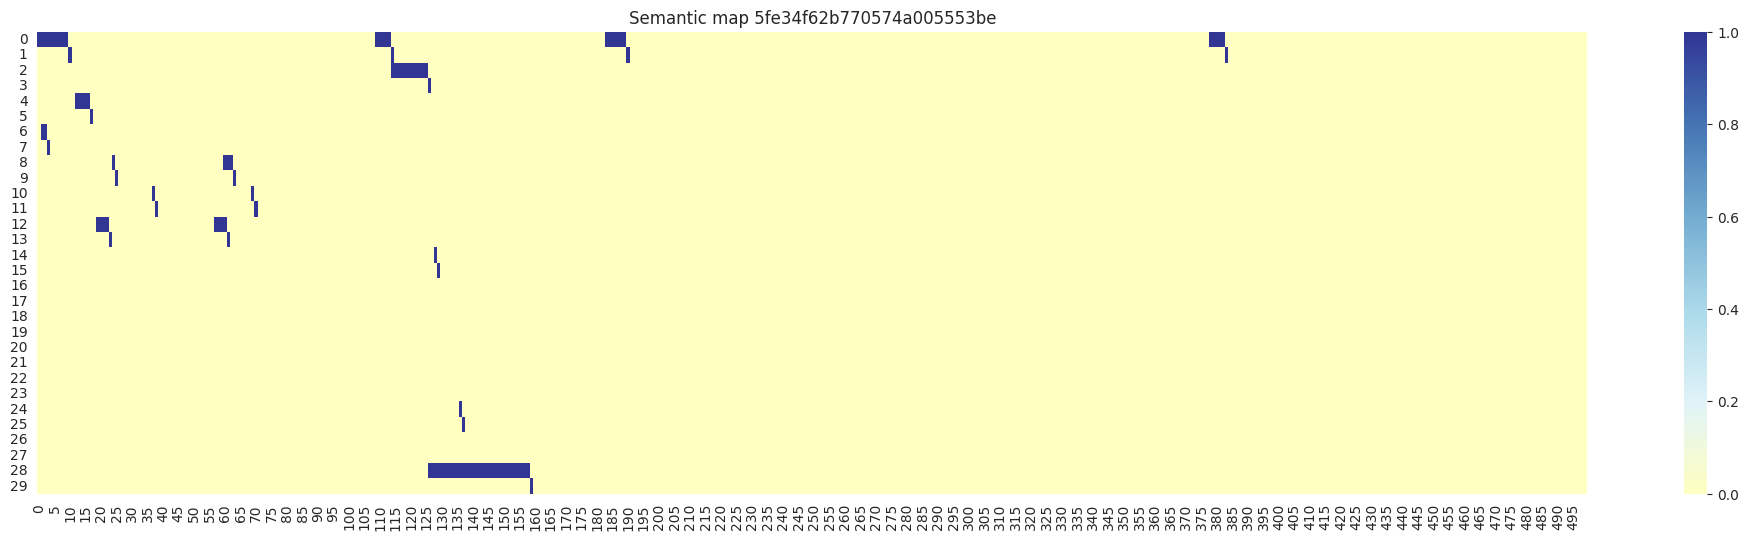

In [31]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 569, 30)


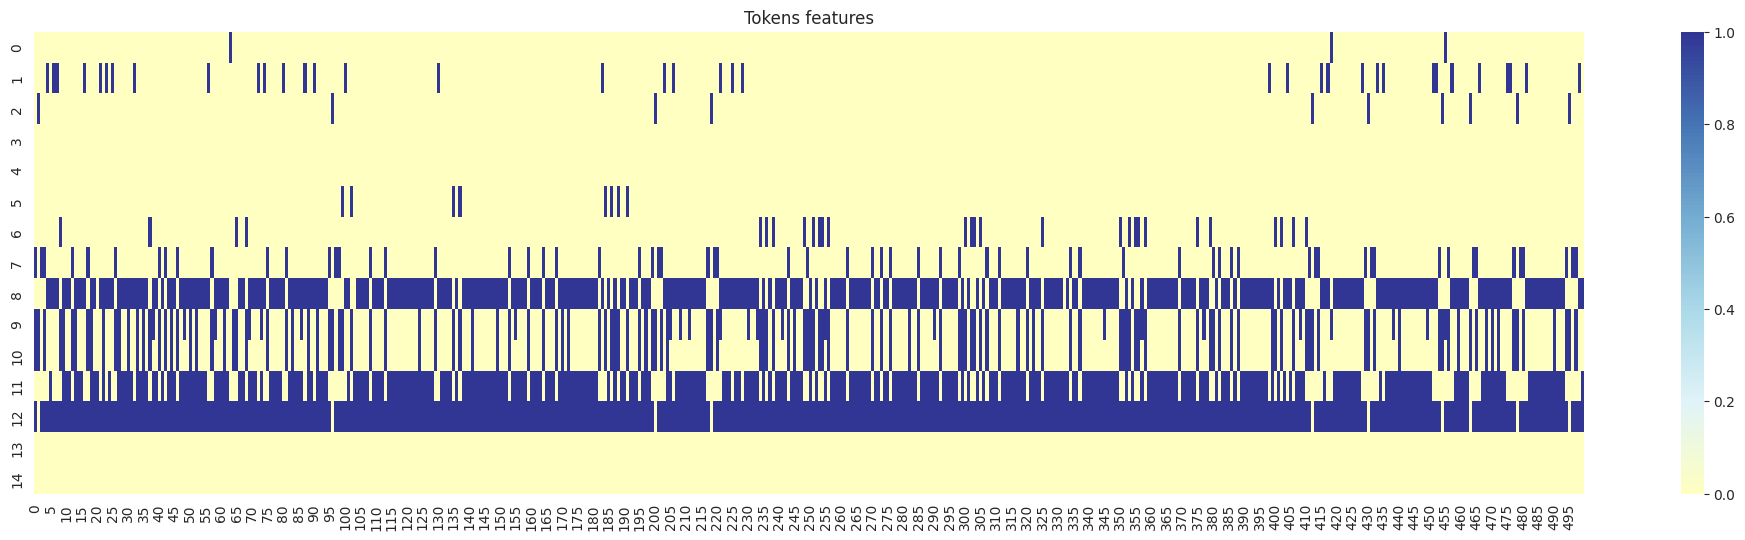

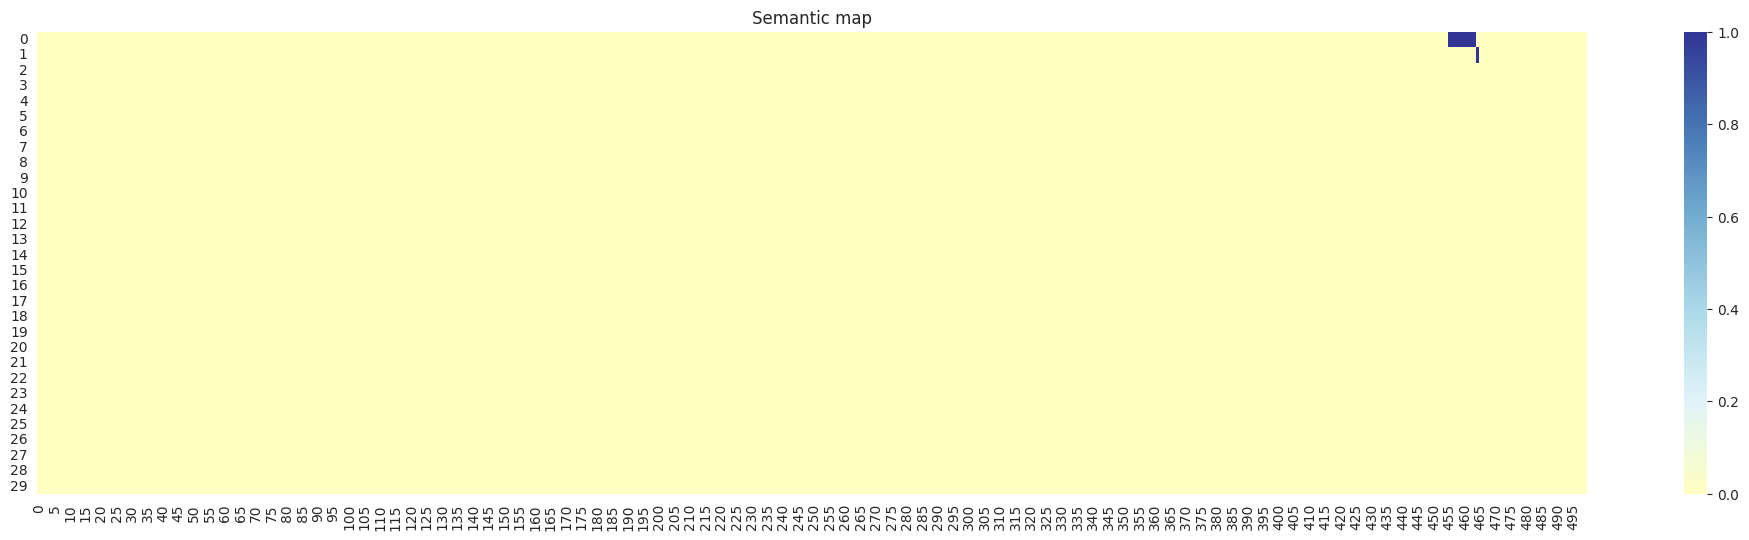

In [32]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [33]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

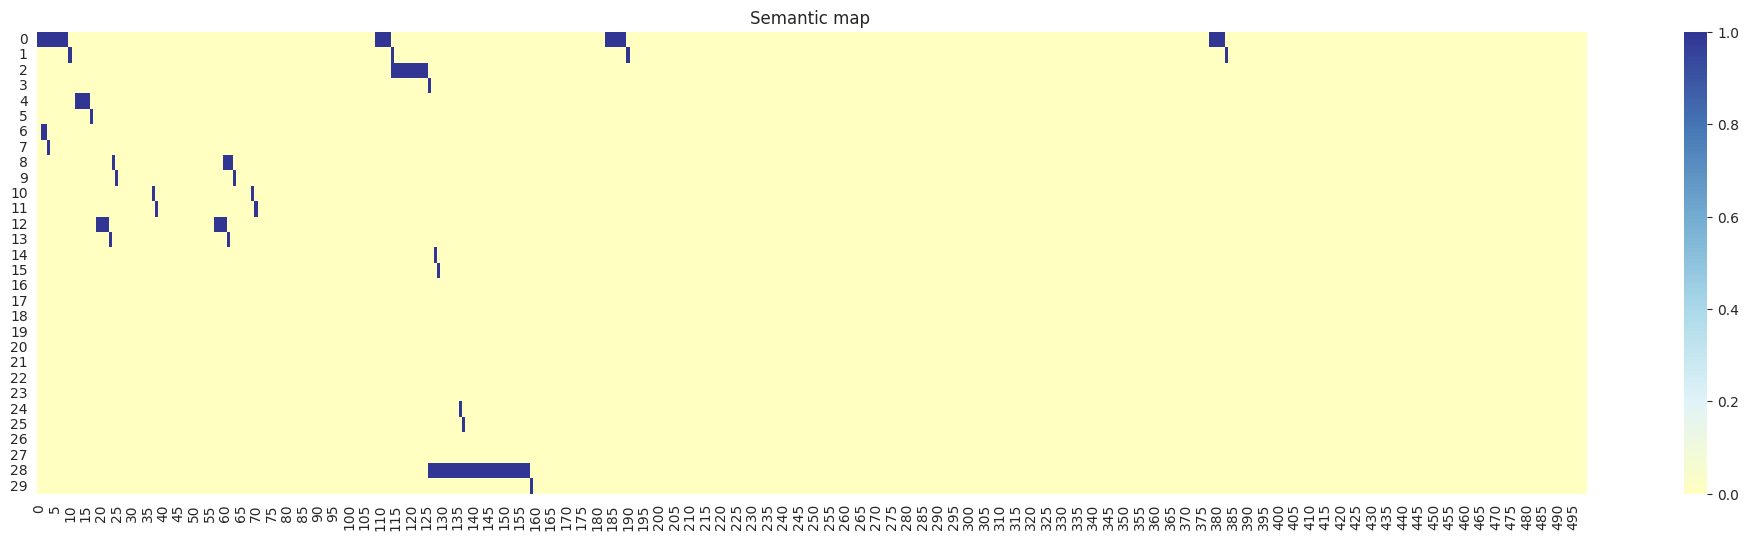

In [34]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 5fe4821ab770574a00555637
test_indices[0]: 5edbc662da3678279fbcaeed


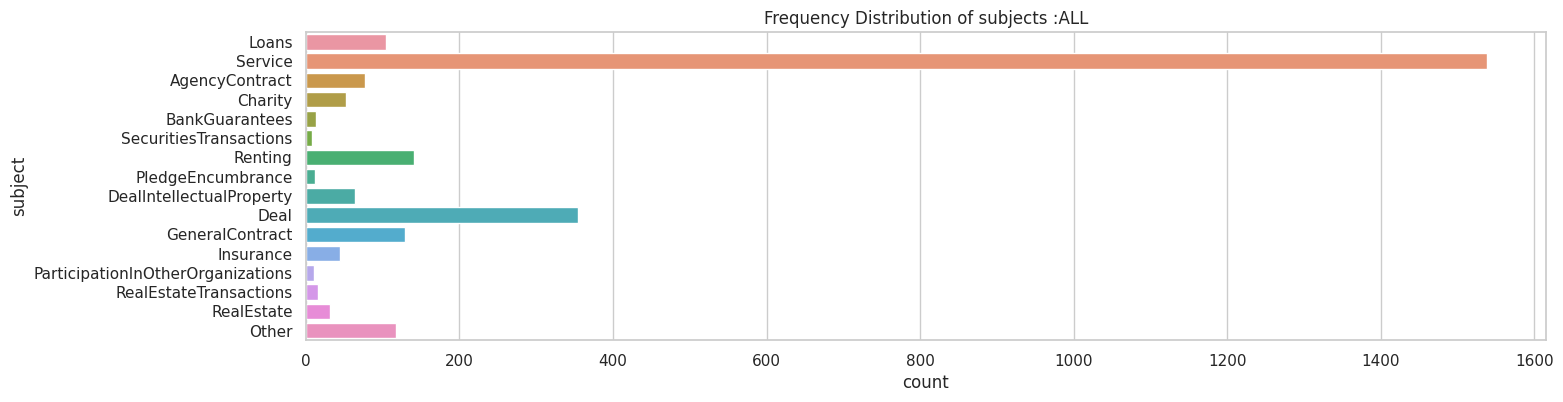

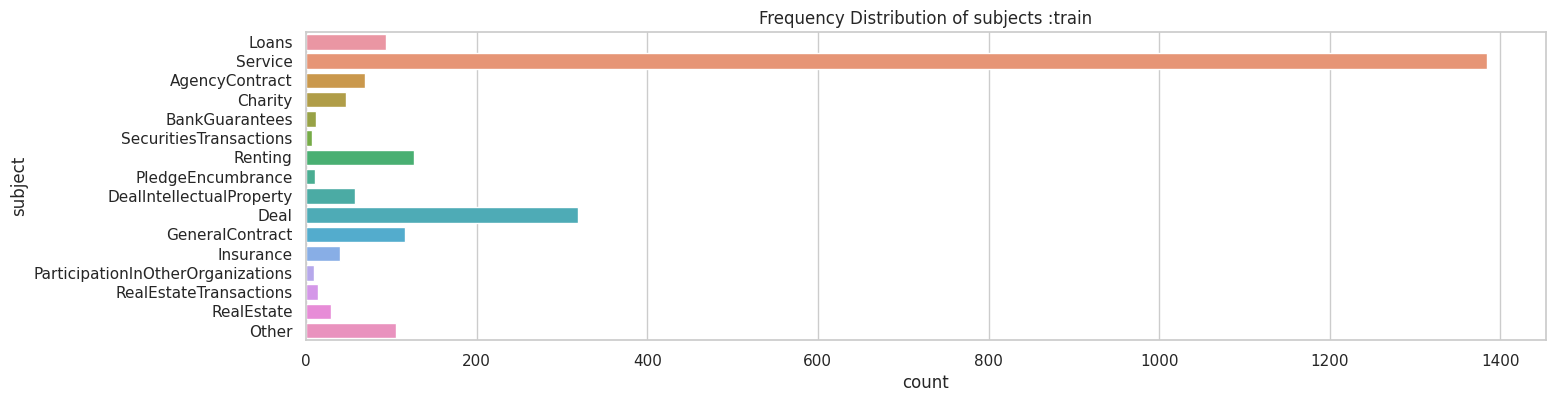

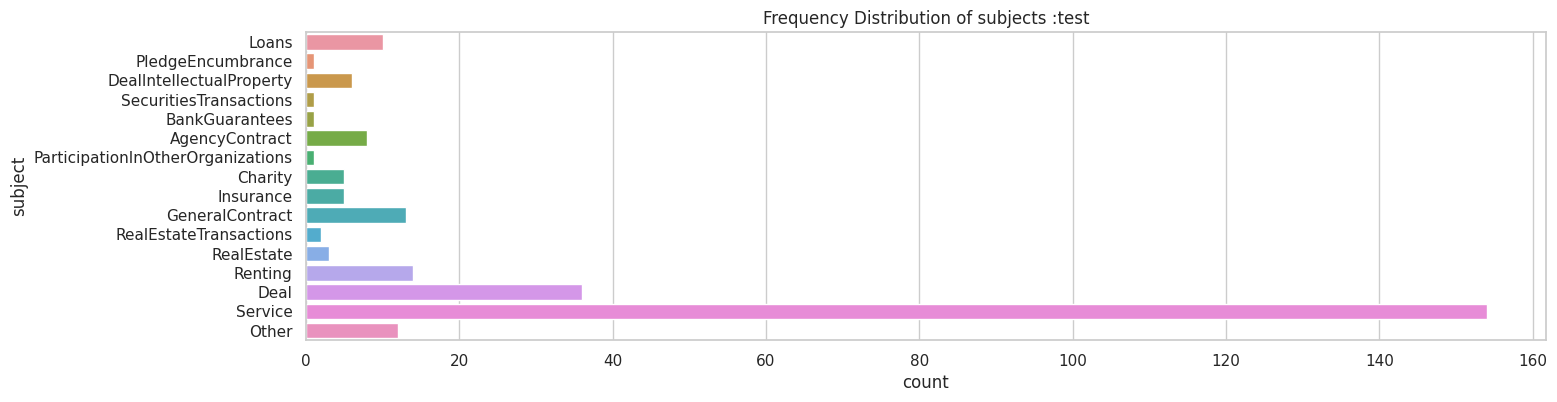

In [35]:
EPOCHS = 50
BATCH_SIZE = 96
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [36]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	96
train_samples:	9772
test_samples:	272
steps_per_epoch:	101
validation_steps:	50


# Models 🦖

In [37]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [38]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [39]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [40]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [41]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [42]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [43]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
# umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-02-04 12:07:30.192194: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-04 12:07:30.692704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 12:07:30.693361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-04 12:07:30.693377: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-04 12:07:30.693411: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-04 12:07:30.693427: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [44]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [45]:
23

23

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [46]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN and False:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 30
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

## 🥰 Att model

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

from analyser.headers_detector import TOKEN_FEATURES
from tf_support.super_contract_model import EMB, CLASSES, DEFAULT_TRAIN_CTX, FEATURES
from functools import lru_cache
from pathlib import Path

import numpy as np
from pandas import DataFrame
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, LSTM, Bidirectional, Dense, MaxPooling1D, ReLU
from tensorflow.keras.layers import concatenate

from analyser.headers_detector import TOKEN_FEATURES
from analyser.hyperparams import work_dir

from analyser.structures import ContractSubject
from tf_support.addons import sigmoid_focal_crossentropy
from tf_support.tools import KerasTrainingContext


@dataclass
class Config:
  # MAX_LEN = 256
  # BATCH_SIZE = 32
  LR = 0.001

  EMBED_DIM = EMB
  NUM_HEAD = 4  # used in bert model
  FF_DIM = 128  # used in bert model
  NUM_LAYERS = 1


config = Config()


def bert_module(query, key, value, i, height):
  # Multi headed self-attention
  attention_output = layers.MultiHeadAttention(
    num_heads=config.NUM_HEAD,
    key_dim=config.EMBED_DIM // config.NUM_HEAD,
    name="encoder_{}/multiheadattention".format(i),
  )(query, key, value)
  attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
    attention_output
  )
  attention_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/att_layernormalization"
  )(query + attention_output)

  # Feed-forward layer
  ffn = keras.Sequential(
    [
      layers.Dense(config.FF_DIM, activation="relu"),
      layers.Dense(height),
    ],
    name=f"encoder_{i}/ffn",
  )
  ffn_output = ffn(attention_output)
  ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
    ffn_output
  )
  sequence_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
  )(attention_output + ffn_output)
  return sequence_output


metrics = ['mse', 'binary_crossentropy']

losses = {
  "O1_tagging": "binary_crossentropy",
  "O2_subject": "binary_crossentropy",
}


def make_att_model(name='make_att_model', ctx: KerasTrainingContext = DEFAULT_TRAIN_CTX, trained=False):
  

  input_text_emb = layers.Input(shape=[None, config.EMBED_DIM], dtype='float32', name="input_text_emb")
  _out = layers.BatchNormalization(name="bn1")(input_text_emb)
  _out = layers.Dropout(0.2, name="drops")(_out)  # small_drops_of_poison

  token_features = layers.Input(shape=[None, TOKEN_FEATURES], dtype='float32', name="token_features")
  token_features_n = layers.BatchNormalization(name="bn2")(token_features)

  _out = layers.concatenate([input_text_emb, token_features_n], axis=-1)

  for i in range(config.NUM_LAYERS):
    _out = bert_module(_out, _out, _out, i, height=config.EMBED_DIM + TOKEN_FEATURES)

  _out = layers.BatchNormalization(name="bn1")(_out)
  _out = LSTM(FEATURES, return_sequences=True, activation='tanh', name='O1_tagging_tanh')(_out)
  _out1 = ReLU(name='O1_tagging')(_out)

  #   _out = Conv1D(filters=FEATURES * 4, kernel_size=(2), padding='same', activation='relu' , name='embedding_reduced')(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False, name='narcissisism'), name='embedding_reduced')(_out1)
  _out = Dropout(0.15)(_out)

  _out2 = Dense(CLASSES, activation='softmax', name='O2_subject')(_out)

  base_model_inputs = [input_text_emb, token_features]
  model = Model(inputs=base_model_inputs, outputs=[_out1, _out2], name=name)
  model.compile(loss=losses, optimizer='Adam', metrics=metrics)
  return model


 

    
weights = get_weights_filename(model_factory_fn)
# model_name = make_att_model.__name__
umodel = make_att_model()

# umodel.load_weights(weights, by_name=True, skip_mismatch=True)
# ctx.init_model(make_att_model, trained=True, trainable=True, weights=weights)



True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [48]:

if TRAIN:
#   ctx.unfreezeModel(umodel)
  umodel.summary()
  
  ctx.EPOCHS = 50
  ctx.EVALUATE_ONLY = False
#   ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)

Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           input_text_emb[0][0]             
                                                                 bn2[0][0]           

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2023-02-04 12:07:34.664371: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 484835328 exceeds 10% of free system memory.
2023-02-04 12:07:34.847611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-04 12:07:34.865935: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/50


2023-02-04 12:07:37.542547: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 484835328 exceeds 10% of free system memory.
2023-02-04 12:07:37.765338: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2023-02-04 12:07:38.557805: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-04 12:07:38.557853: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-04 12:07:38.681672: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-02-04 12:07:38.833337: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


  1/101 [..............................] - ETA: 8:34 - loss: 0.6555 - O1_tagging_loss: 0.2159 - O2_subject_loss: 0.4395 - O1_tagging_mse: 0.0527 - O1_tagging_binary_crossentropy: 0.2035 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6937

2023-02-04 12:07:39.801476: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 540672000 exceeds 10% of free system memory.


  2/101 [..............................] - ETA: 47s - loss: 0.6298 - O1_tagging_loss: 0.1796 - O2_subject_loss: 0.4501 - O1_tagging_mse: 0.0465 - O1_tagging_binary_crossentropy: 0.1838 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6893 

2023-02-04 12:07:41.343474: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 376307712 exceeds 10% of free system memory.


  3/101 [..............................] - ETA: 1:26 - loss: 0.6355 - O1_tagging_loss: 0.1678 - O2_subject_loss: 0.4677 - O1_tagging_mse: 0.0434 - O1_tagging_binary_crossentropy: 0.1742 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6861

  4/101 [>.............................] - ETA: 1:26 - loss: 0.6624 - O1_tagging_loss: 0.1713 - O2_subject_loss: 0.4911 - O1_tagging_mse: 0.0427 - O1_tagging_binary_crossentropy: 0.1737 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6837

2023-02-04 12:07:42.530706: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 136052736 exceeds 10% of free system memory.


  5/101 [>.............................] - ETA: 1:37 - loss: 0.6334 - O1_tagging_loss: 0.1587 - O2_subject_loss: 0.4747 - O1_tagging_mse: 0.0404 - O1_tagging_binary_crossentropy: 0.1652 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6812

  6/101 [>.............................] - ETA: 1:38 - loss: 0.6086 - O1_tagging_loss: 0.1473 - O2_subject_loss: 0.4613 - O1_tagging_mse: 0.0389 - O1_tagging_binary_crossentropy: 0.1603 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6794

  7/101 [=>............................] - ETA: 1:38 - loss: 0.5967 - O1_tagging_loss: 0.1420 - O2_subject_loss: 0.4547 - O1_tagging_mse: 0.0372 - O1_tagging_binary_crossentropy: 0.1540 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6772

  8/101 [=>............................] - ETA: 1:50 - loss: 0.5716 - O1_tagging_loss: 0.1339 - O2_subject_loss: 0.4377 - O1_tagging_mse: 0.0343 - O1_tagging_binary_crossentropy: 0.1436 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6754

  9/101 [=>............................] - ETA: 1:39 - loss: 0.5578 - O1_tagging_loss: 0.1273 - O2_subject_loss: 0.4305 - O1_tagging_mse: 0.0337 - O1_tagging_binary_crossentropy: 0.1419 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6735

 10/101 [=>............................] - ETA: 1:37 - loss: 0.5560 - O1_tagging_loss: 0.1250 - O2_subject_loss: 0.4310 - O1_tagging_mse: 0.0332 - O1_tagging_binary_crossentropy: 0.1403 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6716

 11/101 [==>...........................] - ETA: 1:32 - loss: 0.5503 - O1_tagging_loss: 0.1206 - O2_subject_loss: 0.4297 - O1_tagging_mse: 0.0325 - O1_tagging_binary_crossentropy: 0.1378 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6700

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.5423 - O1_tagging_loss: 0.1160 - O2_subject_loss: 0.4263 - O1_tagging_mse: 0.0298 - O1_tagging_binary_crossentropy: 0.1275 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6679

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.5371 - O1_tagging_loss: 0.1119 - O2_subject_loss: 0.4251 - O1_tagging_mse: 0.0282 - O1_tagging_binary_crossentropy: 0.1213 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6658

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.5337 - O1_tagging_loss: 0.1090 - O2_subject_loss: 0.4247 - O1_tagging_mse: 0.0269 - O1_tagging_binary_crossentropy: 0.1168 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6632

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.5308 - O1_tagging_loss: 0.1049 - O2_subject_loss: 0.4259 - O1_tagging_mse: 0.0263 - O1_tagging_binary_crossentropy: 0.1143 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.6610

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.5273 - O1_tagging_loss: 0.1010 - O2_subject_loss: 0.4263 - O1_tagging_mse: 0.0258 - O1_tagging_binary_crossentropy: 0.1123 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6589

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.5192 - O1_tagging_loss: 0.0975 - O2_subject_loss: 0.4218 - O1_tagging_mse: 0.0247 - O1_tagging_binary_crossentropy: 0.1085 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6567

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.5119 - O1_tagging_loss: 0.0946 - O2_subject_loss: 0.4173 - O1_tagging_mse: 0.0240 - O1_tagging_binary_crossentropy: 0.1060 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6548

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.5106 - O1_tagging_loss: 0.0924 - O2_subject_loss: 0.4182 - O1_tagging_mse: 0.0231 - O1_tagging_binary_crossentropy: 0.1026 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6524

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.5049 - O1_tagging_loss: 0.0899 - O2_subject_loss: 0.4150 - O1_tagging_mse: 0.0227 - O1_tagging_binary_crossentropy: 0.1010 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6505

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.5005 - O1_tagging_loss: 0.0874 - O2_subject_loss: 0.4131 - O1_tagging_mse: 0.0221 - O1_tagging_binary_crossentropy: 0.0987 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6479

 22/101 [=====>........................] - ETA: 1:37 - loss: 0.4970 - O1_tagging_loss: 0.0854 - O2_subject_loss: 0.4116 - O1_tagging_mse: 0.0213 - O1_tagging_binary_crossentropy: 0.0949 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6452

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.4894 - O1_tagging_loss: 0.0832 - O2_subject_loss: 0.4062 - O1_tagging_mse: 0.0208 - O1_tagging_binary_crossentropy: 0.0929 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6429

 24/101 [======>.......................] - ETA: 1:35 - loss: 0.4842 - O1_tagging_loss: 0.0814 - O2_subject_loss: 0.4028 - O1_tagging_mse: 0.0201 - O1_tagging_binary_crossentropy: 0.0899 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6404

 25/101 [======>.......................] - ETA: 1:33 - loss: 0.4823 - O1_tagging_loss: 0.0800 - O2_subject_loss: 0.4023 - O1_tagging_mse: 0.0195 - O1_tagging_binary_crossentropy: 0.0876 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6381

 26/101 [======>.......................] - ETA: 1:32 - loss: 0.4788 - O1_tagging_loss: 0.0785 - O2_subject_loss: 0.4003 - O1_tagging_mse: 0.0192 - O1_tagging_binary_crossentropy: 0.0860 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6354

 27/101 [=======>......................] - ETA: 1:31 - loss: 0.4769 - O1_tagging_loss: 0.0768 - O2_subject_loss: 0.4002 - O1_tagging_mse: 0.0186 - O1_tagging_binary_crossentropy: 0.0835 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6326

 28/101 [=======>......................] - ETA: 1:33 - loss: 0.4715 - O1_tagging_loss: 0.0754 - O2_subject_loss: 0.3961 - O1_tagging_mse: 0.0180 - O1_tagging_binary_crossentropy: 0.0810 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6300

 29/101 [=======>......................] - ETA: 1:31 - loss: 0.4671 - O1_tagging_loss: 0.0739 - O2_subject_loss: 0.3931 - O1_tagging_mse: 0.0176 - O1_tagging_binary_crossentropy: 0.0791 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6269

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.4632 - O1_tagging_loss: 0.0735 - O2_subject_loss: 0.3897 - O1_tagging_mse: 0.0174 - O1_tagging_binary_crossentropy: 0.0783 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6240

 31/101 [========>.....................] - ETA: 1:26 - loss: 0.4602 - O1_tagging_loss: 0.0727 - O2_subject_loss: 0.3875 - O1_tagging_mse: 0.0173 - O1_tagging_binary_crossentropy: 0.0778 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6210

 32/101 [========>.....................] - ETA: 1:25 - loss: 0.4553 - O1_tagging_loss: 0.0718 - O2_subject_loss: 0.3836 - O1_tagging_mse: 0.0170 - O1_tagging_binary_crossentropy: 0.0765 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6178

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.4533 - O1_tagging_loss: 0.0709 - O2_subject_loss: 0.3824 - O1_tagging_mse: 0.0167 - O1_tagging_binary_crossentropy: 0.0752 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6149

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.4502 - O1_tagging_loss: 0.0702 - O2_subject_loss: 0.3800 - O1_tagging_mse: 0.0166 - O1_tagging_binary_crossentropy: 0.0746 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6117

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.4477 - O1_tagging_loss: 0.0692 - O2_subject_loss: 0.3785 - O1_tagging_mse: 0.0162 - O1_tagging_binary_crossentropy: 0.0730 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6079

 36/101 [=========>....................] - ETA: 1:22 - loss: 0.4443 - O1_tagging_loss: 0.0685 - O2_subject_loss: 0.3759 - O1_tagging_mse: 0.0158 - O1_tagging_binary_crossentropy: 0.0715 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6041

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.4413 - O1_tagging_loss: 0.0678 - O2_subject_loss: 0.3736 - O1_tagging_mse: 0.0157 - O1_tagging_binary_crossentropy: 0.0708 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.6001

 38/101 [==========>...................] - ETA: 1:20 - loss: 0.4377 - O1_tagging_loss: 0.0670 - O2_subject_loss: 0.3707 - O1_tagging_mse: 0.0155 - O1_tagging_binary_crossentropy: 0.0697 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5962

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.4344 - O1_tagging_loss: 0.0666 - O2_subject_loss: 0.3678 - O1_tagging_mse: 0.0155 - O1_tagging_binary_crossentropy: 0.0694 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5928

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.4307 - O1_tagging_loss: 0.0658 - O2_subject_loss: 0.3649 - O1_tagging_mse: 0.0154 - O1_tagging_binary_crossentropy: 0.0691 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5891

 41/101 [===========>..................] - ETA: 1:16 - loss: 0.4269 - O1_tagging_loss: 0.0651 - O2_subject_loss: 0.3618 - O1_tagging_mse: 0.0151 - O1_tagging_binary_crossentropy: 0.0679 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5849

 42/101 [===========>..................] - ETA: 1:15 - loss: 0.4238 - O1_tagging_loss: 0.0648 - O2_subject_loss: 0.3591 - O1_tagging_mse: 0.0149 - O1_tagging_binary_crossentropy: 0.0670 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5805

 43/101 [===========>..................] - ETA: 1:14 - loss: 0.4200 - O1_tagging_loss: 0.0640 - O2_subject_loss: 0.3560 - O1_tagging_mse: 0.0147 - O1_tagging_binary_crossentropy: 0.0660 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5762

 44/101 [============>.................] - ETA: 1:12 - loss: 0.4155 - O1_tagging_loss: 0.0634 - O2_subject_loss: 0.3521 - O1_tagging_mse: 0.0146 - O1_tagging_binary_crossentropy: 0.0657 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5722

 45/101 [============>.................] - ETA: 1:10 - loss: 0.4110 - O1_tagging_loss: 0.0629 - O2_subject_loss: 0.3481 - O1_tagging_mse: 0.0145 - O1_tagging_binary_crossentropy: 0.0653 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5681

 46/101 [============>.................] - ETA: 1:09 - loss: 0.4066 - O1_tagging_loss: 0.0621 - O2_subject_loss: 0.3445 - O1_tagging_mse: 0.0144 - O1_tagging_binary_crossentropy: 0.0647 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5637

 47/101 [============>.................] - ETA: 1:07 - loss: 0.4035 - O1_tagging_loss: 0.0617 - O2_subject_loss: 0.3418 - O1_tagging_mse: 0.0143 - O1_tagging_binary_crossentropy: 0.0642 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5593

 48/101 [=============>................] - ETA: 1:05 - loss: 0.4002 - O1_tagging_loss: 0.0610 - O2_subject_loss: 0.3391 - O1_tagging_mse: 0.0142 - O1_tagging_binary_crossentropy: 0.0637 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.5548

 49/101 [=============>................] - ETA: 1:05 - loss: 0.3964 - O1_tagging_loss: 0.0605 - O2_subject_loss: 0.3359 - O1_tagging_mse: 0.0139 - O1_tagging_binary_crossentropy: 0.0628 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5502

 50/101 [=============>................] - ETA: 1:04 - loss: 0.3926 - O1_tagging_loss: 0.0598 - O2_subject_loss: 0.3328 - O1_tagging_mse: 0.0137 - O1_tagging_binary_crossentropy: 0.0618 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5455

 51/101 [==============>...............] - ETA: 1:03 - loss: 0.3893 - O1_tagging_loss: 0.0591 - O2_subject_loss: 0.3302 - O1_tagging_mse: 0.0135 - O1_tagging_binary_crossentropy: 0.0608 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5407

 52/101 [==============>...............] - ETA: 1:02 - loss: 0.3858 - O1_tagging_loss: 0.0584 - O2_subject_loss: 0.3274 - O1_tagging_mse: 0.0133 - O1_tagging_binary_crossentropy: 0.0601 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5362

 53/101 [==============>...............] - ETA: 1:00 - loss: 0.3820 - O1_tagging_loss: 0.0581 - O2_subject_loss: 0.3239 - O1_tagging_mse: 0.0132 - O1_tagging_binary_crossentropy: 0.0599 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5317

 54/101 [===============>..............] - ETA: 59s - loss: 0.3783 - O1_tagging_loss: 0.0575 - O2_subject_loss: 0.3207 - O1_tagging_mse: 0.0130 - O1_tagging_binary_crossentropy: 0.0590 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5271 

 55/101 [===============>..............] - ETA: 58s - loss: 0.3755 - O1_tagging_loss: 0.0569 - O2_subject_loss: 0.3186 - O1_tagging_mse: 0.0128 - O1_tagging_binary_crossentropy: 0.0583 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5224

 56/101 [===============>..............] - ETA: 57s - loss: 0.3720 - O1_tagging_loss: 0.0562 - O2_subject_loss: 0.3157 - O1_tagging_mse: 0.0126 - O1_tagging_binary_crossentropy: 0.0575 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.5178

 57/101 [===============>..............] - ETA: 55s - loss: 0.3689 - O1_tagging_loss: 0.0558 - O2_subject_loss: 0.3131 - O1_tagging_mse: 0.0125 - O1_tagging_binary_crossentropy: 0.0572 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5132

 58/101 [================>.............] - ETA: 53s - loss: 0.3665 - O1_tagging_loss: 0.0554 - O2_subject_loss: 0.3112 - O1_tagging_mse: 0.0124 - O1_tagging_binary_crossentropy: 0.0567 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5086

 59/101 [================>.............] - ETA: 52s - loss: 0.3633 - O1_tagging_loss: 0.0550 - O2_subject_loss: 0.3083 - O1_tagging_mse: 0.0122 - O1_tagging_binary_crossentropy: 0.0560 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.5039

 60/101 [================>.............] - ETA: 51s - loss: 0.3607 - O1_tagging_loss: 0.0546 - O2_subject_loss: 0.3061 - O1_tagging_mse: 0.0121 - O1_tagging_binary_crossentropy: 0.0557 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.4995

 61/101 [=================>............] - ETA: 49s - loss: 0.3579 - O1_tagging_loss: 0.0543 - O2_subject_loss: 0.3036 - O1_tagging_mse: 0.0121 - O1_tagging_binary_crossentropy: 0.0556 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.4950

 62/101 [=================>............] - ETA: 48s - loss: 0.3554 - O1_tagging_loss: 0.0540 - O2_subject_loss: 0.3015 - O1_tagging_mse: 0.0120 - O1_tagging_binary_crossentropy: 0.0553 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.4906

 63/101 [=================>............] - ETA: 46s - loss: 0.3520 - O1_tagging_loss: 0.0536 - O2_subject_loss: 0.2984 - O1_tagging_mse: 0.0119 - O1_tagging_binary_crossentropy: 0.0549 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.4862

 64/101 [==================>...........] - ETA: 45s - loss: 0.3487 - O1_tagging_loss: 0.0533 - O2_subject_loss: 0.2954 - O1_tagging_mse: 0.0118 - O1_tagging_binary_crossentropy: 0.0546 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.4819

 65/101 [==================>...........] - ETA: 44s - loss: 0.3454 - O1_tagging_loss: 0.0528 - O2_subject_loss: 0.2925 - O1_tagging_mse: 0.0117 - O1_tagging_binary_crossentropy: 0.0541 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.4776

 66/101 [==================>...........] - ETA: 42s - loss: 0.3428 - O1_tagging_loss: 0.0525 - O2_subject_loss: 0.2903 - O1_tagging_mse: 0.0116 - O1_tagging_binary_crossentropy: 0.0539 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.4733

 67/101 [==================>...........] - ETA: 41s - loss: 0.3401 - O1_tagging_loss: 0.0522 - O2_subject_loss: 0.2879 - O1_tagging_mse: 0.0115 - O1_tagging_binary_crossentropy: 0.0533 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.4692

 68/101 [===================>..........] - ETA: 40s - loss: 0.3373 - O1_tagging_loss: 0.0518 - O2_subject_loss: 0.2854 - O1_tagging_mse: 0.0114 - O1_tagging_binary_crossentropy: 0.0530 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4651

 69/101 [===================>..........] - ETA: 38s - loss: 0.3347 - O1_tagging_loss: 0.0516 - O2_subject_loss: 0.2832 - O1_tagging_mse: 0.0113 - O1_tagging_binary_crossentropy: 0.0527 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4611

 70/101 [===================>..........] - ETA: 37s - loss: 0.3319 - O1_tagging_loss: 0.0513 - O2_subject_loss: 0.2806 - O1_tagging_mse: 0.0112 - O1_tagging_binary_crossentropy: 0.0524 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4571

 71/101 [====================>.........] - ETA: 36s - loss: 0.3289 - O1_tagging_loss: 0.0509 - O2_subject_loss: 0.2780 - O1_tagging_mse: 0.0111 - O1_tagging_binary_crossentropy: 0.0520 - O2_subject_mse: 0.0222 - O2_subject_binary_crossentropy: 0.4531

 72/101 [====================>.........] - ETA: 35s - loss: 0.3259 - O1_tagging_loss: 0.0506 - O2_subject_loss: 0.2754 - O1_tagging_mse: 0.0109 - O1_tagging_binary_crossentropy: 0.0514 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4492

 73/101 [====================>.........] - ETA: 33s - loss: 0.3234 - O1_tagging_loss: 0.0504 - O2_subject_loss: 0.2731 - O1_tagging_mse: 0.0109 - O1_tagging_binary_crossentropy: 0.0513 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4454

 74/101 [====================>.........] - ETA: 32s - loss: 0.3210 - O1_tagging_loss: 0.0501 - O2_subject_loss: 0.2709 - O1_tagging_mse: 0.0108 - O1_tagging_binary_crossentropy: 0.0509 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4416

 75/101 [=====================>........] - ETA: 31s - loss: 0.3183 - O1_tagging_loss: 0.0498 - O2_subject_loss: 0.2685 - O1_tagging_mse: 0.0108 - O1_tagging_binary_crossentropy: 0.0508 - O2_subject_mse: 0.0221 - O2_subject_binary_crossentropy: 0.4378

 76/101 [=====================>........] - ETA: 30s - loss: 0.3158 - O1_tagging_loss: 0.0496 - O2_subject_loss: 0.2663 - O1_tagging_mse: 0.0107 - O1_tagging_binary_crossentropy: 0.0505 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.4341

 77/101 [=====================>........] - ETA: 29s - loss: 0.3132 - O1_tagging_loss: 0.0492 - O2_subject_loss: 0.2640 - O1_tagging_mse: 0.0106 - O1_tagging_binary_crossentropy: 0.0500 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.4305

 78/101 [======================>.......] - ETA: 27s - loss: 0.3106 - O1_tagging_loss: 0.0489 - O2_subject_loss: 0.2617 - O1_tagging_mse: 0.0105 - O1_tagging_binary_crossentropy: 0.0497 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.4269

 79/101 [======================>.......] - ETA: 26s - loss: 0.3083 - O1_tagging_loss: 0.0486 - O2_subject_loss: 0.2597 - O1_tagging_mse: 0.0104 - O1_tagging_binary_crossentropy: 0.0494 - O2_subject_mse: 0.0220 - O2_subject_binary_crossentropy: 0.4234

 80/101 [======================>.......] - ETA: 25s - loss: 0.3058 - O1_tagging_loss: 0.0482 - O2_subject_loss: 0.2576 - O1_tagging_mse: 0.0103 - O1_tagging_binary_crossentropy: 0.0489 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.4200

 81/101 [=======================>......] - ETA: 24s - loss: 0.3035 - O1_tagging_loss: 0.0480 - O2_subject_loss: 0.2555 - O1_tagging_mse: 0.0102 - O1_tagging_binary_crossentropy: 0.0486 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.4166

 82/101 [=======================>......] - ETA: 23s - loss: 0.3012 - O1_tagging_loss: 0.0478 - O2_subject_loss: 0.2534 - O1_tagging_mse: 0.0102 - O1_tagging_binary_crossentropy: 0.0483 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.4133

 83/101 [=======================>......] - ETA: 22s - loss: 0.2991 - O1_tagging_loss: 0.0476 - O2_subject_loss: 0.2516 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0481 - O2_subject_mse: 0.0219 - O2_subject_binary_crossentropy: 0.4100

 84/101 [=======================>......] - ETA: 20s - loss: 0.2972 - O1_tagging_loss: 0.0476 - O2_subject_loss: 0.2495 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0480 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.4067

 85/101 [========================>.....] - ETA: 19s - loss: 0.2951 - O1_tagging_loss: 0.0475 - O2_subject_loss: 0.2476 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0479 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.4035

 86/101 [========================>.....] - ETA: 18s - loss: 0.2929 - O1_tagging_loss: 0.0473 - O2_subject_loss: 0.2456 - O1_tagging_mse: 0.0100 - O1_tagging_binary_crossentropy: 0.0477 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.4003

 87/101 [========================>.....] - ETA: 17s - loss: 0.2908 - O1_tagging_loss: 0.0471 - O2_subject_loss: 0.2437 - O1_tagging_mse: 0.0100 - O1_tagging_binary_crossentropy: 0.0475 - O2_subject_mse: 0.0218 - O2_subject_binary_crossentropy: 0.3972

 88/101 [=========================>....] - ETA: 15s - loss: 0.2889 - O1_tagging_loss: 0.0468 - O2_subject_loss: 0.2420 - O1_tagging_mse: 0.0099 - O1_tagging_binary_crossentropy: 0.0472 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3941

 89/101 [=========================>....] - ETA: 14s - loss: 0.2867 - O1_tagging_loss: 0.0466 - O2_subject_loss: 0.2401 - O1_tagging_mse: 0.0098 - O1_tagging_binary_crossentropy: 0.0468 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3911

 90/101 [=========================>....] - ETA: 13s - loss: 0.2847 - O1_tagging_loss: 0.0463 - O2_subject_loss: 0.2383 - O1_tagging_mse: 0.0097 - O1_tagging_binary_crossentropy: 0.0464 - O2_subject_mse: 0.0217 - O2_subject_binary_crossentropy: 0.3882

 91/101 [==========================>...] - ETA: 12s - loss: 0.2827 - O1_tagging_loss: 0.0462 - O2_subject_loss: 0.2365 - O1_tagging_mse: 0.0097 - O1_tagging_binary_crossentropy: 0.0463 - O2_subject_mse: 0.0216 - O2_subject_binary_crossentropy: 0.3852

 92/101 [==========================>...] - ETA: 11s - loss: 0.2808 - O1_tagging_loss: 0.0460 - O2_subject_loss: 0.2348 - O1_tagging_mse: 0.0097 - O1_tagging_binary_crossentropy: 0.0462 - O2_subject_mse: 0.0216 - O2_subject_binary_crossentropy: 0.3823

 93/101 [==========================>...] - ETA: 9s - loss: 0.2790 - O1_tagging_loss: 0.0458 - O2_subject_loss: 0.2332 - O1_tagging_mse: 0.0096 - O1_tagging_binary_crossentropy: 0.0459 - O2_subject_mse: 0.0216 - O2_subject_binary_crossentropy: 0.3795 

 94/101 [==========================>...] - ETA: 8s - loss: 0.2771 - O1_tagging_loss: 0.0457 - O2_subject_loss: 0.2315 - O1_tagging_mse: 0.0096 - O1_tagging_binary_crossentropy: 0.0457 - O2_subject_mse: 0.0216 - O2_subject_binary_crossentropy: 0.3768

 95/101 [===========================>..] - ETA: 7s - loss: 0.2753 - O1_tagging_loss: 0.0454 - O2_subject_loss: 0.2299 - O1_tagging_mse: 0.0095 - O1_tagging_binary_crossentropy: 0.0455 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 0.3740

 96/101 [===========================>..] - ETA: 6s - loss: 0.2733 - O1_tagging_loss: 0.0452 - O2_subject_loss: 0.2281 - O1_tagging_mse: 0.0095 - O1_tagging_binary_crossentropy: 0.0453 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 0.3713

 97/101 [===========================>..] - ETA: 4s - loss: 0.2713 - O1_tagging_loss: 0.0449 - O2_subject_loss: 0.2264 - O1_tagging_mse: 0.0094 - O1_tagging_binary_crossentropy: 0.0449 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 0.3686

 98/101 [============================>.] - ETA: 3s - loss: 0.2695 - O1_tagging_loss: 0.0447 - O2_subject_loss: 0.2248 - O1_tagging_mse: 0.0093 - O1_tagging_binary_crossentropy: 0.0448 - O2_subject_mse: 0.0215 - O2_subject_binary_crossentropy: 0.3660

 99/101 [============================>.] - ETA: 2s - loss: 0.2677 - O1_tagging_loss: 0.0445 - O2_subject_loss: 0.2231 - O1_tagging_mse: 0.0093 - O1_tagging_binary_crossentropy: 0.0447 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 0.3634

100/101 [============================>.] - ETA: 1s - loss: 0.2659 - O1_tagging_loss: 0.0444 - O2_subject_loss: 0.2215 - O1_tagging_mse: 0.0092 - O1_tagging_binary_crossentropy: 0.0444 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 0.3609

101/101 [==============================] - ETA: 0s - loss: 0.2641 - O1_tagging_loss: 0.0442 - O2_subject_loss: 0.2199 - O1_tagging_mse: 0.0092 - O1_tagging_binary_crossentropy: 0.0443 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 0.3584

101/101 [==============================] - 213s 2s/step - loss: 0.2641 - O1_tagging_loss: 0.0442 - O2_subject_loss: 0.2199 - O1_tagging_mse: 0.0092 - O1_tagging_binary_crossentropy: 0.0443 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 0.3584 - val_loss: 0.1848 - val_O1_tagging_loss: 0.0738 - val_O2_subject_loss: 0.1109 - val_O1_tagging_mse: 0.0186 - val_O1_tagging_binary_crossentropy: 0.0749 - val_O2_subject_mse: 0.0182 - val_O2_subject_binary_crossentropy: 0.1035



Epoch 00001: val_loss improved from inf to 0.18478, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 2/50


  1/101 [..............................] - ETA: 14s - loss: 0.0951 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0668 - O1_tagging_mse: 0.0062 - O1_tagging_binary_crossentropy: 0.0311 - O2_subject_mse: 0.0184 - O2_subject_binary_crossentropy: 0.1077

  2/101 [..............................] - ETA: 2:34 - loss: 0.0996 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.0729 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0266 - O2_subject_mse: 0.0186 - O2_subject_binary_crossentropy: 0.1070

  3/101 [..............................] - ETA: 2:20 - loss: 0.0929 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0677 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0184 - O2_subject_binary_crossentropy: 0.1065

  4/101 [>.............................] - ETA: 2:07 - loss: 0.0916 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0652 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1042

  5/101 [>.............................] - ETA: 2:06 - loss: 0.0941 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0681 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0261 - O2_subject_mse: 0.0182 - O2_subject_binary_crossentropy: 0.1042

  6/101 [>.............................] - ETA: 1:57 - loss: 0.0936 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0673 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0268 - O2_subject_mse: 0.0182 - O2_subject_binary_crossentropy: 0.1036

  7/101 [=>............................] - ETA: 2:01 - loss: 0.0920 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0661 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0258 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1031

  8/101 [=>............................] - ETA: 1:54 - loss: 0.0928 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0667 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1029

  9/101 [=>............................] - ETA: 1:59 - loss: 0.0933 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0668 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0260 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1023

 10/101 [=>............................] - ETA: 1:57 - loss: 0.0932 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0667 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0257 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1025

 11/101 [==>...........................] - ETA: 1:55 - loss: 0.0929 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0668 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0180 - O2_subject_binary_crossentropy: 0.1017

 12/101 [==>...........................] - ETA: 1:59 - loss: 0.0924 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0668 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0254 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1016

 13/101 [==>...........................] - ETA: 1:57 - loss: 0.0921 - O1_tagging_loss: 0.0255 - O2_subject_loss: 0.0666 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0254 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1014

 14/101 [===>..........................] - ETA: 1:56 - loss: 0.0916 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0664 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0253 - O2_subject_mse: 0.0180 - O2_subject_binary_crossentropy: 0.1008

 15/101 [===>..........................] - ETA: 1:56 - loss: 0.0910 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0661 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0180 - O2_subject_binary_crossentropy: 0.1003

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.0905 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0660 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0180 - O2_subject_binary_crossentropy: 0.1000

 17/101 [====>.........................] - ETA: 1:52 - loss: 0.0911 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.0663 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.1000

 18/101 [====>.........................] - ETA: 1:50 - loss: 0.0910 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0660 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.0997

 19/101 [====>.........................] - ETA: 1:46 - loss: 0.0915 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0662 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.0994

 20/101 [====>.........................] - ETA: 1:45 - loss: 0.0909 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0658 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0180 - O2_subject_binary_crossentropy: 0.0987

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0901 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.0653 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.0980

 22/101 [=====>........................] - ETA: 1:42 - loss: 0.0894 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0648 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.0976

 23/101 [=====>........................] - ETA: 1:40 - loss: 0.0890 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0644 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.0973

 24/101 [======>.......................] - ETA: 1:38 - loss: 0.0891 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0644 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.0969

 25/101 [======>.......................] - ETA: 1:38 - loss: 0.0883 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0640 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.0965

 26/101 [======>.......................] - ETA: 1:36 - loss: 0.0882 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0637 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.0962

 27/101 [=======>......................] - ETA: 1:34 - loss: 0.0879 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0629 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.0958

 28/101 [=======>......................] - ETA: 1:31 - loss: 0.0879 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0627 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.0955

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0880 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0628 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.0952

 30/101 [=======>......................] - ETA: 1:29 - loss: 0.0884 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0634 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.0952

 31/101 [========>.....................] - ETA: 1:31 - loss: 0.0882 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0632 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.0951

 32/101 [========>.....................] - ETA: 1:28 - loss: 0.0887 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0634 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.0948

 33/101 [========>.....................] - ETA: 1:27 - loss: 0.0886 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0633 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.0945

 34/101 [=========>....................] - ETA: 1:26 - loss: 0.0882 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0630 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.0941

 35/101 [=========>....................] - ETA: 1:26 - loss: 0.0876 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.0625 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.0939

 36/101 [=========>....................] - ETA: 1:24 - loss: 0.0878 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0626 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.0936

 37/101 [=========>....................] - ETA: 1:23 - loss: 0.0877 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0624 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.0932

 38/101 [==========>...................] - ETA: 1:22 - loss: 0.0881 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.0627 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.0929

 39/101 [==========>...................] - ETA: 1:20 - loss: 0.0882 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0626 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.0926

 40/101 [==========>...................] - ETA: 1:18 - loss: 0.0886 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0628 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.0923

 41/101 [===========>..................] - ETA: 1:17 - loss: 0.0881 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0623 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.0920

 42/101 [===========>..................] - ETA: 1:15 - loss: 0.0876 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0618 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.0917

 43/101 [===========>..................] - ETA: 1:15 - loss: 0.0875 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0616 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.0914

 44/101 [============>.................] - ETA: 1:13 - loss: 0.0880 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0617 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.0912

 45/101 [============>.................] - ETA: 1:12 - loss: 0.0877 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0615 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.0911

 46/101 [============>.................] - ETA: 1:11 - loss: 0.0873 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0612 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.0907

 47/101 [============>.................] - ETA: 1:09 - loss: 0.0869 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0608 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.0905

 48/101 [=============>................] - ETA: 1:08 - loss: 0.0867 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0606 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.0903

 49/101 [=============>................] - ETA: 1:08 - loss: 0.0865 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0606 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.0900

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0864 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0604 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.0898

 51/101 [==============>...............] - ETA: 1:05 - loss: 0.0862 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0603 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.0897

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0865 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0603 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.0895

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.0866 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0602 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.0893

 54/101 [===============>..............] - ETA: 1:01 - loss: 0.0862 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0600 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.0890

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0859 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0596 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.0887

 56/101 [===============>..............] - ETA: 58s - loss: 0.0858 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0597 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0885 

 57/101 [===============>..............] - ETA: 58s - loss: 0.0855 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0595 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0883

 58/101 [================>.............] - ETA: 56s - loss: 0.0853 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0594 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0880

 59/101 [================>.............] - ETA: 55s - loss: 0.0852 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0593 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0878

 60/101 [================>.............] - ETA: 53s - loss: 0.0857 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0596 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.0877

 61/101 [=================>............] - ETA: 52s - loss: 0.0855 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0593 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0874

 62/101 [=================>............] - ETA: 51s - loss: 0.0853 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0593 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0873

 63/101 [=================>............] - ETA: 50s - loss: 0.0853 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0591 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0871

 64/101 [==================>...........] - ETA: 49s - loss: 0.0852 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0591 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0870

 65/101 [==================>...........] - ETA: 48s - loss: 0.0850 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0590 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0868

 66/101 [==================>...........] - ETA: 46s - loss: 0.0851 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0591 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0867

 67/101 [==================>...........] - ETA: 45s - loss: 0.0849 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0589 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0865

 68/101 [===================>..........] - ETA: 44s - loss: 0.0846 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0588 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0863

 69/101 [===================>..........] - ETA: 42s - loss: 0.0845 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0586 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0862

 70/101 [===================>..........] - ETA: 41s - loss: 0.0843 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0585 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0861

 71/101 [====================>.........] - ETA: 40s - loss: 0.0843 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0584 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0860

 72/101 [====================>.........] - ETA: 38s - loss: 0.0843 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0584 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0858

 73/101 [====================>.........] - ETA: 37s - loss: 0.0843 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0585 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0856

 74/101 [====================>.........] - ETA: 36s - loss: 0.0844 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0586 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.0855

 75/101 [=====================>........] - ETA: 35s - loss: 0.0841 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0584 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0854

 76/101 [=====================>........] - ETA: 33s - loss: 0.0842 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0584 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0852

 77/101 [=====================>........] - ETA: 32s - loss: 0.0839 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0583 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0850

 78/101 [======================>.......] - ETA: 31s - loss: 0.0840 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0583 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0849

 79/101 [======================>.......] - ETA: 29s - loss: 0.0837 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0581 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0847

 80/101 [======================>.......] - ETA: 28s - loss: 0.0835 - O1_tagging_loss: 0.0255 - O2_subject_loss: 0.0580 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0846

 81/101 [=======================>......] - ETA: 26s - loss: 0.0832 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0579 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0844

 82/101 [=======================>......] - ETA: 25s - loss: 0.0831 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0578 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0843

 83/101 [=======================>......] - ETA: 24s - loss: 0.0830 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.0576 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0841

 84/101 [=======================>......] - ETA: 22s - loss: 0.0828 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0575 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0840

 85/101 [========================>.....] - ETA: 21s - loss: 0.0828 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0575 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0840

 86/101 [========================>.....] - ETA: 20s - loss: 0.0826 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0574 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0838

 87/101 [========================>.....] - ETA: 18s - loss: 0.0824 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.0574 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0837

 88/101 [=========================>....] - ETA: 17s - loss: 0.0823 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0573 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0835

 89/101 [=========================>....] - ETA: 16s - loss: 0.0823 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0572 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0834

 90/101 [=========================>....] - ETA: 14s - loss: 0.0821 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0571 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0833

 91/101 [==========================>...] - ETA: 13s - loss: 0.0820 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0572 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0831

 92/101 [==========================>...] - ETA: 12s - loss: 0.0820 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.0572 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0830

 93/101 [==========================>...] - ETA: 10s - loss: 0.0817 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0570 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0829

 94/101 [==========================>...] - ETA: 9s - loss: 0.0817 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0570 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0828 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0816 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0569 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0827

 96/101 [===========================>..] - ETA: 6s - loss: 0.0814 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0569 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0826

 97/101 [===========================>..] - ETA: 5s - loss: 0.0813 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0568 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0825

 98/101 [============================>.] - ETA: 4s - loss: 0.0813 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0568 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0825

 99/101 [============================>.] - ETA: 2s - loss: 0.0810 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0567 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0824

100/101 [============================>.] - ETA: 1s - loss: 0.0809 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0567 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0823

101/101 [==============================] - ETA: 0s - loss: 0.0808 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0567 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0822

101/101 [==============================] - 221s 2s/step - loss: 0.0808 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0567 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0822 - val_loss: 0.1060 - val_O1_tagging_loss: 0.0277 - val_O2_subject_loss: 0.0783 - val_O1_tagging_mse: 0.0032 - val_O1_tagging_binary_crossentropy: 0.0266 - val_O2_subject_mse: 0.0156 - val_O2_subject_binary_crossentropy: 0.0676



Epoch 00002: val_loss improved from 0.18478 to 0.10599, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 3/50
  1/101 [..............................] - ETA: 11s - loss: 0.0738 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.0729

  2/101 [..............................] - ETA: 2:18 - loss: 0.0764 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0706

  3/101 [..............................] - ETA: 2:03 - loss: 0.0708 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0715

  4/101 [>.............................] - ETA: 1:54 - loss: 0.0698 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0709

  5/101 [>.............................] - ETA: 1:58 - loss: 0.0685 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0709

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0692 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0708

  7/101 [=>............................] - ETA: 1:54 - loss: 0.0711 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0711

  8/101 [=>............................] - ETA: 1:47 - loss: 0.0727 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0515 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0715

  9/101 [=>............................] - ETA: 1:59 - loss: 0.0719 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0513 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0717

 10/101 [=>............................] - ETA: 1:52 - loss: 0.0715 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0513 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0713

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0719 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0509 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0713

 12/101 [==>...........................] - ETA: 1:52 - loss: 0.0711 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0507 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0712

 13/101 [==>...........................] - ETA: 1:55 - loss: 0.0721 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0519 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0713

 14/101 [===>..........................] - ETA: 1:57 - loss: 0.0720 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0522 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0713

 15/101 [===>..........................] - ETA: 1:53 - loss: 0.0710 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0517 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0709

 16/101 [===>..........................] - ETA: 1:54 - loss: 0.0710 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0520 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0711

 17/101 [====>.........................] - ETA: 1:51 - loss: 0.0708 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0518 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0711

 18/101 [====>.........................] - ETA: 1:48 - loss: 0.0704 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0711

 19/101 [====>.........................] - ETA: 1:44 - loss: 0.0706 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0710

 20/101 [====>.........................] - ETA: 1:46 - loss: 0.0706 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0510 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0710

 21/101 [=====>........................] - ETA: 1:42 - loss: 0.0709 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0710

 22/101 [=====>........................] - ETA: 1:39 - loss: 0.0720 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0711

 23/101 [=====>........................] - ETA: 1:37 - loss: 0.0721 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0512 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0708

 24/101 [======>.......................] - ETA: 1:34 - loss: 0.0718 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0509 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0706

 25/101 [======>.......................] - ETA: 1:34 - loss: 0.0717 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0509 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0706

 26/101 [======>.......................] - ETA: 1:33 - loss: 0.0714 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0506 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0704

 27/101 [=======>......................] - ETA: 1:31 - loss: 0.0707 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0703

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0709 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0702

 29/101 [=======>......................] - ETA: 1:27 - loss: 0.0710 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0703

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0710 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0703

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0714 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0704

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0715 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0703

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0714 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0702

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0714 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0701

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0714 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0702

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0721 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0701

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0720 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0699

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0718 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0698

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0715 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0698

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0714 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0697

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0714 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0697

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0714 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0697

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0713 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0696

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0717 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0696

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0716 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0696

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0714 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0695

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0716 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0694

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0717 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0695

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0716 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0694

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0715 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0694

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0717 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0695

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0719 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0695

 53/101 [==============>...............] - ETA: 58s - loss: 0.0719 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0694 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0716 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0693

 55/101 [===============>..............] - ETA: 55s - loss: 0.0716 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0692

 56/101 [===============>..............] - ETA: 54s - loss: 0.0716 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0691

 57/101 [===============>..............] - ETA: 53s - loss: 0.0717 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0690

 58/101 [================>.............] - ETA: 52s - loss: 0.0718 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0690

 59/101 [================>.............] - ETA: 50s - loss: 0.0722 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0689

 60/101 [================>.............] - ETA: 49s - loss: 0.0722 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0688

 61/101 [=================>............] - ETA: 48s - loss: 0.0727 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0689

 62/101 [=================>............] - ETA: 47s - loss: 0.0727 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0688

 63/101 [=================>............] - ETA: 45s - loss: 0.0725 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 64/101 [==================>...........] - ETA: 44s - loss: 0.0724 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 65/101 [==================>...........] - ETA: 43s - loss: 0.0726 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0686

 66/101 [==================>...........] - ETA: 41s - loss: 0.0727 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 67/101 [==================>...........] - ETA: 40s - loss: 0.0729 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 68/101 [===================>..........] - ETA: 39s - loss: 0.0729 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 69/101 [===================>..........] - ETA: 38s - loss: 0.0732 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 70/101 [===================>..........] - ETA: 37s - loss: 0.0732 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0686

 71/101 [====================>.........] - ETA: 35s - loss: 0.0735 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 72/101 [====================>.........] - ETA: 34s - loss: 0.0736 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 73/101 [====================>.........] - ETA: 33s - loss: 0.0735 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 74/101 [====================>.........] - ETA: 32s - loss: 0.0736 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0686

 75/101 [=====================>........] - ETA: 31s - loss: 0.0735 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0686

 76/101 [=====================>........] - ETA: 29s - loss: 0.0738 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 77/101 [=====================>........] - ETA: 28s - loss: 0.0738 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0686

 78/101 [======================>.......] - ETA: 27s - loss: 0.0740 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 79/101 [======================>.......] - ETA: 26s - loss: 0.0745 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0687

 80/101 [======================>.......] - ETA: 25s - loss: 0.0749 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0687

 81/101 [=======================>......] - ETA: 23s - loss: 0.0750 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 82/101 [=======================>......] - ETA: 22s - loss: 0.0751 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0686

 83/101 [=======================>......] - ETA: 21s - loss: 0.0752 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0687

 84/101 [=======================>......] - ETA: 20s - loss: 0.0752 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0686

 85/101 [========================>.....] - ETA: 19s - loss: 0.0753 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0687

 86/101 [========================>.....] - ETA: 18s - loss: 0.0755 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0687

 87/101 [========================>.....] - ETA: 16s - loss: 0.0756 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0687

 88/101 [=========================>....] - ETA: 15s - loss: 0.0757 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0687

 89/101 [=========================>....] - ETA: 14s - loss: 0.0756 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0686

 90/101 [=========================>....] - ETA: 13s - loss: 0.0755 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0685

 91/101 [==========================>...] - ETA: 11s - loss: 0.0757 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0685

 92/101 [==========================>...] - ETA: 10s - loss: 0.0757 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0685

 93/101 [==========================>...] - ETA: 9s - loss: 0.0757 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0685 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0759 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0684

 95/101 [===========================>..] - ETA: 7s - loss: 0.0759 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0684

 96/101 [===========================>..] - ETA: 5s - loss: 0.0760 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0683

 97/101 [===========================>..] - ETA: 4s - loss: 0.0762 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0683

 98/101 [============================>.] - ETA: 3s - loss: 0.0761 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0683

 99/101 [============================>.] - ETA: 2s - loss: 0.0762 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0683

100/101 [============================>.] - ETA: 1s - loss: 0.0762 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0682

101/101 [==============================] - ETA: 0s - loss: 0.0760 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0681

101/101 [==============================] - 194s 2s/step - loss: 0.0760 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0681 - val_loss: 0.2711 - val_O1_tagging_loss: 0.1955 - val_O2_subject_loss: 0.0756 - val_O1_tagging_mse: 0.0331 - val_O1_tagging_binary_crossentropy: 0.1906 - val_O2_subject_mse: 0.0155 - val_O2_subject_binary_crossentropy: 0.0640



Epoch 00003: val_loss did not improve from 0.10599
Epoch 4/50
  1/101 [..............................] - ETA: 13s - loss: 0.0671 - O1_tagging_loss: 0.0319 - O2_subject_loss: 0.0352 - O1_tagging_mse: 0.0063 - O1_tagging_binary_crossentropy: 0.0298 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0614

  2/101 [..............................] - ETA: 2:34 - loss: 0.0714 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0637

  3/101 [..............................] - ETA: 1:59 - loss: 0.0747 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0638

  4/101 [>.............................] - ETA: 2:00 - loss: 0.0745 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0636

  5/101 [>.............................] - ETA: 2:02 - loss: 0.0742 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0643

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0756 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0649

  7/101 [=>............................] - ETA: 1:57 - loss: 0.0745 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0653

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0743 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0655

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0744 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0656

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0753 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0656

 11/101 [==>...........................] - ETA: 1:49 - loss: 0.0744 - O1_tagging_loss: 0.0276 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0652

 12/101 [==>...........................] - ETA: 1:44 - loss: 0.0754 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0652

 13/101 [==>...........................] - ETA: 1:46 - loss: 0.0748 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0652

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0749 - O1_tagging_loss: 0.0274 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0651

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0743 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0654

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0746 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0652

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0766 - O1_tagging_loss: 0.0276 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0654

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0758 - O1_tagging_loss: 0.0273 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0653

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0769 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0653

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0772 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0653

 21/101 [=====>........................] - ETA: 1:41 - loss: 0.0765 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0648

 22/101 [=====>........................] - ETA: 1:42 - loss: 0.0770 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0649

 23/101 [=====>........................] - ETA: 1:41 - loss: 0.0775 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0650

 24/101 [======>.......................] - ETA: 1:38 - loss: 0.0779 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0655

 25/101 [======>.......................] - ETA: 1:37 - loss: 0.0775 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0655

 26/101 [======>.......................] - ETA: 1:35 - loss: 0.0771 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0656

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0767 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0656

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0766 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0656

 29/101 [=======>......................] - ETA: 1:31 - loss: 0.0768 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0657

 30/101 [=======>......................] - ETA: 1:29 - loss: 0.0773 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0659

 31/101 [========>.....................] - ETA: 1:28 - loss: 0.0774 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0659

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0778 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0658

 33/101 [========>.....................] - ETA: 1:27 - loss: 0.0779 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0658

 34/101 [=========>....................] - ETA: 1:27 - loss: 0.0774 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0658

 35/101 [=========>....................] - ETA: 1:25 - loss: 0.0772 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0658

 36/101 [=========>....................] - ETA: 1:24 - loss: 0.0769 - O1_tagging_loss: 0.0276 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0657

 37/101 [=========>....................] - ETA: 1:22 - loss: 0.0766 - O1_tagging_loss: 0.0276 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0656

 38/101 [==========>...................] - ETA: 1:20 - loss: 0.0770 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0656

 39/101 [==========>...................] - ETA: 1:20 - loss: 0.0769 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0656

 40/101 [==========>...................] - ETA: 1:18 - loss: 0.0771 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0656

 41/101 [===========>..................] - ETA: 1:17 - loss: 0.0769 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0656

 42/101 [===========>..................] - ETA: 1:15 - loss: 0.0769 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0655

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0768 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0655

 44/101 [============>.................] - ETA: 1:14 - loss: 0.0769 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0655

 45/101 [============>.................] - ETA: 1:13 - loss: 0.0771 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0654

 46/101 [============>.................] - ETA: 1:11 - loss: 0.0771 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0654

 47/101 [============>.................] - ETA: 1:10 - loss: 0.0769 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0654

 48/101 [=============>................] - ETA: 1:09 - loss: 0.0772 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0654

 49/101 [=============>................] - ETA: 1:08 - loss: 0.0771 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0653

 50/101 [=============>................] - ETA: 1:06 - loss: 0.0769 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0653

 51/101 [==============>...............] - ETA: 1:05 - loss: 0.0767 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0652

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0769 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0652

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.0773 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0652

 54/101 [===============>..............] - ETA: 1:01 - loss: 0.0776 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0652

 55/101 [===============>..............] - ETA: 59s - loss: 0.0777 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653 

 56/101 [===============>..............] - ETA: 58s - loss: 0.0773 - O1_tagging_loss: 0.0276 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0653

 57/101 [===============>..............] - ETA: 57s - loss: 0.0769 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0652

 58/101 [================>.............] - ETA: 56s - loss: 0.0767 - O1_tagging_loss: 0.0274 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0652

 59/101 [================>.............] - ETA: 54s - loss: 0.0769 - O1_tagging_loss: 0.0274 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653

 60/101 [================>.............] - ETA: 53s - loss: 0.0769 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0652

 61/101 [=================>............] - ETA: 51s - loss: 0.0772 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653

 62/101 [=================>............] - ETA: 50s - loss: 0.0769 - O1_tagging_loss: 0.0274 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653

 63/101 [=================>............] - ETA: 49s - loss: 0.0767 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0652

 64/101 [==================>...........] - ETA: 47s - loss: 0.0766 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0652

 65/101 [==================>...........] - ETA: 46s - loss: 0.0766 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653

 66/101 [==================>...........] - ETA: 45s - loss: 0.0766 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653

 67/101 [==================>...........] - ETA: 44s - loss: 0.0765 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653

 68/101 [===================>..........] - ETA: 42s - loss: 0.0765 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653

 69/101 [===================>..........] - ETA: 41s - loss: 0.0766 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0652

 70/101 [===================>..........] - ETA: 40s - loss: 0.0764 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0652

 71/101 [====================>.........] - ETA: 38s - loss: 0.0763 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0652

 72/101 [====================>.........] - ETA: 37s - loss: 0.0764 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0652

 73/101 [====================>.........] - ETA: 36s - loss: 0.0764 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0653

 74/101 [====================>.........] - ETA: 34s - loss: 0.0762 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0652

 75/101 [=====================>........] - ETA: 33s - loss: 0.0762 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0652

 76/101 [=====================>........] - ETA: 32s - loss: 0.0761 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0651

 77/101 [=====================>........] - ETA: 31s - loss: 0.0761 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0651

 78/101 [======================>.......] - ETA: 29s - loss: 0.0760 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0650

 79/101 [======================>.......] - ETA: 28s - loss: 0.0758 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0650

 80/101 [======================>.......] - ETA: 27s - loss: 0.0755 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0648

 81/101 [=======================>......] - ETA: 25s - loss: 0.0755 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0648

 82/101 [=======================>......] - ETA: 24s - loss: 0.0757 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0649

 83/101 [=======================>......] - ETA: 23s - loss: 0.0756 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0648

 84/101 [=======================>......] - ETA: 21s - loss: 0.0756 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0648

 85/101 [========================>.....] - ETA: 20s - loss: 0.0756 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0648

 86/101 [========================>.....] - ETA: 19s - loss: 0.0755 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0648

 87/101 [========================>.....] - ETA: 18s - loss: 0.0754 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0648

 88/101 [=========================>....] - ETA: 16s - loss: 0.0753 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0648

 89/101 [=========================>....] - ETA: 15s - loss: 0.0751 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0647

 90/101 [=========================>....] - ETA: 14s - loss: 0.0751 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0647

 91/101 [==========================>...] - ETA: 12s - loss: 0.0750 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0647

 92/101 [==========================>...] - ETA: 11s - loss: 0.0750 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0647

 93/101 [==========================>...] - ETA: 10s - loss: 0.0750 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0647

 94/101 [==========================>...] - ETA: 9s - loss: 0.0748 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0647 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0747 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0646

 96/101 [===========================>..] - ETA: 6s - loss: 0.0746 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0646

 97/101 [===========================>..] - ETA: 5s - loss: 0.0747 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0646

 98/101 [============================>.] - ETA: 3s - loss: 0.0748 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0646

 99/101 [============================>.] - ETA: 2s - loss: 0.0747 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0646

100/101 [============================>.] - ETA: 1s - loss: 0.0746 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0646

101/101 [==============================] - ETA: 0s - loss: 0.0746 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0646

101/101 [==============================] - 214s 2s/step - loss: 0.0746 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0646 - val_loss: 0.0895 - val_O1_tagging_loss: 0.0192 - val_O2_subject_loss: 0.0703 - val_O1_tagging_mse: 0.0033 - val_O1_tagging_binary_crossentropy: 0.0192 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0604



Epoch 00004: val_loss improved from 0.10599 to 0.08953, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 5/50


  1/101 [..............................] - ETA: 44s - loss: 0.0606 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0605

  2/101 [..............................] - ETA: 1:46 - loss: 0.0690 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0628

  3/101 [..............................] - ETA: 2:03 - loss: 0.0645 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0609

  4/101 [>.............................] - ETA: 2:00 - loss: 0.0628 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0600

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0624 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0605

  6/101 [>.............................] - ETA: 1:49 - loss: 0.0649 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0605

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0690 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0614

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0698 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0616

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0700 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0621

 10/101 [=>............................] - ETA: 1:47 - loss: 0.0692 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0620

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0704 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0618

 12/101 [==>...........................] - ETA: 1:45 - loss: 0.0705 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0624

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0707 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0627

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.0696 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0628

 15/101 [===>..........................] - ETA: 1:47 - loss: 0.0697 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0628

 16/101 [===>..........................] - ETA: 1:46 - loss: 0.0692 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 17/101 [====>.........................] - ETA: 1:48 - loss: 0.0695 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0629

 18/101 [====>.........................] - ETA: 1:44 - loss: 0.0703 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0629

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0719 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0632

 20/101 [====>.........................] - ETA: 1:44 - loss: 0.0715 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0719 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0506 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0633

 22/101 [=====>........................] - ETA: 1:42 - loss: 0.0715 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0633

 23/101 [=====>........................] - ETA: 1:43 - loss: 0.0708 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0634

 24/101 [======>.......................] - ETA: 1:41 - loss: 0.0703 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0632

 25/101 [======>.......................] - ETA: 1:41 - loss: 0.0699 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0632

 26/101 [======>.......................] - ETA: 1:38 - loss: 0.0698 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0634

 27/101 [=======>......................] - ETA: 1:39 - loss: 0.0695 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0634

 28/101 [=======>......................] - ETA: 1:38 - loss: 0.0691 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0634

 29/101 [=======>......................] - ETA: 1:36 - loss: 0.0686 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0635

 30/101 [=======>......................] - ETA: 1:34 - loss: 0.0688 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0634

 31/101 [========>.....................] - ETA: 1:32 - loss: 0.0688 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0634

 32/101 [========>.....................] - ETA: 1:30 - loss: 0.0687 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0634

 33/101 [========>.....................] - ETA: 1:30 - loss: 0.0684 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0633

 34/101 [=========>....................] - ETA: 1:27 - loss: 0.0679 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0633

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0679 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0633

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0680 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0632

 37/101 [=========>....................] - ETA: 1:24 - loss: 0.0681 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0632

 38/101 [==========>...................] - ETA: 1:23 - loss: 0.0687 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0632

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0684 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0682 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0680 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 42/101 [===========>..................] - ETA: 1:18 - loss: 0.0679 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 43/101 [===========>..................] - ETA: 1:17 - loss: 0.0678 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0629

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0676 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0630

 45/101 [============>.................] - ETA: 1:14 - loss: 0.0676 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 46/101 [============>.................] - ETA: 1:12 - loss: 0.0675 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0672 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0630

 48/101 [=============>................] - ETA: 1:10 - loss: 0.0671 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0629

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0671 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0629

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0672 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0630

 51/101 [==============>...............] - ETA: 1:05 - loss: 0.0675 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0674 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0631

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.0673 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0673 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0674 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 56/101 [===============>..............] - ETA: 59s - loss: 0.0673 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631 

 57/101 [===============>..............] - ETA: 58s - loss: 0.0674 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 58/101 [================>.............] - ETA: 56s - loss: 0.0673 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 59/101 [================>.............] - ETA: 55s - loss: 0.0672 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 60/101 [================>.............] - ETA: 54s - loss: 0.0669 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 61/101 [=================>............] - ETA: 52s - loss: 0.0670 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 62/101 [=================>............] - ETA: 51s - loss: 0.0670 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 63/101 [=================>............] - ETA: 50s - loss: 0.0668 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 64/101 [==================>...........] - ETA: 49s - loss: 0.0667 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 65/101 [==================>...........] - ETA: 47s - loss: 0.0667 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0629

 66/101 [==================>...........] - ETA: 46s - loss: 0.0665 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 67/101 [==================>...........] - ETA: 45s - loss: 0.0664 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 68/101 [===================>..........] - ETA: 43s - loss: 0.0666 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 69/101 [===================>..........] - ETA: 42s - loss: 0.0669 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 70/101 [===================>..........] - ETA: 41s - loss: 0.0668 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 71/101 [====================>.........] - ETA: 40s - loss: 0.0669 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 72/101 [====================>.........] - ETA: 39s - loss: 0.0666 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0629

 73/101 [====================>.........] - ETA: 37s - loss: 0.0666 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 74/101 [====================>.........] - ETA: 36s - loss: 0.0666 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 75/101 [=====================>........] - ETA: 35s - loss: 0.0664 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 76/101 [=====================>........] - ETA: 33s - loss: 0.0664 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 77/101 [=====================>........] - ETA: 32s - loss: 0.0662 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 78/101 [======================>.......] - ETA: 31s - loss: 0.0663 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 79/101 [======================>.......] - ETA: 29s - loss: 0.0662 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 80/101 [======================>.......] - ETA: 28s - loss: 0.0662 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0630

 81/101 [=======================>......] - ETA: 27s - loss: 0.0662 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0631

 82/101 [=======================>......] - ETA: 25s - loss: 0.0661 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0632

 83/101 [=======================>......] - ETA: 24s - loss: 0.0663 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 84/101 [=======================>......] - ETA: 23s - loss: 0.0661 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0632

 85/101 [========================>.....] - ETA: 21s - loss: 0.0663 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 86/101 [========================>.....] - ETA: 20s - loss: 0.0663 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0632

 87/101 [========================>.....] - ETA: 18s - loss: 0.0663 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 88/101 [=========================>....] - ETA: 17s - loss: 0.0664 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 89/101 [=========================>....] - ETA: 16s - loss: 0.0664 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 90/101 [=========================>....] - ETA: 14s - loss: 0.0663 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0634

 91/101 [==========================>...] - ETA: 13s - loss: 0.0663 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0171 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 92/101 [==========================>...] - ETA: 12s - loss: 0.0662 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 93/101 [==========================>...] - ETA: 10s - loss: 0.0661 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0634

 94/101 [==========================>...] - ETA: 9s - loss: 0.0661 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0634 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0659 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0634

 96/101 [===========================>..] - ETA: 6s - loss: 0.0659 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0634

 97/101 [===========================>..] - ETA: 5s - loss: 0.0657 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 98/101 [============================>.] - ETA: 4s - loss: 0.0656 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0633

 99/101 [============================>.] - ETA: 2s - loss: 0.0654 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0632

100/101 [============================>.] - ETA: 1s - loss: 0.0653 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0631

101/101 [==============================] - ETA: 0s - loss: 0.0652 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0631

101/101 [==============================] - 216s 2s/step - loss: 0.0652 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0631 - val_loss: 0.0833 - val_O1_tagging_loss: 0.0134 - val_O2_subject_loss: 0.0699 - val_O1_tagging_mse: 0.0023 - val_O1_tagging_binary_crossentropy: 0.0148 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0604



Epoch 00005: val_loss improved from 0.08953 to 0.08330, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 6/50


  1/101 [..............................] - ETA: 34s - loss: 0.0651 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0518 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0640

  2/101 [..............................] - ETA: 2:18 - loss: 0.0537 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0621

  3/101 [..............................] - ETA: 2:06 - loss: 0.0607 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0625

  4/101 [>.............................] - ETA: 2:00 - loss: 0.0594 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0620

  5/101 [>.............................] - ETA: 2:04 - loss: 0.0591 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0621

  6/101 [>.............................] - ETA: 1:54 - loss: 0.0620 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0630

  7/101 [=>............................] - ETA: 2:08 - loss: 0.0590 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0630

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0586 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0630

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0571 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0625

 10/101 [=>............................] - ETA: 1:57 - loss: 0.0562 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0622

 11/101 [==>...........................] - ETA: 1:56 - loss: 0.0559 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 12/101 [==>...........................] - ETA: 1:53 - loss: 0.0561 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0622

 13/101 [==>...........................] - ETA: 1:50 - loss: 0.0573 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0623

 14/101 [===>..........................] - ETA: 1:50 - loss: 0.0579 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0623

 15/101 [===>..........................] - ETA: 1:46 - loss: 0.0591 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0621

 16/101 [===>..........................] - ETA: 1:46 - loss: 0.0596 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0622

 17/101 [====>.........................] - ETA: 1:45 - loss: 0.0594 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0619

 18/101 [====>.........................] - ETA: 1:44 - loss: 0.0588 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0618

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0592 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0620

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0598 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0621

 21/101 [=====>........................] - ETA: 1:38 - loss: 0.0598 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0621

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0601 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0623

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0608 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0623

 24/101 [======>.......................] - ETA: 1:35 - loss: 0.0604 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0621

 25/101 [======>.......................] - ETA: 1:34 - loss: 0.0600 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0621

 26/101 [======>.......................] - ETA: 1:33 - loss: 0.0596 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 27/101 [=======>......................] - ETA: 1:31 - loss: 0.0607 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0621

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0602 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0603 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0619

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0603 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0619

 31/101 [========>.....................] - ETA: 1:29 - loss: 0.0597 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0617

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0608 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0617

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0616 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0619

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.0616 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.0617 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 36/101 [=========>....................] - ETA: 1:22 - loss: 0.0617 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0615 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0616 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0620

 39/101 [==========>...................] - ETA: 1:18 - loss: 0.0615 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 40/101 [==========>...................] - ETA: 1:17 - loss: 0.0616 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 41/101 [===========>..................] - ETA: 1:16 - loss: 0.0618 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0616

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0620 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0617

 43/101 [===========>..................] - ETA: 1:13 - loss: 0.0624 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0619

 44/101 [============>.................] - ETA: 1:12 - loss: 0.0622 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0619

 45/101 [============>.................] - ETA: 1:11 - loss: 0.0619 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 46/101 [============>.................] - ETA: 1:10 - loss: 0.0618 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 47/101 [============>.................] - ETA: 1:09 - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 48/101 [=============>................] - ETA: 1:07 - loss: 0.0613 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 49/101 [=============>................] - ETA: 1:06 - loss: 0.0614 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 50/101 [=============>................] - ETA: 1:05 - loss: 0.0617 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 51/101 [==============>...............] - ETA: 1:03 - loss: 0.0617 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 52/101 [==============>...............] - ETA: 1:02 - loss: 0.0619 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 53/101 [==============>...............] - ETA: 1:01 - loss: 0.0620 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 54/101 [===============>..............] - ETA: 59s - loss: 0.0619 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619 

 55/101 [===============>..............] - ETA: 57s - loss: 0.0618 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 56/101 [===============>..............] - ETA: 56s - loss: 0.0616 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 57/101 [===============>..............] - ETA: 55s - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 58/101 [================>.............] - ETA: 54s - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 59/101 [================>.............] - ETA: 53s - loss: 0.0614 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 60/101 [================>.............] - ETA: 51s - loss: 0.0616 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 61/101 [=================>............] - ETA: 51s - loss: 0.0614 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 62/101 [=================>............] - ETA: 49s - loss: 0.0614 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 63/101 [=================>............] - ETA: 48s - loss: 0.0614 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 64/101 [==================>...........] - ETA: 47s - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0618

 65/101 [==================>...........] - ETA: 45s - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 66/101 [==================>...........] - ETA: 44s - loss: 0.0617 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 67/101 [==================>...........] - ETA: 43s - loss: 0.0616 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0618

 68/101 [===================>..........] - ETA: 41s - loss: 0.0618 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0618

 69/101 [===================>..........] - ETA: 40s - loss: 0.0617 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 70/101 [===================>..........] - ETA: 39s - loss: 0.0615 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 71/101 [====================>.........] - ETA: 37s - loss: 0.0614 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 72/101 [====================>.........] - ETA: 36s - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618

 73/101 [====================>.........] - ETA: 35s - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 74/101 [====================>.........] - ETA: 33s - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 75/101 [=====================>........] - ETA: 32s - loss: 0.0615 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0618

 76/101 [=====================>........] - ETA: 31s - loss: 0.0616 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 77/101 [=====================>........] - ETA: 30s - loss: 0.0617 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 78/101 [======================>.......] - ETA: 28s - loss: 0.0617 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 79/101 [======================>.......] - ETA: 27s - loss: 0.0618 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 80/101 [======================>.......] - ETA: 26s - loss: 0.0617 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 81/101 [=======================>......] - ETA: 25s - loss: 0.0619 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 82/101 [=======================>......] - ETA: 23s - loss: 0.0621 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 83/101 [=======================>......] - ETA: 22s - loss: 0.0620 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 84/101 [=======================>......] - ETA: 21s - loss: 0.0619 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 85/101 [========================>.....] - ETA: 20s - loss: 0.0621 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 86/101 [========================>.....] - ETA: 18s - loss: 0.0620 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0620

 87/101 [========================>.....] - ETA: 17s - loss: 0.0619 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 88/101 [=========================>....] - ETA: 16s - loss: 0.0619 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 89/101 [=========================>....] - ETA: 15s - loss: 0.0619 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 90/101 [=========================>....] - ETA: 13s - loss: 0.0620 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0618

 91/101 [==========================>...] - ETA: 12s - loss: 0.0619 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0618

 92/101 [==========================>...] - ETA: 11s - loss: 0.0619 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0619

 93/101 [==========================>...] - ETA: 10s - loss: 0.0619 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0618

 94/101 [==========================>...] - ETA: 8s - loss: 0.0620 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0618 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0620 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 96/101 [===========================>..] - ETA: 6s - loss: 0.0619 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 97/101 [===========================>..] - ETA: 5s - loss: 0.0620 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 98/101 [============================>.] - ETA: 3s - loss: 0.0621 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

 99/101 [============================>.] - ETA: 2s - loss: 0.0622 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

100/101 [============================>.] - ETA: 1s - loss: 0.0621 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

101/101 [==============================] - ETA: 0s - loss: 0.0622 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617

101/101 [==============================] - 206s 2s/step - loss: 0.0622 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0617 - val_loss: 0.0974 - val_O1_tagging_loss: 0.0259 - val_O2_subject_loss: 0.0715 - val_O1_tagging_mse: 0.0056 - val_O1_tagging_binary_crossentropy: 0.0252 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0599



Epoch 00006: val_loss did not improve from 0.08330
Epoch 7/50


  1/101 [..............................] - ETA: 46s - loss: 0.0566 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0600

  2/101 [..............................] - ETA: 1:58 - loss: 0.0638 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0506 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0622

  3/101 [..............................] - ETA: 2:08 - loss: 0.0643 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0506 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0631

  4/101 [>.............................] - ETA: 1:59 - loss: 0.0612 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

  5/101 [>.............................] - ETA: 1:46 - loss: 0.0623 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0608

  6/101 [>.............................] - ETA: 1:57 - loss: 0.0616 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0609 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0611

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0602 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0611

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0592 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0614

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0585 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0611

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0612 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0614

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0621 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0616

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0626 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0621 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0615 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0621 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

 17/101 [====>.........................] - ETA: 1:34 - loss: 0.0621 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 18/101 [====>.........................] - ETA: 1:34 - loss: 0.0623 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 19/101 [====>.........................] - ETA: 1:32 - loss: 0.0637 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0632 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0616

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0630 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0614

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0622 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0622 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0611

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0618 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0615 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0615 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0614 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0612 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0609 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0607 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0604 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0604 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0604 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0606 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0614

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0610 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0614

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0606 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0614

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0608 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0609 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0608 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0608 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0606 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0606 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0604 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0603 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0602 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0599 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0598 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0598 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0597 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0595 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0592 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0591 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 53/101 [==============>...............] - ETA: 58s - loss: 0.0591 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0598 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 55/101 [===============>..............] - ETA: 56s - loss: 0.0597 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 56/101 [===============>..............] - ETA: 55s - loss: 0.0600 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 57/101 [===============>..............] - ETA: 54s - loss: 0.0599 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 58/101 [================>.............] - ETA: 53s - loss: 0.0599 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 59/101 [================>.............] - ETA: 51s - loss: 0.0597 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 60/101 [================>.............] - ETA: 50s - loss: 0.0595 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 61/101 [=================>............] - ETA: 49s - loss: 0.0595 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 62/101 [=================>............] - ETA: 48s - loss: 0.0592 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0607

 63/101 [=================>............] - ETA: 47s - loss: 0.0594 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0607

 64/101 [==================>...........] - ETA: 45s - loss: 0.0596 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 65/101 [==================>...........] - ETA: 44s - loss: 0.0599 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 66/101 [==================>...........] - ETA: 43s - loss: 0.0599 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 67/101 [==================>...........] - ETA: 42s - loss: 0.0598 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 68/101 [===================>..........] - ETA: 41s - loss: 0.0598 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 69/101 [===================>..........] - ETA: 39s - loss: 0.0598 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 70/101 [===================>..........] - ETA: 38s - loss: 0.0597 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 71/101 [====================>.........] - ETA: 37s - loss: 0.0595 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 72/101 [====================>.........] - ETA: 35s - loss: 0.0595 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 73/101 [====================>.........] - ETA: 34s - loss: 0.0596 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 74/101 [====================>.........] - ETA: 33s - loss: 0.0595 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 75/101 [=====================>........] - ETA: 32s - loss: 0.0597 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 76/101 [=====================>........] - ETA: 31s - loss: 0.0595 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 77/101 [=====================>........] - ETA: 29s - loss: 0.0594 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 78/101 [======================>.......] - ETA: 28s - loss: 0.0594 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 79/101 [======================>.......] - ETA: 27s - loss: 0.0593 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 80/101 [======================>.......] - ETA: 26s - loss: 0.0595 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 81/101 [=======================>......] - ETA: 24s - loss: 0.0597 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0610

 82/101 [=======================>......] - ETA: 23s - loss: 0.0599 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 83/101 [=======================>......] - ETA: 22s - loss: 0.0599 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0610

 84/101 [=======================>......] - ETA: 21s - loss: 0.0596 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0610

 85/101 [========================>.....] - ETA: 20s - loss: 0.0597 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0610

 86/101 [========================>.....] - ETA: 18s - loss: 0.0597 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 87/101 [========================>.....] - ETA: 17s - loss: 0.0597 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 88/101 [=========================>....] - ETA: 16s - loss: 0.0596 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0612

 89/101 [=========================>....] - ETA: 15s - loss: 0.0595 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 90/101 [=========================>....] - ETA: 13s - loss: 0.0594 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 91/101 [==========================>...] - ETA: 12s - loss: 0.0594 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 92/101 [==========================>...] - ETA: 11s - loss: 0.0594 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 93/101 [==========================>...] - ETA: 10s - loss: 0.0593 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 94/101 [==========================>...] - ETA: 8s - loss: 0.0592 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0591 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 96/101 [===========================>..] - ETA: 6s - loss: 0.0591 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 97/101 [===========================>..] - ETA: 5s - loss: 0.0594 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 98/101 [============================>.] - ETA: 3s - loss: 0.0594 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 99/101 [============================>.] - ETA: 2s - loss: 0.0592 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

100/101 [============================>.] - ETA: 1s - loss: 0.0592 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

101/101 [==============================] - ETA: 0s - loss: 0.0592 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

101/101 [==============================] - 202s 2s/step - loss: 0.0592 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611 - val_loss: 0.0828 - val_O1_tagging_loss: 0.0112 - val_O2_subject_loss: 0.0717 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0122 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0597



Epoch 00007: val_loss improved from 0.08330 to 0.08283, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 8/50


  1/101 [..............................] - ETA: 42s - loss: 0.0517 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

  2/101 [..............................] - ETA: 2:08 - loss: 0.0542 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0597

  3/101 [..............................] - ETA: 2:13 - loss: 0.0554 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

  4/101 [>.............................] - ETA: 1:51 - loss: 0.0530 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0592

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0556 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0594

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0559 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0589

  7/101 [=>............................] - ETA: 2:01 - loss: 0.0561 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0594

  8/101 [=>............................] - ETA: 1:57 - loss: 0.0548 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0592

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0546 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0599

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0580 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0611

 11/101 [==>...........................] - ETA: 1:43 - loss: 0.0578 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0611

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0579 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.0573 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0609

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.0572 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 15/101 [===>..........................] - ETA: 1:42 - loss: 0.0568 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0581 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.0598 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0597 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0601 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0595 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0610

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0602 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0604 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 23/101 [=====>........................] - ETA: 1:36 - loss: 0.0605 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0608 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0613

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0609 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0607 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0611 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0616 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 29/101 [=======>......................] - ETA: 1:27 - loss: 0.0619 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0619 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0618 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0620 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0618 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0616 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0620 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0623 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0622 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0619 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0617 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0618 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0620 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0614

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0620 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0620 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0621 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0622 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0617 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0616 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0614 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0615 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 50/101 [=============>................] - ETA: 58s - loss: 0.0614 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618 

 51/101 [==============>...............] - ETA: 57s - loss: 0.0612 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 52/101 [==============>...............] - ETA: 57s - loss: 0.0612 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 53/101 [==============>...............] - ETA: 55s - loss: 0.0612 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 54/101 [===============>..............] - ETA: 54s - loss: 0.0609 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 55/101 [===============>..............] - ETA: 53s - loss: 0.0607 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 56/101 [===============>..............] - ETA: 52s - loss: 0.0607 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 57/101 [===============>..............] - ETA: 51s - loss: 0.0608 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 58/101 [================>.............] - ETA: 50s - loss: 0.0606 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 59/101 [================>.............] - ETA: 49s - loss: 0.0604 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 60/101 [================>.............] - ETA: 48s - loss: 0.0604 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0618

 61/101 [=================>............] - ETA: 46s - loss: 0.0605 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 62/101 [=================>............] - ETA: 45s - loss: 0.0604 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 63/101 [=================>............] - ETA: 44s - loss: 0.0602 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 64/101 [==================>...........] - ETA: 43s - loss: 0.0601 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0618

 65/101 [==================>...........] - ETA: 42s - loss: 0.0600 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 66/101 [==================>...........] - ETA: 41s - loss: 0.0601 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 67/101 [==================>...........] - ETA: 40s - loss: 0.0599 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 68/101 [===================>..........] - ETA: 38s - loss: 0.0600 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 69/101 [===================>..........] - ETA: 37s - loss: 0.0598 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 70/101 [===================>..........] - ETA: 36s - loss: 0.0597 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0618

 71/101 [====================>.........] - ETA: 35s - loss: 0.0596 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 72/101 [====================>.........] - ETA: 34s - loss: 0.0596 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 73/101 [====================>.........] - ETA: 32s - loss: 0.0594 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 74/101 [====================>.........] - ETA: 31s - loss: 0.0592 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 75/101 [=====================>........] - ETA: 30s - loss: 0.0593 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0617

 76/101 [=====================>........] - ETA: 29s - loss: 0.0593 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 77/101 [=====================>........] - ETA: 28s - loss: 0.0591 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 78/101 [======================>.......] - ETA: 27s - loss: 0.0592 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 79/101 [======================>.......] - ETA: 25s - loss: 0.0593 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 80/101 [======================>.......] - ETA: 24s - loss: 0.0592 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 81/101 [=======================>......] - ETA: 23s - loss: 0.0593 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 82/101 [=======================>......] - ETA: 22s - loss: 0.0593 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 83/101 [=======================>......] - ETA: 21s - loss: 0.0592 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 84/101 [=======================>......] - ETA: 20s - loss: 0.0590 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 85/101 [========================>.....] - ETA: 18s - loss: 0.0590 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

 86/101 [========================>.....] - ETA: 17s - loss: 0.0588 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0615

 87/101 [========================>.....] - ETA: 16s - loss: 0.0589 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 88/101 [=========================>....] - ETA: 15s - loss: 0.0590 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 89/101 [=========================>....] - ETA: 14s - loss: 0.0589 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 90/101 [=========================>....] - ETA: 12s - loss: 0.0590 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 91/101 [==========================>...] - ETA: 11s - loss: 0.0590 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 92/101 [==========================>...] - ETA: 10s - loss: 0.0590 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 93/101 [==========================>...] - ETA: 9s - loss: 0.0590 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0590 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 95/101 [===========================>..] - ETA: 7s - loss: 0.0591 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 96/101 [===========================>..] - ETA: 5s - loss: 0.0591 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0615

 97/101 [===========================>..] - ETA: 4s - loss: 0.0591 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 98/101 [============================>.] - ETA: 3s - loss: 0.0591 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

 99/101 [============================>.] - ETA: 2s - loss: 0.0591 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

100/101 [============================>.] - ETA: 1s - loss: 0.0591 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

101/101 [==============================] - ETA: 0s - loss: 0.0592 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616

101/101 [==============================] - 196s 2s/step - loss: 0.0592 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0616 - val_loss: 0.0786 - val_O1_tagging_loss: 0.0094 - val_O2_subject_loss: 0.0692 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0099 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0591



Epoch 00008: val_loss improved from 0.08283 to 0.07864, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 9/50


  1/101 [..............................] - ETA: 44s - loss: 0.0575 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0647

  2/101 [..............................] - ETA: 2:05 - loss: 0.0574 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0648

  3/101 [..............................] - ETA: 2:19 - loss: 0.0584 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0645

  4/101 [>.............................] - ETA: 2:12 - loss: 0.0552 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0636

  5/101 [>.............................] - ETA: 2:07 - loss: 0.0563 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0629

  6/101 [>.............................] - ETA: 2:10 - loss: 0.0571 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0624

  7/101 [=>............................] - ETA: 2:07 - loss: 0.0577 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0622

  8/101 [=>............................] - ETA: 2:05 - loss: 0.0573 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0624

  9/101 [=>............................] - ETA: 1:56 - loss: 0.0571 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0625

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0574 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0625

 11/101 [==>...........................] - ETA: 1:49 - loss: 0.0563 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0619

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0570 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0620

 13/101 [==>...........................] - ETA: 1:47 - loss: 0.0560 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0571 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0573 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0612

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0576 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0613

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0574 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0579 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0608

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0578 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0607

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0578 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0609

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0578 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0608

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0571 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0608

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0580 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0576 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0578 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0577 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0609

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0581 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0608

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0583 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 29/101 [=======>......................] - ETA: 1:22 - loss: 0.0583 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0584 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0586 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0610

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0582 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0607

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0583 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0605

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0585 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0606

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0584 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0607

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0586 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0606

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0584 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0607

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0582 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0605

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0586 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0605

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0585 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0605

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0584 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0604

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0583 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0604

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0583 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0605

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0581 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0587 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0604

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0586 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0604

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0582 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0580 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0577 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

 50/101 [=============>................] - ETA: 59s - loss: 0.0577 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0601 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0576 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0601

 52/101 [==============>...............] - ETA: 57s - loss: 0.0576 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0601

 53/101 [==============>...............] - ETA: 56s - loss: 0.0576 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0600

 54/101 [===============>..............] - ETA: 55s - loss: 0.0576 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0601

 55/101 [===============>..............] - ETA: 54s - loss: 0.0576 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

 56/101 [===============>..............] - ETA: 53s - loss: 0.0575 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0601

 57/101 [===============>..............] - ETA: 52s - loss: 0.0573 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

 58/101 [================>.............] - ETA: 51s - loss: 0.0573 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

 59/101 [================>.............] - ETA: 49s - loss: 0.0572 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0601

 60/101 [================>.............] - ETA: 48s - loss: 0.0574 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 61/101 [=================>............] - ETA: 47s - loss: 0.0574 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

 62/101 [=================>............] - ETA: 46s - loss: 0.0577 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 63/101 [=================>............] - ETA: 44s - loss: 0.0578 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 64/101 [==================>...........] - ETA: 43s - loss: 0.0576 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 65/101 [==================>...........] - ETA: 42s - loss: 0.0577 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 66/101 [==================>...........] - ETA: 41s - loss: 0.0577 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 67/101 [==================>...........] - ETA: 40s - loss: 0.0577 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 68/101 [===================>..........] - ETA: 39s - loss: 0.0577 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0604

 69/101 [===================>..........] - ETA: 38s - loss: 0.0578 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 70/101 [===================>..........] - ETA: 37s - loss: 0.0579 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 71/101 [====================>.........] - ETA: 35s - loss: 0.0579 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 72/101 [====================>.........] - ETA: 34s - loss: 0.0582 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 73/101 [====================>.........] - ETA: 33s - loss: 0.0585 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 74/101 [====================>.........] - ETA: 32s - loss: 0.0583 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 75/101 [=====================>........] - ETA: 30s - loss: 0.0584 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 76/101 [=====================>........] - ETA: 29s - loss: 0.0583 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

 77/101 [=====================>........] - ETA: 29s - loss: 0.0585 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 78/101 [======================>.......] - ETA: 28s - loss: 0.0584 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 79/101 [======================>.......] - ETA: 26s - loss: 0.0585 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

 80/101 [======================>.......] - ETA: 25s - loss: 0.0587 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

 81/101 [=======================>......] - ETA: 24s - loss: 0.0585 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

 82/101 [=======================>......] - ETA: 22s - loss: 0.0587 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

 83/101 [=======================>......] - ETA: 21s - loss: 0.0588 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

 84/101 [=======================>......] - ETA: 20s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 85/101 [========================>.....] - ETA: 19s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 86/101 [========================>.....] - ETA: 18s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 87/101 [========================>.....] - ETA: 16s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 88/101 [=========================>....] - ETA: 15s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 89/101 [=========================>....] - ETA: 14s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 90/101 [=========================>....] - ETA: 13s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 91/101 [==========================>...] - ETA: 12s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 92/101 [==========================>...] - ETA: 10s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 93/101 [==========================>...] - ETA: 9s - loss: 0.0587 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0588 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 95/101 [===========================>..] - ETA: 7s - loss: 0.0589 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

 96/101 [===========================>..] - ETA: 6s - loss: 0.0589 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 97/101 [===========================>..] - ETA: 4s - loss: 0.0589 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 98/101 [============================>.] - ETA: 3s - loss: 0.0589 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 99/101 [============================>.] - ETA: 2s - loss: 0.0588 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

100/101 [============================>.] - ETA: 1s - loss: 0.0588 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

101/101 [==============================] - ETA: 0s - loss: 0.0587 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603

101/101 [==============================] - 203s 2s/step - loss: 0.0587 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0603 - val_loss: 0.0819 - val_O1_tagging_loss: 0.0115 - val_O2_subject_loss: 0.0704 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0119 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0594



Epoch 00009: val_loss did not improve from 0.07864
Epoch 10/50


  1/101 [..............................] - ETA: 41s - loss: 0.0603 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0587

  2/101 [..............................] - ETA: 2:23 - loss: 0.0537 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0598

  3/101 [..............................] - ETA: 1:59 - loss: 0.0557 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0606

  4/101 [>.............................] - ETA: 1:53 - loss: 0.0511 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.0580

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0525 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0589

  6/101 [>.............................] - ETA: 1:57 - loss: 0.0529 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0587

  7/101 [=>............................] - ETA: 1:54 - loss: 0.0526 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0586

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0527 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0589

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0529 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0588

 10/101 [=>............................] - ETA: 1:48 - loss: 0.0526 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0592

 11/101 [==>...........................] - ETA: 1:48 - loss: 0.0537 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0600

 12/101 [==>...........................] - ETA: 1:44 - loss: 0.0531 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0538 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0608

 14/101 [===>..........................] - ETA: 1:38 - loss: 0.0542 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0605

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0536 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0605

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0535 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0603

 17/101 [====>.........................] - ETA: 1:38 - loss: 0.0532 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0604

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0525 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

 19/101 [====>.........................] - ETA: 1:37 - loss: 0.0530 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0602

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0531 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0532 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0534 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0600

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0531 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0598

 24/101 [======>.......................] - ETA: 1:34 - loss: 0.0533 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0600

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.0533 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0598

 26/101 [======>.......................] - ETA: 1:32 - loss: 0.0536 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0600

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0530 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0597

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0530 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0597

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0533 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0536 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 31/101 [========>.....................] - ETA: 1:26 - loss: 0.0539 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0540 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0540 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.0539 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 35/101 [=========>....................] - ETA: 1:20 - loss: 0.0539 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0539 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0596

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0538 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0594

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0538 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0594

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0540 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0538 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0536 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0539 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0541 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0596

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0541 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0596

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0541 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0545 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 47/101 [============>.................] - ETA: 1:04 - loss: 0.0547 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0544 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0545 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0546 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0596

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0546 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595

 52/101 [==============>...............] - ETA: 59s - loss: 0.0544 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0544 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 54/101 [===============>..............] - ETA: 56s - loss: 0.0542 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 55/101 [===============>..............] - ETA: 55s - loss: 0.0541 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0594

 56/101 [===============>..............] - ETA: 55s - loss: 0.0540 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0593

 57/101 [===============>..............] - ETA: 54s - loss: 0.0542 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0594

 58/101 [================>.............] - ETA: 53s - loss: 0.0540 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0593

 59/101 [================>.............] - ETA: 51s - loss: 0.0541 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595

 60/101 [================>.............] - ETA: 50s - loss: 0.0542 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595

 61/101 [=================>............] - ETA: 48s - loss: 0.0541 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 62/101 [=================>............] - ETA: 47s - loss: 0.0541 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 63/101 [=================>............] - ETA: 46s - loss: 0.0542 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 64/101 [==================>...........] - ETA: 45s - loss: 0.0542 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 65/101 [==================>...........] - ETA: 44s - loss: 0.0542 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 66/101 [==================>...........] - ETA: 43s - loss: 0.0543 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 67/101 [==================>...........] - ETA: 42s - loss: 0.0543 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 68/101 [===================>..........] - ETA: 40s - loss: 0.0545 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 69/101 [===================>..........] - ETA: 39s - loss: 0.0544 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 70/101 [===================>..........] - ETA: 38s - loss: 0.0543 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 71/101 [====================>.........] - ETA: 37s - loss: 0.0541 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 72/101 [====================>.........] - ETA: 35s - loss: 0.0542 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 73/101 [====================>.........] - ETA: 34s - loss: 0.0542 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 74/101 [====================>.........] - ETA: 33s - loss: 0.0541 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 75/101 [=====================>........] - ETA: 32s - loss: 0.0542 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 76/101 [=====================>........] - ETA: 31s - loss: 0.0541 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 77/101 [=====================>........] - ETA: 29s - loss: 0.0541 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 78/101 [======================>.......] - ETA: 28s - loss: 0.0541 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 79/101 [======================>.......] - ETA: 27s - loss: 0.0543 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 80/101 [======================>.......] - ETA: 25s - loss: 0.0544 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 81/101 [=======================>......] - ETA: 24s - loss: 0.0544 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 82/101 [=======================>......] - ETA: 23s - loss: 0.0543 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 83/101 [=======================>......] - ETA: 21s - loss: 0.0543 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 84/101 [=======================>......] - ETA: 20s - loss: 0.0544 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 85/101 [========================>.....] - ETA: 19s - loss: 0.0543 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 86/101 [========================>.....] - ETA: 18s - loss: 0.0545 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 87/101 [========================>.....] - ETA: 17s - loss: 0.0544 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 88/101 [=========================>....] - ETA: 15s - loss: 0.0545 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 89/101 [=========================>....] - ETA: 14s - loss: 0.0545 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 90/101 [=========================>....] - ETA: 13s - loss: 0.0546 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 91/101 [==========================>...] - ETA: 12s - loss: 0.0544 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 92/101 [==========================>...] - ETA: 10s - loss: 0.0545 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 93/101 [==========================>...] - ETA: 9s - loss: 0.0546 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0546 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 95/101 [===========================>..] - ETA: 7s - loss: 0.0548 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 96/101 [===========================>..] - ETA: 6s - loss: 0.0548 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 97/101 [===========================>..] - ETA: 4s - loss: 0.0548 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 98/101 [============================>.] - ETA: 3s - loss: 0.0547 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 99/101 [============================>.] - ETA: 2s - loss: 0.0548 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

100/101 [============================>.] - ETA: 1s - loss: 0.0549 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - ETA: 0s - loss: 0.0548 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - 197s 2s/step - loss: 0.0548 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596 - val_loss: 0.0793 - val_O1_tagging_loss: 0.0095 - val_O2_subject_loss: 0.0698 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0102 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0595



Epoch 00010: val_loss did not improve from 0.07864
Epoch 11/50


  1/101 [..............................] - ETA: 45s - loss: 0.0508 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0611

  2/101 [..............................] - ETA: 2:03 - loss: 0.0542 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0641

  3/101 [..............................] - ETA: 1:44 - loss: 0.0583 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0630

  4/101 [>.............................] - ETA: 1:36 - loss: 0.0617 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.0640

  5/101 [>.............................] - ETA: 1:42 - loss: 0.0583 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0620

  6/101 [>.............................] - ETA: 1:33 - loss: 0.0583 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0618

  7/101 [=>............................] - ETA: 1:40 - loss: 0.0597 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0620

  8/101 [=>............................] - ETA: 1:39 - loss: 0.0619 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0631

  9/101 [=>............................] - ETA: 1:39 - loss: 0.0607 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0632

 10/101 [=>............................] - ETA: 1:37 - loss: 0.0603 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0627

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0598 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0625

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0593 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0625

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0600 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0624

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0602 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0621

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0603 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0624

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0590 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0620

 17/101 [====>.........................] - ETA: 1:38 - loss: 0.0582 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0617

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0577 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0615

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0573 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0613

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0580 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0616

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0574 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0615

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0570 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0615

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0571 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0614

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0570 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0613

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0566 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0613

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0565 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0612

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0564 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0612

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0563 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0612

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0564 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0611

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0565 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0612

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0566 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0612

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0567 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0567 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0609

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0568 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0569 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0570 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0568 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0569 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0566 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0563 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0567 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0609

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0566 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0567 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 44/101 [============>.................] - ETA: 1:11 - loss: 0.0568 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 45/101 [============>.................] - ETA: 1:10 - loss: 0.0568 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0566 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 47/101 [============>.................] - ETA: 1:07 - loss: 0.0563 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 48/101 [=============>................] - ETA: 1:06 - loss: 0.0565 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 49/101 [=============>................] - ETA: 1:04 - loss: 0.0569 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0568 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 51/101 [==============>...............] - ETA: 1:02 - loss: 0.0566 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0568 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 53/101 [==============>...............] - ETA: 59s - loss: 0.0566 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0567 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 55/101 [===============>..............] - ETA: 56s - loss: 0.0568 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 56/101 [===============>..............] - ETA: 54s - loss: 0.0572 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 57/101 [===============>..............] - ETA: 53s - loss: 0.0570 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 58/101 [================>.............] - ETA: 53s - loss: 0.0571 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 59/101 [================>.............] - ETA: 51s - loss: 0.0571 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 60/101 [================>.............] - ETA: 50s - loss: 0.0572 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 61/101 [=================>............] - ETA: 49s - loss: 0.0571 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 62/101 [=================>............] - ETA: 47s - loss: 0.0570 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 63/101 [=================>............] - ETA: 46s - loss: 0.0570 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 64/101 [==================>...........] - ETA: 45s - loss: 0.0570 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 65/101 [==================>...........] - ETA: 44s - loss: 0.0570 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 66/101 [==================>...........] - ETA: 43s - loss: 0.0571 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 67/101 [==================>...........] - ETA: 41s - loss: 0.0571 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 68/101 [===================>..........] - ETA: 40s - loss: 0.0569 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 69/101 [===================>..........] - ETA: 39s - loss: 0.0570 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 70/101 [===================>..........] - ETA: 38s - loss: 0.0568 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 71/101 [====================>.........] - ETA: 36s - loss: 0.0568 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 72/101 [====================>.........] - ETA: 35s - loss: 0.0566 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 73/101 [====================>.........] - ETA: 34s - loss: 0.0566 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 74/101 [====================>.........] - ETA: 32s - loss: 0.0565 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 75/101 [=====================>........] - ETA: 31s - loss: 0.0566 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 76/101 [=====================>........] - ETA: 30s - loss: 0.0565 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 77/101 [=====================>........] - ETA: 29s - loss: 0.0566 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 78/101 [======================>.......] - ETA: 27s - loss: 0.0564 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 79/101 [======================>.......] - ETA: 26s - loss: 0.0563 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 80/101 [======================>.......] - ETA: 25s - loss: 0.0563 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 81/101 [=======================>......] - ETA: 24s - loss: 0.0563 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 82/101 [=======================>......] - ETA: 23s - loss: 0.0562 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 83/101 [=======================>......] - ETA: 21s - loss: 0.0562 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 84/101 [=======================>......] - ETA: 20s - loss: 0.0562 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 85/101 [========================>.....] - ETA: 19s - loss: 0.0561 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 86/101 [========================>.....] - ETA: 18s - loss: 0.0563 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 87/101 [========================>.....] - ETA: 16s - loss: 0.0562 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 88/101 [=========================>....] - ETA: 15s - loss: 0.0562 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 89/101 [=========================>....] - ETA: 14s - loss: 0.0563 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 90/101 [=========================>....] - ETA: 13s - loss: 0.0564 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 91/101 [==========================>...] - ETA: 12s - loss: 0.0564 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 92/101 [==========================>...] - ETA: 10s - loss: 0.0563 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 93/101 [==========================>...] - ETA: 9s - loss: 0.0561 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0560 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 95/101 [===========================>..] - ETA: 7s - loss: 0.0559 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 96/101 [===========================>..] - ETA: 6s - loss: 0.0561 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 97/101 [===========================>..] - ETA: 4s - loss: 0.0561 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 98/101 [============================>.] - ETA: 3s - loss: 0.0562 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 99/101 [============================>.] - ETA: 2s - loss: 0.0560 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

100/101 [============================>.] - ETA: 1s - loss: 0.0560 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

101/101 [==============================] - ETA: 0s - loss: 0.0560 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

101/101 [==============================] - 197s 2s/step - loss: 0.0560 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603 - val_loss: 0.0790 - val_O1_tagging_loss: 0.0093 - val_O2_subject_loss: 0.0697 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0102 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0584



Epoch 00011: val_loss did not improve from 0.07864
Epoch 12/50


  1/101 [..............................] - ETA: 26s - loss: 0.0617 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0542 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.0665

  2/101 [..............................] - ETA: 2:19 - loss: 0.0607 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0521 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0632

  3/101 [..............................] - ETA: 2:19 - loss: 0.0578 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0612

  4/101 [>.............................] - ETA: 2:08 - loss: 0.0572 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0615

  5/101 [>.............................] - ETA: 2:07 - loss: 0.0568 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0616

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0552 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

  7/101 [=>............................] - ETA: 1:59 - loss: 0.0558 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0591 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0611

  9/101 [=>............................] - ETA: 1:53 - loss: 0.0595 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0613

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0594 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 11/101 [==>...........................] - ETA: 1:53 - loss: 0.0587 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0582 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 13/101 [==>...........................] - ETA: 1:45 - loss: 0.0581 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0584 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0576 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0582 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0581 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0574 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0573 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0575 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.0581 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0578 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0580 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0576 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0569 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0571 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 27/101 [=======>......................] - ETA: 1:31 - loss: 0.0570 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0569 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0567 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 30/101 [=======>......................] - ETA: 1:27 - loss: 0.0565 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 31/101 [========>.....................] - ETA: 1:26 - loss: 0.0569 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 32/101 [========>.....................] - ETA: 1:25 - loss: 0.0567 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0562 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0558 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0555 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0558 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0555 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0556 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0555 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0560 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 41/101 [===========>..................] - ETA: 1:18 - loss: 0.0557 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 42/101 [===========>..................] - ETA: 1:17 - loss: 0.0557 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0553 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 44/101 [============>.................] - ETA: 1:14 - loss: 0.0553 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 45/101 [============>.................] - ETA: 1:13 - loss: 0.0553 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 46/101 [============>.................] - ETA: 1:11 - loss: 0.0552 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 47/101 [============>.................] - ETA: 1:10 - loss: 0.0549 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 48/101 [=============>................] - ETA: 1:08 - loss: 0.0550 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 49/101 [=============>................] - ETA: 1:07 - loss: 0.0553 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 50/101 [=============>................] - ETA: 1:05 - loss: 0.0554 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 51/101 [==============>...............] - ETA: 1:04 - loss: 0.0551 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 52/101 [==============>...............] - ETA: 1:02 - loss: 0.0552 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 54/101 [===============>..............] - ETA: 1:00 - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 55/101 [===============>..............] - ETA: 59s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597 

 56/101 [===============>..............] - ETA: 58s - loss: 0.0548 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 57/101 [===============>..............] - ETA: 57s - loss: 0.0546 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 58/101 [================>.............] - ETA: 55s - loss: 0.0546 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 59/101 [================>.............] - ETA: 54s - loss: 0.0545 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 60/101 [================>.............] - ETA: 52s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 61/101 [=================>............] - ETA: 51s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 62/101 [=================>............] - ETA: 50s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 63/101 [=================>............] - ETA: 48s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 64/101 [==================>...........] - ETA: 47s - loss: 0.0548 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 65/101 [==================>...........] - ETA: 46s - loss: 0.0547 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 66/101 [==================>...........] - ETA: 44s - loss: 0.0548 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 67/101 [==================>...........] - ETA: 43s - loss: 0.0550 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 68/101 [===================>..........] - ETA: 42s - loss: 0.0550 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 69/101 [===================>..........] - ETA: 40s - loss: 0.0549 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 70/101 [===================>..........] - ETA: 39s - loss: 0.0548 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 71/101 [====================>.........] - ETA: 37s - loss: 0.0545 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 72/101 [====================>.........] - ETA: 36s - loss: 0.0547 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 73/101 [====================>.........] - ETA: 35s - loss: 0.0546 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 74/101 [====================>.........] - ETA: 34s - loss: 0.0547 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 75/101 [=====================>........] - ETA: 33s - loss: 0.0546 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 76/101 [=====================>........] - ETA: 31s - loss: 0.0544 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 77/101 [=====================>........] - ETA: 30s - loss: 0.0545 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 78/101 [======================>.......] - ETA: 29s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 79/101 [======================>.......] - ETA: 27s - loss: 0.0547 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 80/101 [======================>.......] - ETA: 26s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 81/101 [=======================>......] - ETA: 25s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 82/101 [=======================>......] - ETA: 23s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 83/101 [=======================>......] - ETA: 22s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 84/101 [=======================>......] - ETA: 21s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 85/101 [========================>.....] - ETA: 20s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 86/101 [========================>.....] - ETA: 18s - loss: 0.0549 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 87/101 [========================>.....] - ETA: 17s - loss: 0.0550 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 88/101 [=========================>....] - ETA: 16s - loss: 0.0551 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 89/101 [=========================>....] - ETA: 14s - loss: 0.0550 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 90/101 [=========================>....] - ETA: 13s - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 91/101 [==========================>...] - ETA: 12s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 92/101 [==========================>...] - ETA: 11s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 93/101 [==========================>...] - ETA: 10s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 94/101 [==========================>...] - ETA: 8s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0546 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 96/101 [===========================>..] - ETA: 6s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 97/101 [===========================>..] - ETA: 4s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 98/101 [============================>.] - ETA: 3s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 99/101 [============================>.] - ETA: 2s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0544 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - ETA: 0s - loss: 0.0546 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - 202s 2s/step - loss: 0.0546 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595 - val_loss: 0.0780 - val_O1_tagging_loss: 0.0087 - val_O2_subject_loss: 0.0693 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0094 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0584



Epoch 00012: val_loss improved from 0.07864 to 0.07800, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 13/50


  1/101 [..............................] - ETA: 35s - loss: 0.0522 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0570

  2/101 [..............................] - ETA: 2:29 - loss: 0.0516 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

  3/101 [..............................] - ETA: 2:18 - loss: 0.0517 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0573

  4/101 [>.............................] - ETA: 2:08 - loss: 0.0544 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

  5/101 [>.............................] - ETA: 2:05 - loss: 0.0535 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0582

  6/101 [>.............................] - ETA: 2:05 - loss: 0.0515 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0528 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0528 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0520 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 10/101 [=>............................] - ETA: 1:48 - loss: 0.0531 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0531 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0528 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 13/101 [==>...........................] - ETA: 1:48 - loss: 0.0522 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 14/101 [===>..........................] - ETA: 1:47 - loss: 0.0537 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 15/101 [===>..........................] - ETA: 1:45 - loss: 0.0533 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0531 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 17/101 [====>.........................] - ETA: 1:41 - loss: 0.0525 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 18/101 [====>.........................] - ETA: 1:40 - loss: 0.0522 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0524 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0520 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0521 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0528 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0530 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0536 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0539 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0547 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0545 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0549 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 29/101 [=======>......................] - ETA: 1:27 - loss: 0.0549 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0548 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0550 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.0553 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0549 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0556 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 35/101 [=========>....................] - ETA: 1:20 - loss: 0.0554 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0555 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0558 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0557 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0555 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0555 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0553 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0555 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 43/101 [===========>..................] - ETA: 1:09 - loss: 0.0553 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0553 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0554 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0552 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0550 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0550 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 52/101 [==============>...............] - ETA: 59s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600 

 53/101 [==============>...............] - ETA: 59s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 54/101 [===============>..............] - ETA: 57s - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 55/101 [===============>..............] - ETA: 56s - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 56/101 [===============>..............] - ETA: 54s - loss: 0.0549 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 57/101 [===============>..............] - ETA: 53s - loss: 0.0550 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 58/101 [================>.............] - ETA: 52s - loss: 0.0549 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 59/101 [================>.............] - ETA: 51s - loss: 0.0552 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 60/101 [================>.............] - ETA: 49s - loss: 0.0551 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 61/101 [=================>............] - ETA: 48s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 62/101 [=================>............] - ETA: 47s - loss: 0.0553 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 63/101 [=================>............] - ETA: 46s - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 64/101 [==================>...........] - ETA: 45s - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 65/101 [==================>...........] - ETA: 43s - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 66/101 [==================>...........] - ETA: 42s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 67/101 [==================>...........] - ETA: 41s - loss: 0.0553 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 68/101 [===================>..........] - ETA: 40s - loss: 0.0554 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 69/101 [===================>..........] - ETA: 39s - loss: 0.0552 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 70/101 [===================>..........] - ETA: 37s - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 71/101 [====================>.........] - ETA: 36s - loss: 0.0554 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 72/101 [====================>.........] - ETA: 35s - loss: 0.0555 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 73/101 [====================>.........] - ETA: 34s - loss: 0.0555 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 74/101 [====================>.........] - ETA: 32s - loss: 0.0554 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 75/101 [=====================>........] - ETA: 31s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 76/101 [=====================>........] - ETA: 30s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 77/101 [=====================>........] - ETA: 29s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 78/101 [======================>.......] - ETA: 28s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 79/101 [======================>.......] - ETA: 27s - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 80/101 [======================>.......] - ETA: 25s - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 81/101 [=======================>......] - ETA: 24s - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 82/101 [=======================>......] - ETA: 23s - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 83/101 [=======================>......] - ETA: 22s - loss: 0.0548 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 84/101 [=======================>......] - ETA: 20s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 85/101 [========================>.....] - ETA: 19s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 86/101 [========================>.....] - ETA: 18s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 87/101 [========================>.....] - ETA: 17s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 88/101 [=========================>....] - ETA: 15s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 89/101 [=========================>....] - ETA: 14s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 90/101 [=========================>....] - ETA: 13s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 91/101 [==========================>...] - ETA: 12s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 92/101 [==========================>...] - ETA: 11s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 93/101 [==========================>...] - ETA: 9s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 95/101 [===========================>..] - ETA: 7s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 96/101 [===========================>..] - ETA: 6s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 97/101 [===========================>..] - ETA: 4s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 98/101 [============================>.] - ETA: 3s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 99/101 [============================>.] - ETA: 2s - loss: 0.0546 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

100/101 [============================>.] - ETA: 1s - loss: 0.0545 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

101/101 [==============================] - ETA: 0s - loss: 0.0543 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

101/101 [==============================] - 202s 2s/step - loss: 0.0543 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597 - val_loss: 0.0773 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0695 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0085 - val_O2_subject_mse: 0.0151 - val_O2_subject_binary_crossentropy: 0.0582



Epoch 00013: val_loss improved from 0.07800 to 0.07732, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 14/50


  1/101 [..............................] - ETA: 15s - loss: 0.0603 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0510 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0627

  2/101 [..............................] - ETA: 2:34 - loss: 0.0561 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

  3/101 [..............................] - ETA: 2:25 - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0517 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0578

  5/101 [>.............................] - ETA: 1:55 - loss: 0.0531 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

  6/101 [>.............................] - ETA: 1:59 - loss: 0.0559 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0593

  7/101 [=>............................] - ETA: 1:51 - loss: 0.0560 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0550 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0542 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0593

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0548 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 11/101 [==>...........................] - ETA: 1:48 - loss: 0.0546 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0545 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.0542 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0546 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0598

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0556 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0555 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0602

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0550 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0598

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0555 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0558 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0564 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0570 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0567 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0563 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0560 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0556 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0559 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0556 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0556 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 29/101 [=======>......................] - ETA: 1:27 - loss: 0.0553 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0550 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0552 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.0550 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0548 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.0549 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 35/101 [=========>....................] - ETA: 1:20 - loss: 0.0550 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0551 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0553 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0553 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0549 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0546 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0548 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0549 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0548 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0548 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0548 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0545 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0545 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0548 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0547 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0548 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0548 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0549 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 53/101 [==============>...............] - ETA: 59s - loss: 0.0548 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0550 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 55/101 [===============>..............] - ETA: 56s - loss: 0.0547 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 56/101 [===============>..............] - ETA: 55s - loss: 0.0545 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 57/101 [===============>..............] - ETA: 53s - loss: 0.0543 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 58/101 [================>.............] - ETA: 53s - loss: 0.0542 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 59/101 [================>.............] - ETA: 51s - loss: 0.0542 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 60/101 [================>.............] - ETA: 50s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 61/101 [=================>............] - ETA: 48s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 62/101 [=================>............] - ETA: 47s - loss: 0.0539 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 63/101 [=================>............] - ETA: 46s - loss: 0.0538 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 64/101 [==================>...........] - ETA: 45s - loss: 0.0539 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 65/101 [==================>...........] - ETA: 44s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 66/101 [==================>...........] - ETA: 43s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 67/101 [==================>...........] - ETA: 42s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 68/101 [===================>..........] - ETA: 40s - loss: 0.0539 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 69/101 [===================>..........] - ETA: 39s - loss: 0.0538 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 70/101 [===================>..........] - ETA: 38s - loss: 0.0538 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 71/101 [====================>.........] - ETA: 37s - loss: 0.0539 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 72/101 [====================>.........] - ETA: 36s - loss: 0.0538 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 73/101 [====================>.........] - ETA: 34s - loss: 0.0537 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 74/101 [====================>.........] - ETA: 33s - loss: 0.0537 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 75/101 [=====================>........] - ETA: 32s - loss: 0.0537 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 76/101 [=====================>........] - ETA: 30s - loss: 0.0535 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 77/101 [=====================>........] - ETA: 29s - loss: 0.0535 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 78/101 [======================>.......] - ETA: 28s - loss: 0.0535 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 79/101 [======================>.......] - ETA: 26s - loss: 0.0537 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 80/101 [======================>.......] - ETA: 25s - loss: 0.0537 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 81/101 [=======================>......] - ETA: 24s - loss: 0.0537 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 82/101 [=======================>......] - ETA: 23s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 83/101 [=======================>......] - ETA: 22s - loss: 0.0540 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 84/101 [=======================>......] - ETA: 20s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 85/101 [========================>.....] - ETA: 19s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 86/101 [========================>.....] - ETA: 18s - loss: 0.0539 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 87/101 [========================>.....] - ETA: 17s - loss: 0.0539 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 88/101 [=========================>....] - ETA: 15s - loss: 0.0538 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 89/101 [=========================>....] - ETA: 14s - loss: 0.0537 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 90/101 [=========================>....] - ETA: 13s - loss: 0.0537 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 91/101 [==========================>...] - ETA: 12s - loss: 0.0537 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 92/101 [==========================>...] - ETA: 10s - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 93/101 [==========================>...] - ETA: 9s - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 95/101 [===========================>..] - ETA: 7s - loss: 0.0535 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 96/101 [===========================>..] - ETA: 6s - loss: 0.0535 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 97/101 [===========================>..] - ETA: 4s - loss: 0.0535 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 98/101 [============================>.] - ETA: 3s - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 99/101 [============================>.] - ETA: 2s - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

100/101 [============================>.] - ETA: 1s - loss: 0.0535 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - ETA: 0s - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - 195s 2s/step - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599 - val_loss: 0.0769 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0687 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_mse: 0.0149 - val_O2_subject_binary_crossentropy: 0.0578



Epoch 00014: val_loss improved from 0.07732 to 0.07687, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 15/50
  1/101 [..............................] - ETA: 12s - loss: 0.0551 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0636

  2/101 [..............................] - ETA: 2:24 - loss: 0.0536 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0631

  3/101 [..............................] - ETA: 2:03 - loss: 0.0546 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0618

  4/101 [>.............................] - ETA: 2:18 - loss: 0.0561 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0615

  5/101 [>.............................] - ETA: 1:57 - loss: 0.0570 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0610

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0576 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0606

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0553 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0595

  8/101 [=>............................] - ETA: 1:52 - loss: 0.0531 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0594

  9/101 [=>............................] - ETA: 1:47 - loss: 0.0531 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0535 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0547 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0545 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0547 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0557 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0563 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0555 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 17/101 [====>.........................] - ETA: 1:38 - loss: 0.0561 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0562 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0566 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 20/101 [====>.........................] - ETA: 1:35 - loss: 0.0563 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0565 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0563 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0564 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0562 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0558 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0558 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0559 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0553 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0548 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0549 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0550 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 32/101 [========>.....................] - ETA: 1:19 - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0547 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0550 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0547 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0548 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0557 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0557 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0558 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0560 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0556 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0555 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0554 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0555 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0556 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0557 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0557 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 49/101 [=============>................] - ETA: 59s - loss: 0.0560 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603 

 50/101 [=============>................] - ETA: 58s - loss: 0.0557 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 51/101 [==============>...............] - ETA: 57s - loss: 0.0555 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 52/101 [==============>...............] - ETA: 56s - loss: 0.0553 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 53/101 [==============>...............] - ETA: 55s - loss: 0.0552 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 54/101 [===============>..............] - ETA: 53s - loss: 0.0552 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 55/101 [===============>..............] - ETA: 52s - loss: 0.0551 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 56/101 [===============>..............] - ETA: 51s - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 57/101 [===============>..............] - ETA: 50s - loss: 0.0551 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 58/101 [================>.............] - ETA: 49s - loss: 0.0549 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 59/101 [================>.............] - ETA: 48s - loss: 0.0546 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 60/101 [================>.............] - ETA: 47s - loss: 0.0547 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 61/101 [=================>............] - ETA: 46s - loss: 0.0547 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 62/101 [=================>............] - ETA: 44s - loss: 0.0547 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 63/101 [=================>............] - ETA: 44s - loss: 0.0545 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 64/101 [==================>...........] - ETA: 42s - loss: 0.0548 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 65/101 [==================>...........] - ETA: 41s - loss: 0.0548 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 66/101 [==================>...........] - ETA: 40s - loss: 0.0548 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 67/101 [==================>...........] - ETA: 39s - loss: 0.0549 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 68/101 [===================>..........] - ETA: 38s - loss: 0.0547 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 69/101 [===================>..........] - ETA: 36s - loss: 0.0546 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 70/101 [===================>..........] - ETA: 35s - loss: 0.0546 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 71/101 [====================>.........] - ETA: 34s - loss: 0.0547 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 72/101 [====================>.........] - ETA: 33s - loss: 0.0547 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 73/101 [====================>.........] - ETA: 31s - loss: 0.0549 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 74/101 [====================>.........] - ETA: 30s - loss: 0.0551 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 75/101 [=====================>........] - ETA: 29s - loss: 0.0551 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 76/101 [=====================>........] - ETA: 28s - loss: 0.0552 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 77/101 [=====================>........] - ETA: 27s - loss: 0.0553 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 78/101 [======================>.......] - ETA: 26s - loss: 0.0552 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 79/101 [======================>.......] - ETA: 25s - loss: 0.0553 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 80/101 [======================>.......] - ETA: 24s - loss: 0.0552 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 81/101 [=======================>......] - ETA: 23s - loss: 0.0552 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 82/101 [=======================>......] - ETA: 21s - loss: 0.0552 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 83/101 [=======================>......] - ETA: 20s - loss: 0.0552 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 84/101 [=======================>......] - ETA: 19s - loss: 0.0552 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 85/101 [========================>.....] - ETA: 18s - loss: 0.0552 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 86/101 [========================>.....] - ETA: 17s - loss: 0.0552 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 87/101 [========================>.....] - ETA: 16s - loss: 0.0554 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 88/101 [=========================>....] - ETA: 15s - loss: 0.0556 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 89/101 [=========================>....] - ETA: 13s - loss: 0.0558 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 90/101 [=========================>....] - ETA: 12s - loss: 0.0558 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 91/101 [==========================>...] - ETA: 11s - loss: 0.0556 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 92/101 [==========================>...] - ETA: 10s - loss: 0.0557 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 93/101 [==========================>...] - ETA: 9s - loss: 0.0557 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0556 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 95/101 [===========================>..] - ETA: 6s - loss: 0.0556 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 96/101 [===========================>..] - ETA: 5s - loss: 0.0555 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 97/101 [===========================>..] - ETA: 4s - loss: 0.0554 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 98/101 [============================>.] - ETA: 3s - loss: 0.0554 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 99/101 [============================>.] - ETA: 2s - loss: 0.0555 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

100/101 [============================>.] - ETA: 1s - loss: 0.0554 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

101/101 [==============================] - ETA: 0s - loss: 0.0553 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

101/101 [==============================] - 187s 2s/step - loss: 0.0553 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603 - val_loss: 0.0782 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0702 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0093 - val_O2_subject_mse: 0.0155 - val_O2_subject_binary_crossentropy: 0.0597



Epoch 00015: val_loss did not improve from 0.07687
Epoch 16/50


  1/101 [..............................] - ETA: 32s - loss: 0.0590 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0620

  2/101 [..............................] - ETA: 1:50 - loss: 0.0518 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0610

  3/101 [..............................] - ETA: 1:47 - loss: 0.0547 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0612

  4/101 [>.............................] - ETA: 1:37 - loss: 0.0535 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0610

  5/101 [>.............................] - ETA: 1:41 - loss: 0.0498 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

  6/101 [>.............................] - ETA: 1:35 - loss: 0.0502 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

  7/101 [=>............................] - ETA: 1:38 - loss: 0.0494 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

  8/101 [=>............................] - ETA: 1:43 - loss: 0.0487 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0489 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 10/101 [=>............................] - ETA: 1:42 - loss: 0.0493 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0494 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0501 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0497 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0499 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0503 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0591

 16/101 [===>..........................] - ETA: 1:42 - loss: 0.0499 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0587

 17/101 [====>.........................] - ETA: 1:41 - loss: 0.0515 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0588

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0521 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0530 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0593

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0526 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0525 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0526 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0526 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0524 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 25/101 [======>.......................] - ETA: 1:29 - loss: 0.0520 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0518 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0517 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0515 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0515 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0524 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0520 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0517 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0521 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0521 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0519 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0518 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0515 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0515 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0519 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0521 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0523 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0526 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0523 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0526 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0528 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0526 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0526 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0527 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0525 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 50/101 [=============>................] - ETA: 59s - loss: 0.0526 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0526 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 52/101 [==============>...............] - ETA: 56s - loss: 0.0527 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 53/101 [==============>...............] - ETA: 55s - loss: 0.0528 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 54/101 [===============>..............] - ETA: 54s - loss: 0.0528 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 55/101 [===============>..............] - ETA: 53s - loss: 0.0528 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 56/101 [===============>..............] - ETA: 52s - loss: 0.0528 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 57/101 [===============>..............] - ETA: 51s - loss: 0.0530 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 58/101 [================>.............] - ETA: 49s - loss: 0.0528 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 59/101 [================>.............] - ETA: 48s - loss: 0.0529 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 60/101 [================>.............] - ETA: 47s - loss: 0.0527 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 61/101 [=================>............] - ETA: 46s - loss: 0.0526 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 62/101 [=================>............] - ETA: 45s - loss: 0.0525 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 63/101 [=================>............] - ETA: 44s - loss: 0.0527 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 64/101 [==================>...........] - ETA: 42s - loss: 0.0526 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 65/101 [==================>...........] - ETA: 41s - loss: 0.0529 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 66/101 [==================>...........] - ETA: 40s - loss: 0.0530 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 67/101 [==================>...........] - ETA: 39s - loss: 0.0527 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 68/101 [===================>..........] - ETA: 38s - loss: 0.0527 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 69/101 [===================>..........] - ETA: 37s - loss: 0.0526 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 70/101 [===================>..........] - ETA: 36s - loss: 0.0526 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 71/101 [====================>.........] - ETA: 35s - loss: 0.0524 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 72/101 [====================>.........] - ETA: 33s - loss: 0.0524 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 73/101 [====================>.........] - ETA: 32s - loss: 0.0524 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 74/101 [====================>.........] - ETA: 31s - loss: 0.0523 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 75/101 [=====================>........] - ETA: 30s - loss: 0.0527 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 76/101 [=====================>........] - ETA: 29s - loss: 0.0528 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 77/101 [=====================>........] - ETA: 28s - loss: 0.0527 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 78/101 [======================>.......] - ETA: 26s - loss: 0.0528 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 79/101 [======================>.......] - ETA: 25s - loss: 0.0527 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 80/101 [======================>.......] - ETA: 24s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 81/101 [=======================>......] - ETA: 23s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 82/101 [=======================>......] - ETA: 22s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 83/101 [=======================>......] - ETA: 20s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 84/101 [=======================>......] - ETA: 19s - loss: 0.0531 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 85/101 [========================>.....] - ETA: 18s - loss: 0.0531 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 86/101 [========================>.....] - ETA: 17s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 87/101 [========================>.....] - ETA: 16s - loss: 0.0529 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 88/101 [=========================>....] - ETA: 15s - loss: 0.0529 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 89/101 [=========================>....] - ETA: 14s - loss: 0.0528 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 90/101 [=========================>....] - ETA: 12s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 91/101 [==========================>...] - ETA: 11s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 92/101 [==========================>...] - ETA: 10s - loss: 0.0529 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 93/101 [==========================>...] - ETA: 9s - loss: 0.0531 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0531 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 95/101 [===========================>..] - ETA: 7s - loss: 0.0531 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 96/101 [===========================>..] - ETA: 5s - loss: 0.0532 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 97/101 [===========================>..] - ETA: 4s - loss: 0.0532 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 98/101 [============================>.] - ETA: 3s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 99/101 [============================>.] - ETA: 2s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

100/101 [============================>.] - ETA: 1s - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

101/101 [==============================] - ETA: 0s - loss: 0.0530 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

101/101 [==============================] - 187s 2s/step - loss: 0.0530 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592 - val_loss: 0.0793 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0714 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0085 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0589



Epoch 00016: val_loss did not improve from 0.07687
Epoch 17/50


  1/101 [..............................] - ETA: 33s - loss: 0.0527 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

  2/101 [..............................] - ETA: 2:22 - loss: 0.0569 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0616

  3/101 [..............................] - ETA: 2:14 - loss: 0.0591 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0506 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0630

  4/101 [>.............................] - ETA: 1:59 - loss: 0.0604 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0628

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0593 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0622

  6/101 [>.............................] - ETA: 1:45 - loss: 0.0608 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0624

  7/101 [=>............................] - ETA: 1:46 - loss: 0.0583 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0622

  8/101 [=>............................] - ETA: 1:45 - loss: 0.0573 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0619

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0564 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0612

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0556 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0609

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0544 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0550 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0547 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0545 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0549 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 16/101 [===>..........................] - ETA: 1:34 - loss: 0.0545 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0536 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 18/101 [====>.........................] - ETA: 1:32 - loss: 0.0539 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 19/101 [====>.........................] - ETA: 1:32 - loss: 0.0548 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 20/101 [====>.........................] - ETA: 1:28 - loss: 0.0544 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 21/101 [=====>........................] - ETA: 1:27 - loss: 0.0545 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 22/101 [=====>........................] - ETA: 1:26 - loss: 0.0545 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0546 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0547 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0545 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0545 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0544 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0543 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0546 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0546 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0541 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 32/101 [========>.....................] - ETA: 1:19 - loss: 0.0537 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0542 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0539 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0542 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0540 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0539 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0540 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0542 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0542 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0547 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0547 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0548 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0549 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0549 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0547 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0549 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 48/101 [=============>................] - ETA: 59s - loss: 0.0548 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602 

 49/101 [=============>................] - ETA: 58s - loss: 0.0545 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 50/101 [=============>................] - ETA: 57s - loss: 0.0545 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 51/101 [==============>...............] - ETA: 56s - loss: 0.0544 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 52/101 [==============>...............] - ETA: 55s - loss: 0.0544 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 53/101 [==============>...............] - ETA: 54s - loss: 0.0542 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 54/101 [===============>..............] - ETA: 52s - loss: 0.0541 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 55/101 [===============>..............] - ETA: 51s - loss: 0.0539 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 56/101 [===============>..............] - ETA: 50s - loss: 0.0540 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 57/101 [===============>..............] - ETA: 49s - loss: 0.0543 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 58/101 [================>.............] - ETA: 48s - loss: 0.0544 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 59/101 [================>.............] - ETA: 47s - loss: 0.0543 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 60/101 [================>.............] - ETA: 46s - loss: 0.0545 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 61/101 [=================>............] - ETA: 45s - loss: 0.0544 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 62/101 [=================>............] - ETA: 44s - loss: 0.0545 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 63/101 [=================>............] - ETA: 42s - loss: 0.0546 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 64/101 [==================>...........] - ETA: 41s - loss: 0.0545 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 65/101 [==================>...........] - ETA: 40s - loss: 0.0546 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 66/101 [==================>...........] - ETA: 39s - loss: 0.0550 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 67/101 [==================>...........] - ETA: 38s - loss: 0.0551 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 68/101 [===================>..........] - ETA: 37s - loss: 0.0552 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 69/101 [===================>..........] - ETA: 36s - loss: 0.0552 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 70/101 [===================>..........] - ETA: 34s - loss: 0.0553 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 71/101 [====================>.........] - ETA: 33s - loss: 0.0554 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 72/101 [====================>.........] - ETA: 32s - loss: 0.0553 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 73/101 [====================>.........] - ETA: 31s - loss: 0.0553 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 74/101 [====================>.........] - ETA: 30s - loss: 0.0553 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 75/101 [=====================>........] - ETA: 29s - loss: 0.0552 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 76/101 [=====================>........] - ETA: 28s - loss: 0.0551 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 77/101 [=====================>........] - ETA: 27s - loss: 0.0554 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 78/101 [======================>.......] - ETA: 26s - loss: 0.0553 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 79/101 [======================>.......] - ETA: 25s - loss: 0.0553 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 80/101 [======================>.......] - ETA: 23s - loss: 0.0552 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 81/101 [=======================>......] - ETA: 22s - loss: 0.0551 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 82/101 [=======================>......] - ETA: 21s - loss: 0.0551 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 83/101 [=======================>......] - ETA: 20s - loss: 0.0551 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 84/101 [=======================>......] - ETA: 19s - loss: 0.0553 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 85/101 [========================>.....] - ETA: 18s - loss: 0.0551 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 86/101 [========================>.....] - ETA: 16s - loss: 0.0551 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 87/101 [========================>.....] - ETA: 15s - loss: 0.0551 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 88/101 [=========================>....] - ETA: 14s - loss: 0.0550 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 89/101 [=========================>....] - ETA: 13s - loss: 0.0551 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 90/101 [=========================>....] - ETA: 12s - loss: 0.0551 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 91/101 [==========================>...] - ETA: 11s - loss: 0.0550 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 92/101 [==========================>...] - ETA: 10s - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 93/101 [==========================>...] - ETA: 8s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 95/101 [===========================>..] - ETA: 6s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 96/101 [===========================>..] - ETA: 5s - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 97/101 [===========================>..] - ETA: 4s - loss: 0.0552 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 98/101 [============================>.] - ETA: 3s - loss: 0.0552 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 99/101 [============================>.] - ETA: 2s - loss: 0.0552 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

100/101 [============================>.] - ETA: 1s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - ETA: 0s - loss: 0.0553 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - 186s 2s/step - loss: 0.0553 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600 - val_loss: 0.0796 - val_O1_tagging_loss: 0.0103 - val_O2_subject_loss: 0.0693 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0108 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0582



Epoch 00017: val_loss did not improve from 0.07687
Epoch 18/50


  1/101 [..............................] - ETA: 32s - loss: 0.0487 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0619

  2/101 [..............................] - ETA: 1:37 - loss: 0.0485 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0396 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.0559

  3/101 [..............................] - ETA: 1:54 - loss: 0.0478 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0391 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0563

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0522 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0531 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0579

  6/101 [>.............................] - ETA: 1:42 - loss: 0.0535 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0586

  7/101 [=>............................] - ETA: 1:36 - loss: 0.0554 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

  8/101 [=>............................] - ETA: 1:33 - loss: 0.0562 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0593

  9/101 [=>............................] - ETA: 1:31 - loss: 0.0557 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 10/101 [=>............................] - ETA: 1:37 - loss: 0.0567 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 11/101 [==>...........................] - ETA: 1:34 - loss: 0.0574 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0572 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 13/101 [==>...........................] - ETA: 1:36 - loss: 0.0567 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 14/101 [===>..........................] - ETA: 1:35 - loss: 0.0563 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0561 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 16/101 [===>..........................] - ETA: 1:32 - loss: 0.0551 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 17/101 [====>.........................] - ETA: 1:29 - loss: 0.0551 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 18/101 [====>.........................] - ETA: 1:28 - loss: 0.0551 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 19/101 [====>.........................] - ETA: 1:26 - loss: 0.0551 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 20/101 [====>.........................] - ETA: 1:24 - loss: 0.0548 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 21/101 [=====>........................] - ETA: 1:23 - loss: 0.0553 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 22/101 [=====>........................] - ETA: 1:22 - loss: 0.0558 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 23/101 [=====>........................] - ETA: 1:21 - loss: 0.0561 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

 24/101 [======>.......................] - ETA: 1:20 - loss: 0.0563 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 25/101 [======>.......................] - ETA: 1:20 - loss: 0.0564 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 26/101 [======>.......................] - ETA: 1:18 - loss: 0.0562 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 27/101 [=======>......................] - ETA: 1:17 - loss: 0.0562 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 28/101 [=======>......................] - ETA: 1:16 - loss: 0.0562 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 29/101 [=======>......................] - ETA: 1:15 - loss: 0.0559 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 30/101 [=======>......................] - ETA: 1:14 - loss: 0.0558 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 31/101 [========>.....................] - ETA: 1:14 - loss: 0.0557 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 32/101 [========>.....................] - ETA: 1:13 - loss: 0.0560 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 33/101 [========>.....................] - ETA: 1:12 - loss: 0.0560 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 34/101 [=========>....................] - ETA: 1:11 - loss: 0.0563 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 35/101 [=========>....................] - ETA: 1:10 - loss: 0.0566 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 36/101 [=========>....................] - ETA: 1:08 - loss: 0.0567 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 37/101 [=========>....................] - ETA: 1:08 - loss: 0.0565 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 38/101 [==========>...................] - ETA: 1:07 - loss: 0.0563 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 39/101 [==========>...................] - ETA: 1:07 - loss: 0.0560 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 40/101 [==========>...................] - ETA: 1:05 - loss: 0.0559 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 41/101 [===========>..................] - ETA: 1:04 - loss: 0.0558 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 42/101 [===========>..................] - ETA: 1:03 - loss: 0.0554 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 43/101 [===========>..................] - ETA: 1:02 - loss: 0.0555 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 44/101 [============>.................] - ETA: 1:01 - loss: 0.0555 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 45/101 [============>.................] - ETA: 1:00 - loss: 0.0557 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 46/101 [============>.................] - ETA: 1:00 - loss: 0.0558 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 47/101 [============>.................] - ETA: 59s - loss: 0.0554 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601 

 48/101 [=============>................] - ETA: 58s - loss: 0.0555 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 49/101 [=============>................] - ETA: 57s - loss: 0.0553 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 50/101 [=============>................] - ETA: 56s - loss: 0.0554 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 51/101 [==============>...............] - ETA: 55s - loss: 0.0555 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 52/101 [==============>...............] - ETA: 54s - loss: 0.0556 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 53/101 [==============>...............] - ETA: 53s - loss: 0.0555 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 54/101 [===============>..............] - ETA: 52s - loss: 0.0554 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 55/101 [===============>..............] - ETA: 51s - loss: 0.0553 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 56/101 [===============>..............] - ETA: 49s - loss: 0.0554 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 57/101 [===============>..............] - ETA: 48s - loss: 0.0553 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 58/101 [================>.............] - ETA: 47s - loss: 0.0554 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 59/101 [================>.............] - ETA: 46s - loss: 0.0553 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 60/101 [================>.............] - ETA: 45s - loss: 0.0552 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 61/101 [=================>............] - ETA: 44s - loss: 0.0552 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 62/101 [=================>............] - ETA: 43s - loss: 0.0551 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 63/101 [=================>............] - ETA: 41s - loss: 0.0551 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 64/101 [==================>...........] - ETA: 41s - loss: 0.0552 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 65/101 [==================>...........] - ETA: 39s - loss: 0.0551 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 66/101 [==================>...........] - ETA: 39s - loss: 0.0551 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 67/101 [==================>...........] - ETA: 38s - loss: 0.0549 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 68/101 [===================>..........] - ETA: 36s - loss: 0.0549 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 69/101 [===================>..........] - ETA: 35s - loss: 0.0551 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 70/101 [===================>..........] - ETA: 34s - loss: 0.0551 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 71/101 [====================>.........] - ETA: 33s - loss: 0.0553 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 72/101 [====================>.........] - ETA: 32s - loss: 0.0552 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 73/101 [====================>.........] - ETA: 31s - loss: 0.0551 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 74/101 [====================>.........] - ETA: 30s - loss: 0.0550 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 75/101 [=====================>........] - ETA: 29s - loss: 0.0551 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 76/101 [=====================>........] - ETA: 28s - loss: 0.0552 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 77/101 [=====================>........] - ETA: 27s - loss: 0.0552 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 78/101 [======================>.......] - ETA: 25s - loss: 0.0552 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 79/101 [======================>.......] - ETA: 24s - loss: 0.0552 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 80/101 [======================>.......] - ETA: 23s - loss: 0.0552 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 81/101 [=======================>......] - ETA: 22s - loss: 0.0550 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 82/101 [=======================>......] - ETA: 21s - loss: 0.0550 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 83/101 [=======================>......] - ETA: 20s - loss: 0.0549 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 84/101 [=======================>......] - ETA: 19s - loss: 0.0550 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 85/101 [========================>.....] - ETA: 17s - loss: 0.0550 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 86/101 [========================>.....] - ETA: 16s - loss: 0.0551 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 87/101 [========================>.....] - ETA: 15s - loss: 0.0550 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 88/101 [=========================>....] - ETA: 14s - loss: 0.0550 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 89/101 [=========================>....] - ETA: 13s - loss: 0.0550 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 90/101 [=========================>....] - ETA: 12s - loss: 0.0551 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 91/101 [==========================>...] - ETA: 11s - loss: 0.0552 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 92/101 [==========================>...] - ETA: 9s - loss: 0.0552 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601 

 93/101 [==========================>...] - ETA: 8s - loss: 0.0552 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 94/101 [==========================>...] - ETA: 7s - loss: 0.0552 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 95/101 [===========================>..] - ETA: 6s - loss: 0.0552 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 96/101 [===========================>..] - ETA: 5s - loss: 0.0553 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 97/101 [===========================>..] - ETA: 4s - loss: 0.0554 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 98/101 [============================>.] - ETA: 3s - loss: 0.0554 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 99/101 [============================>.] - ETA: 2s - loss: 0.0553 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

100/101 [============================>.] - ETA: 1s - loss: 0.0552 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - ETA: 0s - loss: 0.0553 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - 186s 2s/step - loss: 0.0553 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600 - val_loss: 0.0768 - val_O1_tagging_loss: 0.0087 - val_O2_subject_loss: 0.0681 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0093 - val_O2_subject_mse: 0.0151 - val_O2_subject_binary_crossentropy: 0.0585



Epoch 00018: val_loss improved from 0.07687 to 0.07678, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 19/50


  1/101 [..............................] - ETA: 29s - loss: 0.0509 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0589

  2/101 [..............................] - ETA: 1:46 - loss: 0.0524 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

  3/101 [..............................] - ETA: 1:43 - loss: 0.0508 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0589

  4/101 [>.............................] - ETA: 1:43 - loss: 0.0506 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0495 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0585

  6/101 [>.............................] - ETA: 1:36 - loss: 0.0546 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0588

  7/101 [=>............................] - ETA: 1:35 - loss: 0.0537 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0592

  8/101 [=>............................] - ETA: 1:41 - loss: 0.0527 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

  9/101 [=>............................] - ETA: 1:41 - loss: 0.0526 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 10/101 [=>............................] - ETA: 1:36 - loss: 0.0528 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0531 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0530 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 13/101 [==>...........................] - ETA: 1:34 - loss: 0.0538 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 14/101 [===>..........................] - ETA: 1:33 - loss: 0.0542 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 15/101 [===>..........................] - ETA: 1:32 - loss: 0.0543 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 16/101 [===>..........................] - ETA: 1:33 - loss: 0.0543 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 17/101 [====>.........................] - ETA: 1:31 - loss: 0.0538 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 18/101 [====>.........................] - ETA: 1:29 - loss: 0.0538 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0537 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0540 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0539 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0541 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 23/101 [=====>........................] - ETA: 1:28 - loss: 0.0540 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0542 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0541 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0539 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0537 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 28/101 [=======>......................] - ETA: 1:24 - loss: 0.0533 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0536 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0537 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 32/101 [========>.....................] - ETA: 1:19 - loss: 0.0528 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0531 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0532 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0535 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0534 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0533 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0534 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0535 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0538 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0538 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0541 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0541 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0537 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0537 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0538 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0537 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0538 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0535 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 50/101 [=============>................] - ETA: 59s - loss: 0.0535 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0537 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 52/101 [==============>...............] - ETA: 56s - loss: 0.0534 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 53/101 [==============>...............] - ETA: 55s - loss: 0.0533 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 54/101 [===============>..............] - ETA: 54s - loss: 0.0531 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 55/101 [===============>..............] - ETA: 52s - loss: 0.0532 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 56/101 [===============>..............] - ETA: 52s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 57/101 [===============>..............] - ETA: 50s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 58/101 [================>.............] - ETA: 49s - loss: 0.0528 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 59/101 [================>.............] - ETA: 48s - loss: 0.0530 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 60/101 [================>.............] - ETA: 47s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 61/101 [=================>............] - ETA: 46s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 62/101 [=================>............] - ETA: 45s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 63/101 [=================>............] - ETA: 44s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 64/101 [==================>...........] - ETA: 43s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 65/101 [==================>...........] - ETA: 42s - loss: 0.0533 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 66/101 [==================>...........] - ETA: 41s - loss: 0.0531 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 67/101 [==================>...........] - ETA: 39s - loss: 0.0531 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 68/101 [===================>..........] - ETA: 38s - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 69/101 [===================>..........] - ETA: 37s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 70/101 [===================>..........] - ETA: 36s - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 71/101 [====================>.........] - ETA: 35s - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 72/101 [====================>.........] - ETA: 34s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 73/101 [====================>.........] - ETA: 32s - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 74/101 [====================>.........] - ETA: 31s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 75/101 [=====================>........] - ETA: 30s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 76/101 [=====================>........] - ETA: 29s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 77/101 [=====================>........] - ETA: 27s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 78/101 [======================>.......] - ETA: 26s - loss: 0.0536 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 79/101 [======================>.......] - ETA: 25s - loss: 0.0539 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 80/101 [======================>.......] - ETA: 24s - loss: 0.0539 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 81/101 [=======================>......] - ETA: 23s - loss: 0.0540 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 82/101 [=======================>......] - ETA: 21s - loss: 0.0541 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 83/101 [=======================>......] - ETA: 20s - loss: 0.0542 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 84/101 [=======================>......] - ETA: 19s - loss: 0.0542 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 85/101 [========================>.....] - ETA: 18s - loss: 0.0545 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 86/101 [========================>.....] - ETA: 17s - loss: 0.0546 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 87/101 [========================>.....] - ETA: 16s - loss: 0.0546 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 88/101 [=========================>....] - ETA: 15s - loss: 0.0546 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 89/101 [=========================>....] - ETA: 13s - loss: 0.0547 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 90/101 [=========================>....] - ETA: 12s - loss: 0.0550 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 91/101 [==========================>...] - ETA: 11s - loss: 0.0550 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 92/101 [==========================>...] - ETA: 10s - loss: 0.0550 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 93/101 [==========================>...] - ETA: 9s - loss: 0.0550 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0552 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 95/101 [===========================>..] - ETA: 6s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 96/101 [===========================>..] - ETA: 5s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 97/101 [===========================>..] - ETA: 4s - loss: 0.0553 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 98/101 [============================>.] - ETA: 3s - loss: 0.0554 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 99/101 [============================>.] - ETA: 2s - loss: 0.0556 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

100/101 [============================>.] - ETA: 1s - loss: 0.0557 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

101/101 [==============================] - ETA: 0s - loss: 0.0558 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

101/101 [==============================] - 188s 2s/step - loss: 0.0558 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598 - val_loss: 0.1020 - val_O1_tagging_loss: 0.0331 - val_O2_subject_loss: 0.0689 - val_O1_tagging_mse: 0.0084 - val_O1_tagging_binary_crossentropy: 0.0335 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0594



Epoch 00019: val_loss did not improve from 0.07678
Epoch 20/50


  1/101 [..............................] - ETA: 20s - loss: 0.0595 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0384 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

  2/101 [..............................] - ETA: 1:36 - loss: 0.0602 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0575

  3/101 [..............................] - ETA: 1:50 - loss: 0.0623 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0581

  4/101 [>.............................] - ETA: 1:40 - loss: 0.0607 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0576

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0605 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0578

  6/101 [>.............................] - ETA: 1:45 - loss: 0.0602 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0581

  7/101 [=>............................] - ETA: 1:41 - loss: 0.0605 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

  8/101 [=>............................] - ETA: 1:46 - loss: 0.0584 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0578

  9/101 [=>............................] - ETA: 1:45 - loss: 0.0598 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0580

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0581 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0575

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0579 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0579

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0580 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0579

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0583 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0580

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0588 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0584

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0586 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

 16/101 [===>..........................] - ETA: 1:40 - loss: 0.0584 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0587 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0588 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0590 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0589

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0591 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0589

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0587 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0589

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0583 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0584 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0589

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0579 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 25/101 [======>.......................] - ETA: 1:29 - loss: 0.0574 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0584

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0572 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0582

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0568 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0565 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0562 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0581

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0560 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0556 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.0556 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0557 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0582

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0560 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0582

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0558 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0583

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0563 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0568 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0572 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0574 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0574 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0576 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0578 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0578 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0581 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0582 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0579 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0578 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0578 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0579 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 50/101 [=============>................] - ETA: 59s - loss: 0.0578 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0578 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 52/101 [==============>...............] - ETA: 57s - loss: 0.0582 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 53/101 [==============>...............] - ETA: 56s - loss: 0.0582 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 54/101 [===============>..............] - ETA: 55s - loss: 0.0585 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 55/101 [===============>..............] - ETA: 54s - loss: 0.0585 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 56/101 [===============>..............] - ETA: 52s - loss: 0.0584 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 57/101 [===============>..............] - ETA: 51s - loss: 0.0583 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 58/101 [================>.............] - ETA: 50s - loss: 0.0582 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 59/101 [================>.............] - ETA: 49s - loss: 0.0581 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 60/101 [================>.............] - ETA: 47s - loss: 0.0579 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 61/101 [=================>............] - ETA: 46s - loss: 0.0577 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 62/101 [=================>............] - ETA: 45s - loss: 0.0577 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 63/101 [=================>............] - ETA: 43s - loss: 0.0577 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 64/101 [==================>...........] - ETA: 42s - loss: 0.0577 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 65/101 [==================>...........] - ETA: 41s - loss: 0.0575 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 66/101 [==================>...........] - ETA: 40s - loss: 0.0576 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 67/101 [==================>...........] - ETA: 39s - loss: 0.0575 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 68/101 [===================>..........] - ETA: 38s - loss: 0.0579 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 69/101 [===================>..........] - ETA: 36s - loss: 0.0578 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 70/101 [===================>..........] - ETA: 35s - loss: 0.0577 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 71/101 [====================>.........] - ETA: 34s - loss: 0.0576 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 72/101 [====================>.........] - ETA: 33s - loss: 0.0574 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 73/101 [====================>.........] - ETA: 32s - loss: 0.0573 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 74/101 [====================>.........] - ETA: 31s - loss: 0.0573 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 75/101 [=====================>........] - ETA: 29s - loss: 0.0572 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 76/101 [=====================>........] - ETA: 28s - loss: 0.0572 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 77/101 [=====================>........] - ETA: 27s - loss: 0.0571 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 78/101 [======================>.......] - ETA: 26s - loss: 0.0572 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 79/101 [======================>.......] - ETA: 25s - loss: 0.0573 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 80/101 [======================>.......] - ETA: 24s - loss: 0.0572 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 81/101 [=======================>......] - ETA: 23s - loss: 0.0571 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 82/101 [=======================>......] - ETA: 21s - loss: 0.0571 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 83/101 [=======================>......] - ETA: 20s - loss: 0.0569 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 84/101 [=======================>......] - ETA: 19s - loss: 0.0569 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 85/101 [========================>.....] - ETA: 18s - loss: 0.0567 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 86/101 [========================>.....] - ETA: 17s - loss: 0.0567 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 87/101 [========================>.....] - ETA: 16s - loss: 0.0565 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 88/101 [=========================>....] - ETA: 15s - loss: 0.0565 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 89/101 [=========================>....] - ETA: 13s - loss: 0.0566 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 90/101 [=========================>....] - ETA: 12s - loss: 0.0566 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 91/101 [==========================>...] - ETA: 11s - loss: 0.0564 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 92/101 [==========================>...] - ETA: 10s - loss: 0.0565 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 93/101 [==========================>...] - ETA: 9s - loss: 0.0567 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0566 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 95/101 [===========================>..] - ETA: 7s - loss: 0.0565 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 96/101 [===========================>..] - ETA: 5s - loss: 0.0564 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 97/101 [===========================>..] - ETA: 4s - loss: 0.0564 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 98/101 [============================>.] - ETA: 3s - loss: 0.0562 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 99/101 [============================>.] - ETA: 2s - loss: 0.0563 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

100/101 [============================>.] - ETA: 1s - loss: 0.0562 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - ETA: 0s - loss: 0.0561 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - 190s 2s/step - loss: 0.0561 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593 - val_loss: 0.0781 - val_O1_tagging_loss: 0.0097 - val_O2_subject_loss: 0.0684 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0108 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0579



Epoch 00020: val_loss did not improve from 0.07678
Epoch 21/50


  1/101 [..............................] - ETA: 35s - loss: 0.0601 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0507 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0576

  2/101 [..............................] - ETA: 2:21 - loss: 0.0580 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0580

  3/101 [..............................] - ETA: 2:04 - loss: 0.0559 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0572

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0548 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0581

  5/101 [>.............................] - ETA: 1:42 - loss: 0.0527 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0572

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0545 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0581

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0550 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0539 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0548 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0540 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 11/101 [==>...........................] - ETA: 1:43 - loss: 0.0527 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.0528 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0521 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0582

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0525 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0580

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0533 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0583

 16/101 [===>..........................] - ETA: 1:33 - loss: 0.0549 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 17/101 [====>.........................] - ETA: 1:30 - loss: 0.0555 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 18/101 [====>.........................] - ETA: 1:29 - loss: 0.0560 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 19/101 [====>.........................] - ETA: 1:29 - loss: 0.0563 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 20/101 [====>.........................] - ETA: 1:27 - loss: 0.0564 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 21/101 [=====>........................] - ETA: 1:29 - loss: 0.0566 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 22/101 [=====>........................] - ETA: 1:27 - loss: 0.0568 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0564 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0565 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 25/101 [======>.......................] - ETA: 1:23 - loss: 0.0564 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 26/101 [======>.......................] - ETA: 1:22 - loss: 0.0563 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 27/101 [=======>......................] - ETA: 1:21 - loss: 0.0560 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0560 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0559 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 30/101 [=======>......................] - ETA: 1:18 - loss: 0.0558 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 31/101 [========>.....................] - ETA: 1:17 - loss: 0.0560 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 32/101 [========>.....................] - ETA: 1:14 - loss: 0.0563 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 33/101 [========>.....................] - ETA: 1:14 - loss: 0.0562 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0560 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0561 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0562 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 37/101 [=========>....................] - ETA: 1:10 - loss: 0.0560 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0557 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0556 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0555 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0556 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0555 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0554 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0555 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0552 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 46/101 [============>.................] - ETA: 1:00 - loss: 0.0553 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 47/101 [============>.................] - ETA: 59s - loss: 0.0554 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601 

 48/101 [=============>................] - ETA: 58s - loss: 0.0554 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 49/101 [=============>................] - ETA: 57s - loss: 0.0553 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 50/101 [=============>................] - ETA: 56s - loss: 0.0552 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 51/101 [==============>...............] - ETA: 54s - loss: 0.0551 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 52/101 [==============>...............] - ETA: 54s - loss: 0.0552 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 53/101 [==============>...............] - ETA: 52s - loss: 0.0550 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 54/101 [===============>..............] - ETA: 51s - loss: 0.0550 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 55/101 [===============>..............] - ETA: 50s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 56/101 [===============>..............] - ETA: 49s - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 57/101 [===============>..............] - ETA: 47s - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 58/101 [================>.............] - ETA: 47s - loss: 0.0547 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 59/101 [================>.............] - ETA: 46s - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 60/101 [================>.............] - ETA: 44s - loss: 0.0548 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 61/101 [=================>............] - ETA: 43s - loss: 0.0547 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 62/101 [=================>............] - ETA: 42s - loss: 0.0550 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 63/101 [=================>............] - ETA: 41s - loss: 0.0550 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 64/101 [==================>...........] - ETA: 40s - loss: 0.0549 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 65/101 [==================>...........] - ETA: 39s - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 66/101 [==================>...........] - ETA: 38s - loss: 0.0549 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 67/101 [==================>...........] - ETA: 37s - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 68/101 [===================>..........] - ETA: 36s - loss: 0.0547 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 69/101 [===================>..........] - ETA: 35s - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 70/101 [===================>..........] - ETA: 34s - loss: 0.0548 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 71/101 [====================>.........] - ETA: 33s - loss: 0.0550 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 72/101 [====================>.........] - ETA: 31s - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 73/101 [====================>.........] - ETA: 31s - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 74/101 [====================>.........] - ETA: 29s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 75/101 [=====================>........] - ETA: 28s - loss: 0.0551 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 76/101 [=====================>........] - ETA: 27s - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 77/101 [=====================>........] - ETA: 26s - loss: 0.0549 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 78/101 [======================>.......] - ETA: 25s - loss: 0.0548 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 79/101 [======================>.......] - ETA: 24s - loss: 0.0547 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 80/101 [======================>.......] - ETA: 23s - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 81/101 [=======================>......] - ETA: 22s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 82/101 [=======================>......] - ETA: 21s - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 83/101 [=======================>......] - ETA: 20s - loss: 0.0549 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 84/101 [=======================>......] - ETA: 19s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 85/101 [========================>.....] - ETA: 17s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 86/101 [========================>.....] - ETA: 16s - loss: 0.0550 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 87/101 [========================>.....] - ETA: 15s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 88/101 [=========================>....] - ETA: 14s - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 89/101 [=========================>....] - ETA: 13s - loss: 0.0554 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 90/101 [=========================>....] - ETA: 12s - loss: 0.0554 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 91/101 [==========================>...] - ETA: 11s - loss: 0.0555 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 92/101 [==========================>...] - ETA: 10s - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 93/101 [==========================>...] - ETA: 8s - loss: 0.0553 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 95/101 [===========================>..] - ETA: 6s - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 96/101 [===========================>..] - ETA: 5s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 97/101 [===========================>..] - ETA: 4s - loss: 0.0552 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 98/101 [============================>.] - ETA: 3s - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 99/101 [============================>.] - ETA: 2s - loss: 0.0552 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

100/101 [============================>.] - ETA: 1s - loss: 0.0552 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

101/101 [==============================] - ETA: 0s - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - 187s 2s/step - loss: 0.0550 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600 - val_loss: 0.0786 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0706 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0095 - val_O2_subject_mse: 0.0151 - val_O2_subject_binary_crossentropy: 0.0590



Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00021: val_loss did not improve from 0.07678
Epoch 22/50


  1/101 [..............................] - ETA: 26s - loss: 0.0641 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0549 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0611

  2/101 [..............................] - ETA: 1:58 - loss: 0.0612 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0528 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

  3/101 [..............................] - ETA: 1:56 - loss: 0.0579 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

  4/101 [>.............................] - ETA: 1:54 - loss: 0.0625 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0535 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0656 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0554 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0615

  6/101 [>.............................] - ETA: 1:50 - loss: 0.0651 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0550 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0614

  7/101 [=>............................] - ETA: 1:48 - loss: 0.0628 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0533 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0608

  8/101 [=>............................] - ETA: 1:41 - loss: 0.0619 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0525 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0611

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0597 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0505 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0608

 10/101 [=>............................] - ETA: 1:38 - loss: 0.0587 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0609

 11/101 [==>...........................] - ETA: 1:39 - loss: 0.0581 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

 12/101 [==>...........................] - ETA: 1:35 - loss: 0.0589 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0604

 13/101 [==>...........................] - ETA: 1:34 - loss: 0.0584 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0602

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0580 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0600

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0574 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0583 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0490 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0581 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0572 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0596

 19/101 [====>.........................] - ETA: 1:32 - loss: 0.0569 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0596

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0568 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0596

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0566 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0596

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0564 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0564 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 24/101 [======>.......................] - ETA: 1:25 - loss: 0.0563 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 25/101 [======>.......................] - ETA: 1:24 - loss: 0.0566 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0566 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0567 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0604

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0563 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0604

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0561 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0561 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0556 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0603

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0553 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0555 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0602

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0552 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0601

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0551 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0601

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0549 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0550 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0549 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0549 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0545 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0543 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0546 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0601

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0544 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0543 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0541 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 48/101 [=============>................] - ETA: 59s - loss: 0.0541 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599 

 49/101 [=============>................] - ETA: 58s - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0599

 50/101 [=============>................] - ETA: 57s - loss: 0.0539 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 51/101 [==============>...............] - ETA: 56s - loss: 0.0538 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 52/101 [==============>...............] - ETA: 55s - loss: 0.0539 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 53/101 [==============>...............] - ETA: 54s - loss: 0.0544 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 54/101 [===============>..............] - ETA: 53s - loss: 0.0544 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 55/101 [===============>..............] - ETA: 52s - loss: 0.0545 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 56/101 [===============>..............] - ETA: 51s - loss: 0.0543 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 57/101 [===============>..............] - ETA: 50s - loss: 0.0542 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 58/101 [================>.............] - ETA: 48s - loss: 0.0542 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 59/101 [================>.............] - ETA: 47s - loss: 0.0541 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 60/101 [================>.............] - ETA: 46s - loss: 0.0540 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 61/101 [=================>............] - ETA: 45s - loss: 0.0539 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 62/101 [=================>............] - ETA: 44s - loss: 0.0541 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 63/101 [=================>............] - ETA: 43s - loss: 0.0543 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 64/101 [==================>...........] - ETA: 42s - loss: 0.0545 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 65/101 [==================>...........] - ETA: 41s - loss: 0.0544 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 66/101 [==================>...........] - ETA: 39s - loss: 0.0546 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 67/101 [==================>...........] - ETA: 38s - loss: 0.0545 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 68/101 [===================>..........] - ETA: 37s - loss: 0.0542 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 69/101 [===================>..........] - ETA: 36s - loss: 0.0542 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 70/101 [===================>..........] - ETA: 35s - loss: 0.0542 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0600

 71/101 [====================>.........] - ETA: 34s - loss: 0.0541 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 72/101 [====================>.........] - ETA: 33s - loss: 0.0540 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 73/101 [====================>.........] - ETA: 32s - loss: 0.0539 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 74/101 [====================>.........] - ETA: 31s - loss: 0.0538 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 75/101 [=====================>........] - ETA: 29s - loss: 0.0537 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 76/101 [=====================>........] - ETA: 28s - loss: 0.0536 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 77/101 [=====================>........] - ETA: 27s - loss: 0.0535 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 78/101 [======================>.......] - ETA: 26s - loss: 0.0533 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 79/101 [======================>.......] - ETA: 25s - loss: 0.0534 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 80/101 [======================>.......] - ETA: 23s - loss: 0.0536 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 81/101 [=======================>......] - ETA: 22s - loss: 0.0535 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 82/101 [=======================>......] - ETA: 21s - loss: 0.0535 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 83/101 [=======================>......] - ETA: 20s - loss: 0.0535 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 84/101 [=======================>......] - ETA: 19s - loss: 0.0536 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 85/101 [========================>.....] - ETA: 18s - loss: 0.0537 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 86/101 [========================>.....] - ETA: 17s - loss: 0.0535 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 87/101 [========================>.....] - ETA: 15s - loss: 0.0535 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 88/101 [=========================>....] - ETA: 14s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 89/101 [=========================>....] - ETA: 13s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 90/101 [=========================>....] - ETA: 12s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 91/101 [==========================>...] - ETA: 11s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 92/101 [==========================>...] - ETA: 10s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 93/101 [==========================>...] - ETA: 9s - loss: 0.0535 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 95/101 [===========================>..] - ETA: 6s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 96/101 [===========================>..] - ETA: 5s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 97/101 [===========================>..] - ETA: 4s - loss: 0.0533 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 98/101 [============================>.] - ETA: 3s - loss: 0.0534 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 99/101 [============================>.] - ETA: 2s - loss: 0.0536 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

100/101 [============================>.] - ETA: 1s - loss: 0.0538 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

101/101 [==============================] - ETA: 0s - loss: 0.0537 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

101/101 [==============================] - 185s 2s/step - loss: 0.0537 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597 - val_loss: 0.0812 - val_O1_tagging_loss: 0.0087 - val_O2_subject_loss: 0.0725 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0592



Epoch 00022: val_loss did not improve from 0.07678
Epoch 23/50
  1/101 [..............................] - ETA: 17s - loss: 0.0482 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0382 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0141 - O2_subject_binary_crossentropy: 0.0560

  2/101 [..............................] - ETA: 1:44 - loss: 0.0422 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0566

  3/101 [..............................] - ETA: 1:51 - loss: 0.0464 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

  4/101 [>.............................] - ETA: 1:42 - loss: 0.0494 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

  5/101 [>.............................] - ETA: 1:42 - loss: 0.0501 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

  6/101 [>.............................] - ETA: 1:39 - loss: 0.0491 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

  7/101 [=>............................] - ETA: 1:39 - loss: 0.0505 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

  8/101 [=>............................] - ETA: 1:36 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

  9/101 [=>............................] - ETA: 1:32 - loss: 0.0517 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 10/101 [=>............................] - ETA: 1:31 - loss: 0.0530 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 11/101 [==>...........................] - ETA: 1:30 - loss: 0.0528 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0609

 12/101 [==>...........................] - ETA: 1:33 - loss: 0.0534 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 13/101 [==>...........................] - ETA: 1:29 - loss: 0.0542 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 14/101 [===>..........................] - ETA: 1:29 - loss: 0.0546 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 15/101 [===>..........................] - ETA: 1:28 - loss: 0.0542 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 16/101 [===>..........................] - ETA: 1:30 - loss: 0.0547 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 17/101 [====>.........................] - ETA: 1:27 - loss: 0.0546 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 18/101 [====>.........................] - ETA: 1:27 - loss: 0.0543 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 19/101 [====>.........................] - ETA: 1:26 - loss: 0.0544 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 20/101 [====>.........................] - ETA: 1:24 - loss: 0.0540 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 21/101 [=====>........................] - ETA: 1:25 - loss: 0.0541 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 22/101 [=====>........................] - ETA: 1:23 - loss: 0.0546 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 23/101 [=====>........................] - ETA: 1:23 - loss: 0.0545 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 24/101 [======>.......................] - ETA: 1:23 - loss: 0.0540 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 25/101 [======>.......................] - ETA: 1:22 - loss: 0.0541 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 26/101 [======>.......................] - ETA: 1:23 - loss: 0.0537 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 27/101 [=======>......................] - ETA: 1:23 - loss: 0.0532 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 28/101 [=======>......................] - ETA: 1:19 - loss: 0.0536 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0536 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 30/101 [=======>......................] - ETA: 1:17 - loss: 0.0533 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 31/101 [========>.....................] - ETA: 1:16 - loss: 0.0537 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 32/101 [========>.....................] - ETA: 1:14 - loss: 0.0536 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 33/101 [========>.....................] - ETA: 1:14 - loss: 0.0537 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0537 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0535 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 36/101 [=========>....................] - ETA: 1:11 - loss: 0.0537 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0539 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 38/101 [==========>...................] - ETA: 1:09 - loss: 0.0538 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0542 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0543 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0547 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 43/101 [===========>..................] - ETA: 1:03 - loss: 0.0549 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0546 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0546 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 46/101 [============>.................] - ETA: 1:00 - loss: 0.0543 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0544 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 48/101 [=============>................] - ETA: 58s - loss: 0.0542 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 

 49/101 [=============>................] - ETA: 57s - loss: 0.0541 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 50/101 [=============>................] - ETA: 56s - loss: 0.0541 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 51/101 [==============>...............] - ETA: 55s - loss: 0.0541 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 52/101 [==============>...............] - ETA: 54s - loss: 0.0540 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 53/101 [==============>...............] - ETA: 52s - loss: 0.0538 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 54/101 [===============>..............] - ETA: 51s - loss: 0.0540 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 55/101 [===============>..............] - ETA: 50s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 56/101 [===============>..............] - ETA: 49s - loss: 0.0540 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 57/101 [===============>..............] - ETA: 48s - loss: 0.0537 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 58/101 [================>.............] - ETA: 47s - loss: 0.0534 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 59/101 [================>.............] - ETA: 46s - loss: 0.0537 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 60/101 [================>.............] - ETA: 45s - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 61/101 [=================>............] - ETA: 44s - loss: 0.0536 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 62/101 [=================>............] - ETA: 43s - loss: 0.0533 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 63/101 [=================>............] - ETA: 42s - loss: 0.0532 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 64/101 [==================>...........] - ETA: 41s - loss: 0.0533 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 65/101 [==================>...........] - ETA: 40s - loss: 0.0534 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 66/101 [==================>...........] - ETA: 38s - loss: 0.0534 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 67/101 [==================>...........] - ETA: 37s - loss: 0.0534 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 68/101 [===================>..........] - ETA: 36s - loss: 0.0535 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 69/101 [===================>..........] - ETA: 35s - loss: 0.0534 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 70/101 [===================>..........] - ETA: 34s - loss: 0.0535 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 71/101 [====================>.........] - ETA: 33s - loss: 0.0533 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 72/101 [====================>.........] - ETA: 32s - loss: 0.0534 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 73/101 [====================>.........] - ETA: 31s - loss: 0.0532 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 74/101 [====================>.........] - ETA: 30s - loss: 0.0534 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 75/101 [=====================>........] - ETA: 29s - loss: 0.0536 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 76/101 [=====================>........] - ETA: 27s - loss: 0.0537 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 77/101 [=====================>........] - ETA: 26s - loss: 0.0538 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 78/101 [======================>.......] - ETA: 25s - loss: 0.0537 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 79/101 [======================>.......] - ETA: 24s - loss: 0.0538 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 80/101 [======================>.......] - ETA: 23s - loss: 0.0538 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 81/101 [=======================>......] - ETA: 22s - loss: 0.0540 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 82/101 [=======================>......] - ETA: 21s - loss: 0.0539 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 83/101 [=======================>......] - ETA: 20s - loss: 0.0537 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 84/101 [=======================>......] - ETA: 19s - loss: 0.0537 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 85/101 [========================>.....] - ETA: 17s - loss: 0.0538 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 86/101 [========================>.....] - ETA: 16s - loss: 0.0537 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 87/101 [========================>.....] - ETA: 15s - loss: 0.0538 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 88/101 [=========================>....] - ETA: 14s - loss: 0.0539 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 89/101 [=========================>....] - ETA: 13s - loss: 0.0539 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 90/101 [=========================>....] - ETA: 12s - loss: 0.0540 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 91/101 [==========================>...] - ETA: 11s - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 92/101 [==========================>...] - ETA: 9s - loss: 0.0540 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591 

 93/101 [==========================>...] - ETA: 8s - loss: 0.0540 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 94/101 [==========================>...] - ETA: 7s - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 95/101 [===========================>..] - ETA: 6s - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 96/101 [===========================>..] - ETA: 5s - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 97/101 [===========================>..] - ETA: 4s - loss: 0.0542 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 98/101 [============================>.] - ETA: 3s - loss: 0.0541 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 99/101 [============================>.] - ETA: 2s - loss: 0.0542 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

100/101 [============================>.] - ETA: 1s - loss: 0.0540 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

101/101 [==============================] - ETA: 0s - loss: 0.0542 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

101/101 [==============================] - 183s 2s/step - loss: 0.0542 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592 - val_loss: 0.0815 - val_O1_tagging_loss: 0.0105 - val_O2_subject_loss: 0.0710 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0118 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0583



Epoch 00023: val_loss did not improve from 0.07678
Epoch 24/50


  1/101 [..............................] - ETA: 28s - loss: 0.0580 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

  2/101 [..............................] - ETA: 2:13 - loss: 0.0572 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0601

  3/101 [..............................] - ETA: 1:49 - loss: 0.0572 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0592

  4/101 [>.............................] - ETA: 1:48 - loss: 0.0584 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

  5/101 [>.............................] - ETA: 1:51 - loss: 0.0573 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

  6/101 [>.............................] - ETA: 1:46 - loss: 0.0572 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0604

  7/101 [=>............................] - ETA: 1:48 - loss: 0.0554 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

  8/101 [=>............................] - ETA: 1:46 - loss: 0.0556 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

  9/101 [=>............................] - ETA: 1:39 - loss: 0.0555 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0549 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0598

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0539 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.0533 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 13/101 [==>...........................] - ETA: 1:37 - loss: 0.0525 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 14/101 [===>..........................] - ETA: 1:38 - loss: 0.0536 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.0531 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0537 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 17/101 [====>.........................] - ETA: 1:30 - loss: 0.0540 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 18/101 [====>.........................] - ETA: 1:30 - loss: 0.0536 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 19/101 [====>.........................] - ETA: 1:29 - loss: 0.0542 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0599

 20/101 [====>.........................] - ETA: 1:28 - loss: 0.0534 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 21/101 [=====>........................] - ETA: 1:27 - loss: 0.0530 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 22/101 [=====>........................] - ETA: 1:27 - loss: 0.0528 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 23/101 [=====>........................] - ETA: 1:28 - loss: 0.0527 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0529 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0532 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0531 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 27/101 [=======>......................] - ETA: 1:23 - loss: 0.0531 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0534 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0533 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0535 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0532 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 32/101 [========>.....................] - ETA: 1:19 - loss: 0.0529 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0527 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0526 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0527 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0533 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0531 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0526 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0527 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0528 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0528 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0533 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0535 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0535 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0538 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0538 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0536 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0537 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 49/101 [=============>................] - ETA: 59s - loss: 0.0540 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594 

 50/101 [=============>................] - ETA: 58s - loss: 0.0540 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 51/101 [==============>...............] - ETA: 56s - loss: 0.0540 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 52/101 [==============>...............] - ETA: 56s - loss: 0.0538 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 53/101 [==============>...............] - ETA: 54s - loss: 0.0540 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 54/101 [===============>..............] - ETA: 53s - loss: 0.0539 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 55/101 [===============>..............] - ETA: 52s - loss: 0.0540 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 56/101 [===============>..............] - ETA: 51s - loss: 0.0538 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 57/101 [===============>..............] - ETA: 49s - loss: 0.0539 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 58/101 [================>.............] - ETA: 48s - loss: 0.0538 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 59/101 [================>.............] - ETA: 47s - loss: 0.0537 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 60/101 [================>.............] - ETA: 46s - loss: 0.0536 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 61/101 [=================>............] - ETA: 45s - loss: 0.0536 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 62/101 [=================>............] - ETA: 43s - loss: 0.0537 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 63/101 [=================>............] - ETA: 43s - loss: 0.0540 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 64/101 [==================>...........] - ETA: 41s - loss: 0.0540 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 65/101 [==================>...........] - ETA: 40s - loss: 0.0541 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 66/101 [==================>...........] - ETA: 39s - loss: 0.0539 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 67/101 [==================>...........] - ETA: 38s - loss: 0.0541 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 68/101 [===================>..........] - ETA: 37s - loss: 0.0542 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 69/101 [===================>..........] - ETA: 36s - loss: 0.0541 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 70/101 [===================>..........] - ETA: 34s - loss: 0.0543 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 71/101 [====================>.........] - ETA: 33s - loss: 0.0542 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 72/101 [====================>.........] - ETA: 32s - loss: 0.0542 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 73/101 [====================>.........] - ETA: 31s - loss: 0.0542 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 74/101 [====================>.........] - ETA: 30s - loss: 0.0542 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 75/101 [=====================>........] - ETA: 29s - loss: 0.0541 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 76/101 [=====================>........] - ETA: 28s - loss: 0.0541 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 77/101 [=====================>........] - ETA: 27s - loss: 0.0540 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 78/101 [======================>.......] - ETA: 26s - loss: 0.0541 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 79/101 [======================>.......] - ETA: 25s - loss: 0.0540 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 80/101 [======================>.......] - ETA: 23s - loss: 0.0539 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 81/101 [=======================>......] - ETA: 22s - loss: 0.0539 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 82/101 [=======================>......] - ETA: 21s - loss: 0.0540 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 83/101 [=======================>......] - ETA: 20s - loss: 0.0541 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 84/101 [=======================>......] - ETA: 19s - loss: 0.0541 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 85/101 [========================>.....] - ETA: 18s - loss: 0.0539 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 86/101 [========================>.....] - ETA: 17s - loss: 0.0540 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 87/101 [========================>.....] - ETA: 17s - loss: 0.0539 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 88/101 [=========================>....] - ETA: 15s - loss: 0.0540 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 89/101 [=========================>....] - ETA: 14s - loss: 0.0540 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 90/101 [=========================>....] - ETA: 13s - loss: 0.0539 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 91/101 [==========================>...] - ETA: 12s - loss: 0.0539 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 92/101 [==========================>...] - ETA: 11s - loss: 0.0537 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 93/101 [==========================>...] - ETA: 9s - loss: 0.0539 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0539 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 95/101 [===========================>..] - ETA: 7s - loss: 0.0541 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 96/101 [===========================>..] - ETA: 6s - loss: 0.0541 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 97/101 [===========================>..] - ETA: 4s - loss: 0.0542 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 98/101 [============================>.] - ETA: 3s - loss: 0.0541 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 99/101 [============================>.] - ETA: 2s - loss: 0.0541 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

100/101 [============================>.] - ETA: 1s - loss: 0.0540 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - ETA: 0s - loss: 0.0541 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - 200s 2s/step - loss: 0.0541 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599 - val_loss: 0.0772 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0695 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0584



Epoch 00024: val_loss did not improve from 0.07678
Epoch 25/50


  1/101 [..............................] - ETA: 37s - loss: 0.0575 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0513 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0583

  2/101 [..............................] - ETA: 1:36 - loss: 0.0623 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0543 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

  3/101 [..............................] - ETA: 1:45 - loss: 0.0638 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0541 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0610

  4/101 [>.............................] - ETA: 1:28 - loss: 0.0682 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0571 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0615

  5/101 [>.............................] - ETA: 1:30 - loss: 0.0638 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0535 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0602

  6/101 [>.............................] - ETA: 1:41 - loss: 0.0619 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0523 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

  7/101 [=>............................] - ETA: 1:38 - loss: 0.0610 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0515 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0601

  8/101 [=>............................] - ETA: 1:45 - loss: 0.0606 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

  9/101 [=>............................] - ETA: 1:49 - loss: 0.0582 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

 10/101 [=>............................] - ETA: 1:51 - loss: 0.0588 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 11/101 [==>...........................] - ETA: 1:51 - loss: 0.0581 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 12/101 [==>...........................] - ETA: 1:50 - loss: 0.0576 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 13/101 [==>...........................] - ETA: 1:46 - loss: 0.0581 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 14/101 [===>..........................] - ETA: 1:48 - loss: 0.0587 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 15/101 [===>..........................] - ETA: 1:45 - loss: 0.0589 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0594 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 17/101 [====>.........................] - ETA: 1:45 - loss: 0.0590 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 18/101 [====>.........................] - ETA: 1:44 - loss: 0.0593 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 19/101 [====>.........................] - ETA: 1:42 - loss: 0.0587 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0491 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 20/101 [====>.........................] - ETA: 1:40 - loss: 0.0579 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.0576 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0576 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0569 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0566 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0565 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0562 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 27/101 [=======>......................] - ETA: 1:31 - loss: 0.0560 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0564 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0562 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0561 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0556 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.0558 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0563 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.0561 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0567 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0565 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0563 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0561 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0560 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0557 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0554 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0551 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0549 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0549 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0548 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0549 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0550 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 48/101 [=============>................] - ETA: 1:06 - loss: 0.0550 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 49/101 [=============>................] - ETA: 1:05 - loss: 0.0551 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0550 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 51/101 [==============>...............] - ETA: 1:02 - loss: 0.0549 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0549 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 53/101 [==============>...............] - ETA: 59s - loss: 0.0546 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0546 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 55/101 [===============>..............] - ETA: 57s - loss: 0.0544 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 56/101 [===============>..............] - ETA: 56s - loss: 0.0542 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 57/101 [===============>..............] - ETA: 55s - loss: 0.0544 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 58/101 [================>.............] - ETA: 53s - loss: 0.0544 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 59/101 [================>.............] - ETA: 52s - loss: 0.0543 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 60/101 [================>.............] - ETA: 51s - loss: 0.0542 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 61/101 [=================>............] - ETA: 50s - loss: 0.0542 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 62/101 [=================>............] - ETA: 48s - loss: 0.0541 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 63/101 [=================>............] - ETA: 47s - loss: 0.0543 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 64/101 [==================>...........] - ETA: 45s - loss: 0.0545 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 65/101 [==================>...........] - ETA: 44s - loss: 0.0545 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 66/101 [==================>...........] - ETA: 43s - loss: 0.0544 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 67/101 [==================>...........] - ETA: 42s - loss: 0.0545 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 68/101 [===================>..........] - ETA: 40s - loss: 0.0545 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 69/101 [===================>..........] - ETA: 39s - loss: 0.0545 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 70/101 [===================>..........] - ETA: 38s - loss: 0.0545 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 71/101 [====================>.........] - ETA: 37s - loss: 0.0546 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 72/101 [====================>.........] - ETA: 35s - loss: 0.0544 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 73/101 [====================>.........] - ETA: 34s - loss: 0.0543 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 74/101 [====================>.........] - ETA: 33s - loss: 0.0544 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 75/101 [=====================>........] - ETA: 32s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 76/101 [=====================>........] - ETA: 31s - loss: 0.0543 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 77/101 [=====================>........] - ETA: 29s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 78/101 [======================>.......] - ETA: 28s - loss: 0.0541 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 79/101 [======================>.......] - ETA: 27s - loss: 0.0541 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 80/101 [======================>.......] - ETA: 25s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 81/101 [=======================>......] - ETA: 24s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 82/101 [=======================>......] - ETA: 23s - loss: 0.0543 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 83/101 [=======================>......] - ETA: 22s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 84/101 [=======================>......] - ETA: 21s - loss: 0.0542 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 85/101 [========================>.....] - ETA: 19s - loss: 0.0541 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 86/101 [========================>.....] - ETA: 18s - loss: 0.0539 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 87/101 [========================>.....] - ETA: 17s - loss: 0.0538 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 88/101 [=========================>....] - ETA: 15s - loss: 0.0540 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 89/101 [=========================>....] - ETA: 14s - loss: 0.0541 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 90/101 [=========================>....] - ETA: 13s - loss: 0.0541 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 91/101 [==========================>...] - ETA: 12s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 92/101 [==========================>...] - ETA: 11s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 93/101 [==========================>...] - ETA: 9s - loss: 0.0543 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 95/101 [===========================>..] - ETA: 7s - loss: 0.0542 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 96/101 [===========================>..] - ETA: 6s - loss: 0.0541 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 97/101 [===========================>..] - ETA: 4s - loss: 0.0541 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 98/101 [============================>.] - ETA: 3s - loss: 0.0541 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 99/101 [============================>.] - ETA: 2s - loss: 0.0539 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0538 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - ETA: 0s - loss: 0.0539 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - 197s 2s/step - loss: 0.0539 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596 - val_loss: 0.0771 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0690 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0588



Epoch 00025: val_loss did not improve from 0.07678
Epoch 26/50


  1/101 [..............................] - ETA: 24s - loss: 0.0454 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0378 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0557

  2/101 [..............................] - ETA: 1:46 - loss: 0.0493 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0575

  3/101 [..............................] - ETA: 2:09 - loss: 0.0478 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0581

  4/101 [>.............................] - ETA: 1:58 - loss: 0.0469 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0585

  5/101 [>.............................] - ETA: 2:11 - loss: 0.0459 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0465 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0467 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0585

  8/101 [=>............................] - ETA: 1:54 - loss: 0.0488 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0497 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0501 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0594

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0507 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 12/101 [==>...........................] - ETA: 1:45 - loss: 0.0522 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 13/101 [==>...........................] - ETA: 1:45 - loss: 0.0515 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 14/101 [===>..........................] - ETA: 1:46 - loss: 0.0521 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0519 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 16/101 [===>..........................] - ETA: 1:42 - loss: 0.0514 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0593

 17/101 [====>.........................] - ETA: 1:41 - loss: 0.0513 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0514 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0518 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 21/101 [=====>........................] - ETA: 1:39 - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 22/101 [=====>........................] - ETA: 1:37 - loss: 0.0519 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 23/101 [=====>........................] - ETA: 1:36 - loss: 0.0516 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 24/101 [======>.......................] - ETA: 1:35 - loss: 0.0516 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 25/101 [======>.......................] - ETA: 1:33 - loss: 0.0519 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 26/101 [======>.......................] - ETA: 1:32 - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 27/101 [=======>......................] - ETA: 1:31 - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0520 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 29/101 [=======>......................] - ETA: 1:27 - loss: 0.0525 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0522 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0522 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0525 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0525 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0524 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0525 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0522 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0525 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0525 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0528 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0527 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0526 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 52/101 [==============>...............] - ETA: 58s - loss: 0.0526 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0526 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 54/101 [===============>..............] - ETA: 56s - loss: 0.0528 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 55/101 [===============>..............] - ETA: 55s - loss: 0.0526 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 56/101 [===============>..............] - ETA: 54s - loss: 0.0525 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 57/101 [===============>..............] - ETA: 53s - loss: 0.0525 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 58/101 [================>.............] - ETA: 51s - loss: 0.0526 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 59/101 [================>.............] - ETA: 50s - loss: 0.0526 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 60/101 [================>.............] - ETA: 49s - loss: 0.0526 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 61/101 [=================>............] - ETA: 47s - loss: 0.0527 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 62/101 [=================>............] - ETA: 47s - loss: 0.0527 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 63/101 [=================>............] - ETA: 45s - loss: 0.0527 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 64/101 [==================>...........] - ETA: 44s - loss: 0.0527 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 65/101 [==================>...........] - ETA: 42s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 66/101 [==================>...........] - ETA: 41s - loss: 0.0527 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 67/101 [==================>...........] - ETA: 40s - loss: 0.0527 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 68/101 [===================>..........] - ETA: 39s - loss: 0.0527 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 69/101 [===================>..........] - ETA: 38s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 70/101 [===================>..........] - ETA: 37s - loss: 0.0527 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 71/101 [====================>.........] - ETA: 35s - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 72/101 [====================>.........] - ETA: 34s - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 73/101 [====================>.........] - ETA: 33s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 74/101 [====================>.........] - ETA: 32s - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 75/101 [=====================>........] - ETA: 31s - loss: 0.0532 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 76/101 [=====================>........] - ETA: 30s - loss: 0.0534 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 77/101 [=====================>........] - ETA: 28s - loss: 0.0535 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 78/101 [======================>.......] - ETA: 27s - loss: 0.0534 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 79/101 [======================>.......] - ETA: 26s - loss: 0.0534 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 80/101 [======================>.......] - ETA: 25s - loss: 0.0535 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 81/101 [=======================>......] - ETA: 24s - loss: 0.0533 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 82/101 [=======================>......] - ETA: 22s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 83/101 [=======================>......] - ETA: 21s - loss: 0.0534 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 84/101 [=======================>......] - ETA: 20s - loss: 0.0536 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 85/101 [========================>.....] - ETA: 19s - loss: 0.0536 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 86/101 [========================>.....] - ETA: 18s - loss: 0.0535 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 87/101 [========================>.....] - ETA: 16s - loss: 0.0536 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 88/101 [=========================>....] - ETA: 15s - loss: 0.0537 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 89/101 [=========================>....] - ETA: 14s - loss: 0.0536 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 90/101 [=========================>....] - ETA: 13s - loss: 0.0536 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 91/101 [==========================>...] - ETA: 12s - loss: 0.0535 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 92/101 [==========================>...] - ETA: 10s - loss: 0.0534 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 93/101 [==========================>...] - ETA: 9s - loss: 0.0534 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0534 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 95/101 [===========================>..] - ETA: 7s - loss: 0.0533 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 96/101 [===========================>..] - ETA: 6s - loss: 0.0534 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 97/101 [===========================>..] - ETA: 4s - loss: 0.0535 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 98/101 [============================>.] - ETA: 3s - loss: 0.0535 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 99/101 [============================>.] - ETA: 2s - loss: 0.0534 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0534 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - ETA: 0s - loss: 0.0534 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - 194s 2s/step - loss: 0.0534 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595 - val_loss: 0.0789 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0709 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_mse: 0.0156 - val_O2_subject_binary_crossentropy: 0.0597



Epoch 00026: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00026: val_loss did not improve from 0.07678
Epoch 27/50


  1/101 [..............................] - ETA: 19s - loss: 0.0637 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0540 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0165 - O2_subject_binary_crossentropy: 0.0622

  2/101 [..............................] - ETA: 3:03 - loss: 0.0571 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

  3/101 [..............................] - ETA: 2:26 - loss: 0.0577 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

  4/101 [>.............................] - ETA: 2:06 - loss: 0.0562 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0555 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

  6/101 [>.............................] - ETA: 1:46 - loss: 0.0551 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

  7/101 [=>............................] - ETA: 1:51 - loss: 0.0552 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0554 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

  9/101 [=>............................] - ETA: 1:48 - loss: 0.0545 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0531 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0525 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0527 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0545 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0552 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0553 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0551 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0549 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0546 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0535 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 20/101 [====>.........................] - ETA: 1:35 - loss: 0.0535 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0531 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0531 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0533 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0535 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0534 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0532 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0535 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0533 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0534 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0537 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0539 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0538 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0535 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0538 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0537 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0538 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0536 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0537 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0537 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0533 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0533 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 45/101 [============>.................] - ETA: 1:06 - loss: 0.0530 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 46/101 [============>.................] - ETA: 1:05 - loss: 0.0531 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0530 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0530 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0530 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0530 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 51/101 [==============>...............] - ETA: 58s - loss: 0.0529 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591 

 52/101 [==============>...............] - ETA: 57s - loss: 0.0530 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 53/101 [==============>...............] - ETA: 56s - loss: 0.0529 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 54/101 [===============>..............] - ETA: 54s - loss: 0.0528 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 55/101 [===============>..............] - ETA: 53s - loss: 0.0528 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 56/101 [===============>..............] - ETA: 52s - loss: 0.0529 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 57/101 [===============>..............] - ETA: 51s - loss: 0.0531 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 58/101 [================>.............] - ETA: 50s - loss: 0.0531 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 59/101 [================>.............] - ETA: 48s - loss: 0.0530 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 60/101 [================>.............] - ETA: 50s - loss: 0.0530 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 61/101 [=================>............] - ETA: 49s - loss: 0.0529 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 62/101 [=================>............] - ETA: 48s - loss: 0.0529 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 63/101 [=================>............] - ETA: 46s - loss: 0.0527 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 64/101 [==================>...........] - ETA: 45s - loss: 0.0527 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 65/101 [==================>...........] - ETA: 44s - loss: 0.0526 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 66/101 [==================>...........] - ETA: 42s - loss: 0.0527 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 67/101 [==================>...........] - ETA: 41s - loss: 0.0528 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 68/101 [===================>..........] - ETA: 40s - loss: 0.0525 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 69/101 [===================>..........] - ETA: 39s - loss: 0.0526 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 70/101 [===================>..........] - ETA: 37s - loss: 0.0527 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 71/101 [====================>.........] - ETA: 36s - loss: 0.0527 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 72/101 [====================>.........] - ETA: 35s - loss: 0.0528 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 73/101 [====================>.........] - ETA: 34s - loss: 0.0529 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 74/101 [====================>.........] - ETA: 32s - loss: 0.0528 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 75/101 [=====================>........] - ETA: 31s - loss: 0.0527 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 76/101 [=====================>........] - ETA: 30s - loss: 0.0526 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 77/101 [=====================>........] - ETA: 29s - loss: 0.0526 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 78/101 [======================>.......] - ETA: 28s - loss: 0.0529 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 79/101 [======================>.......] - ETA: 26s - loss: 0.0529 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 80/101 [======================>.......] - ETA: 25s - loss: 0.0529 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 81/101 [=======================>......] - ETA: 24s - loss: 0.0530 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 82/101 [=======================>......] - ETA: 23s - loss: 0.0530 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 83/101 [=======================>......] - ETA: 21s - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 84/101 [=======================>......] - ETA: 20s - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 85/101 [========================>.....] - ETA: 19s - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 86/101 [========================>.....] - ETA: 18s - loss: 0.0530 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0589

 87/101 [========================>.....] - ETA: 17s - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 88/101 [=========================>....] - ETA: 16s - loss: 0.0530 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 89/101 [=========================>....] - ETA: 14s - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 90/101 [=========================>....] - ETA: 13s - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 91/101 [==========================>...] - ETA: 12s - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 92/101 [==========================>...] - ETA: 11s - loss: 0.0531 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 93/101 [==========================>...] - ETA: 9s - loss: 0.0532 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0533 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 95/101 [===========================>..] - ETA: 7s - loss: 0.0532 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 96/101 [===========================>..] - ETA: 6s - loss: 0.0532 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 97/101 [===========================>..] - ETA: 4s - loss: 0.0533 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 98/101 [============================>.] - ETA: 3s - loss: 0.0533 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 99/101 [============================>.] - ETA: 2s - loss: 0.0534 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

100/101 [============================>.] - ETA: 1s - loss: 0.0534 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

101/101 [==============================] - ETA: 0s - loss: 0.0534 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

101/101 [==============================] - 201s 2s/step - loss: 0.0534 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591 - val_loss: 0.0776 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0701 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0088 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0588



Epoch 00027: val_loss did not improve from 0.07678
Epoch 28/50


  1/101 [..............................] - ETA: 41s - loss: 0.0494 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.0651

  2/101 [..............................] - ETA: 2:09 - loss: 0.0425 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0370 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

  3/101 [..............................] - ETA: 1:57 - loss: 0.0455 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

  4/101 [>.............................] - ETA: 1:58 - loss: 0.0471 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0484 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

  6/101 [>.............................] - ETA: 1:54 - loss: 0.0498 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0481 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

  8/101 [=>............................] - ETA: 1:52 - loss: 0.0503 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0518 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0605

 10/101 [=>............................] - ETA: 1:47 - loss: 0.0507 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0501 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0513 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 13/101 [==>...........................] - ETA: 1:46 - loss: 0.0517 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 14/101 [===>..........................] - ETA: 1:47 - loss: 0.0517 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0601

 15/101 [===>..........................] - ETA: 1:47 - loss: 0.0523 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 16/101 [===>..........................] - ETA: 1:44 - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0512 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0512 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0512 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.0513 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0509 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0509 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0509 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0507 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0508 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 27/101 [=======>......................] - ETA: 1:27 - loss: 0.0504 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0507 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0509 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0511 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0518 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0514 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0520 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0516 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0515 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.0517 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0516 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0517 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 45/101 [============>.................] - ETA: 1:06 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0516 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 51/101 [==============>...............] - ETA: 59s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592 

 52/101 [==============>...............] - ETA: 58s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 53/101 [==============>...............] - ETA: 56s - loss: 0.0520 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 54/101 [===============>..............] - ETA: 55s - loss: 0.0522 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 55/101 [===============>..............] - ETA: 54s - loss: 0.0521 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 56/101 [===============>..............] - ETA: 52s - loss: 0.0520 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 57/101 [===============>..............] - ETA: 52s - loss: 0.0522 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 58/101 [================>.............] - ETA: 51s - loss: 0.0523 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 59/101 [================>.............] - ETA: 49s - loss: 0.0524 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 60/101 [================>.............] - ETA: 48s - loss: 0.0523 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 61/101 [=================>............] - ETA: 47s - loss: 0.0522 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 62/101 [=================>............] - ETA: 45s - loss: 0.0523 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 63/101 [=================>............] - ETA: 44s - loss: 0.0523 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 64/101 [==================>...........] - ETA: 43s - loss: 0.0522 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 65/101 [==================>...........] - ETA: 42s - loss: 0.0521 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 66/101 [==================>...........] - ETA: 41s - loss: 0.0521 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 67/101 [==================>...........] - ETA: 40s - loss: 0.0521 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 68/101 [===================>..........] - ETA: 38s - loss: 0.0520 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 69/101 [===================>..........] - ETA: 37s - loss: 0.0521 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 70/101 [===================>..........] - ETA: 36s - loss: 0.0520 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 71/101 [====================>.........] - ETA: 35s - loss: 0.0519 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 72/101 [====================>.........] - ETA: 33s - loss: 0.0520 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 73/101 [====================>.........] - ETA: 32s - loss: 0.0519 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 74/101 [====================>.........] - ETA: 31s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 75/101 [=====================>........] - ETA: 30s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 76/101 [=====================>........] - ETA: 29s - loss: 0.0520 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 77/101 [=====================>........] - ETA: 28s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 78/101 [======================>.......] - ETA: 27s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 79/101 [======================>.......] - ETA: 25s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 80/101 [======================>.......] - ETA: 24s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 81/101 [=======================>......] - ETA: 23s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 82/101 [=======================>......] - ETA: 22s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 83/101 [=======================>......] - ETA: 21s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 84/101 [=======================>......] - ETA: 20s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 85/101 [========================>.....] - ETA: 18s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 86/101 [========================>.....] - ETA: 17s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 87/101 [========================>.....] - ETA: 16s - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 88/101 [=========================>....] - ETA: 15s - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 89/101 [=========================>....] - ETA: 14s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 90/101 [=========================>....] - ETA: 12s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 91/101 [==========================>...] - ETA: 11s - loss: 0.0516 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 92/101 [==========================>...] - ETA: 10s - loss: 0.0516 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 93/101 [==========================>...] - ETA: 9s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 95/101 [===========================>..] - ETA: 7s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 96/101 [===========================>..] - ETA: 5s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 97/101 [===========================>..] - ETA: 4s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 98/101 [============================>.] - ETA: 3s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 99/101 [============================>.] - ETA: 2s - loss: 0.0516 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

100/101 [============================>.] - ETA: 1s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

101/101 [==============================] - ETA: 0s - loss: 0.0516 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

101/101 [==============================] - 195s 2s/step - loss: 0.0516 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587 - val_loss: 0.0767 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0688 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0087 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0584



Epoch 00028: val_loss improved from 0.07678 to 0.07673, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 29/50


  1/101 [..............................] - ETA: 52s - loss: 0.0778 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0699 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0192 - O2_subject_binary_crossentropy: 0.0690

  2/101 [..............................] - ETA: 1:20 - loss: 0.0590 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0527 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.0639

  3/101 [..............................] - ETA: 1:25 - loss: 0.0596 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0535 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0610

  4/101 [>.............................] - ETA: 1:32 - loss: 0.0563 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0583 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0518 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0567 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0576 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0506 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0558 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0560 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 10/101 [=>............................] - ETA: 1:53 - loss: 0.0547 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 11/101 [==>...........................] - ETA: 1:50 - loss: 0.0543 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0541 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0543 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.0546 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0542 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 16/101 [===>..........................] - ETA: 1:44 - loss: 0.0536 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 17/101 [====>.........................] - ETA: 1:44 - loss: 0.0538 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 18/101 [====>.........................] - ETA: 1:42 - loss: 0.0542 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0538 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 20/101 [====>.........................] - ETA: 1:40 - loss: 0.0544 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 21/101 [=====>........................] - ETA: 1:39 - loss: 0.0538 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 22/101 [=====>........................] - ETA: 1:37 - loss: 0.0542 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0546 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0547 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0601

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0544 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0544 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0542 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0542 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0599

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0540 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0538 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0536 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0536 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0538 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 35/101 [=========>....................] - ETA: 1:20 - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 41/101 [===========>..................] - ETA: 1:13 - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0524 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0525 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0530 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 52/101 [==============>...............] - ETA: 59s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 54/101 [===============>..............] - ETA: 57s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 55/101 [===============>..............] - ETA: 56s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 56/101 [===============>..............] - ETA: 55s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 57/101 [===============>..............] - ETA: 53s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 58/101 [================>.............] - ETA: 52s - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 59/101 [================>.............] - ETA: 51s - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 60/101 [================>.............] - ETA: 49s - loss: 0.0535 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 61/101 [=================>............] - ETA: 49s - loss: 0.0535 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 62/101 [=================>............] - ETA: 47s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 63/101 [=================>............] - ETA: 46s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 64/101 [==================>...........] - ETA: 45s - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 65/101 [==================>...........] - ETA: 44s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 66/101 [==================>...........] - ETA: 42s - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 67/101 [==================>...........] - ETA: 41s - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 68/101 [===================>..........] - ETA: 40s - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 69/101 [===================>..........] - ETA: 39s - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 70/101 [===================>..........] - ETA: 37s - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 71/101 [====================>.........] - ETA: 36s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 72/101 [====================>.........] - ETA: 35s - loss: 0.0534 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 73/101 [====================>.........] - ETA: 33s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 74/101 [====================>.........] - ETA: 32s - loss: 0.0533 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 75/101 [=====================>........] - ETA: 31s - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 76/101 [=====================>........] - ETA: 30s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 77/101 [=====================>........] - ETA: 28s - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 78/101 [======================>.......] - ETA: 27s - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 79/101 [======================>.......] - ETA: 26s - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 80/101 [======================>.......] - ETA: 25s - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 81/101 [=======================>......] - ETA: 23s - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 82/101 [=======================>......] - ETA: 22s - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 83/101 [=======================>......] - ETA: 21s - loss: 0.0530 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 84/101 [=======================>......] - ETA: 20s - loss: 0.0530 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 85/101 [========================>.....] - ETA: 19s - loss: 0.0530 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 86/101 [========================>.....] - ETA: 17s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 87/101 [========================>.....] - ETA: 16s - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 88/101 [=========================>....] - ETA: 15s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 89/101 [=========================>....] - ETA: 14s - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 90/101 [=========================>....] - ETA: 13s - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 91/101 [==========================>...] - ETA: 12s - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 92/101 [==========================>...] - ETA: 10s - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 93/101 [==========================>...] - ETA: 9s - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 95/101 [===========================>..] - ETA: 7s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 96/101 [===========================>..] - ETA: 6s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 97/101 [===========================>..] - ETA: 4s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 98/101 [============================>.] - ETA: 3s - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 99/101 [============================>.] - ETA: 2s - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - ETA: 0s - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - 192s 2s/step - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596 - val_loss: 0.0772 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0696 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0087 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0590



Epoch 00029: val_loss did not improve from 0.07673
Epoch 30/50
  1/101 [..............................] - ETA: 11s - loss: 0.0509 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0625

  2/101 [..............................] - ETA: 1:49 - loss: 0.0553 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0619

  3/101 [..............................] - ETA: 1:48 - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0609

  4/101 [>.............................] - ETA: 1:47 - loss: 0.0522 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

  5/101 [>.............................] - ETA: 1:56 - loss: 0.0559 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

  6/101 [>.............................] - ETA: 2:01 - loss: 0.0548 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

  7/101 [=>............................] - ETA: 1:57 - loss: 0.0553 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0609

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0546 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

  9/101 [=>............................] - ETA: 1:53 - loss: 0.0546 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 10/101 [=>............................] - ETA: 1:50 - loss: 0.0536 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 11/101 [==>...........................] - ETA: 1:50 - loss: 0.0533 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 14/101 [===>..........................] - ETA: 1:47 - loss: 0.0524 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 15/101 [===>..........................] - ETA: 1:47 - loss: 0.0521 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0524 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 18/101 [====>.........................] - ETA: 1:42 - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0598

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0524 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0529 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.0525 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0529 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0525 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0525 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 25/101 [======>.......................] - ETA: 1:29 - loss: 0.0525 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0524 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0528 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0530 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0527 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0527 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0530 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0528 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0526 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0527 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0529 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0532 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0533 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0533 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0533 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0531 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0531 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 45/101 [============>.................] - ETA: 1:06 - loss: 0.0532 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 46/101 [============>.................] - ETA: 1:05 - loss: 0.0533 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0533 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0532 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0531 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0531 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 51/101 [==============>...............] - ETA: 59s - loss: 0.0532 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596 

 52/101 [==============>...............] - ETA: 57s - loss: 0.0532 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 53/101 [==============>...............] - ETA: 56s - loss: 0.0529 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 54/101 [===============>..............] - ETA: 55s - loss: 0.0528 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 55/101 [===============>..............] - ETA: 54s - loss: 0.0529 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 56/101 [===============>..............] - ETA: 53s - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 57/101 [===============>..............] - ETA: 52s - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 58/101 [================>.............] - ETA: 51s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 59/101 [================>.............] - ETA: 49s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 60/101 [================>.............] - ETA: 48s - loss: 0.0530 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 61/101 [=================>............] - ETA: 47s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 62/101 [=================>............] - ETA: 46s - loss: 0.0530 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 63/101 [=================>............] - ETA: 45s - loss: 0.0531 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 64/101 [==================>...........] - ETA: 43s - loss: 0.0533 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 65/101 [==================>...........] - ETA: 42s - loss: 0.0531 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 66/101 [==================>...........] - ETA: 41s - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 67/101 [==================>...........] - ETA: 40s - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 68/101 [===================>..........] - ETA: 39s - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 69/101 [===================>..........] - ETA: 37s - loss: 0.0528 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 70/101 [===================>..........] - ETA: 36s - loss: 0.0526 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 71/101 [====================>.........] - ETA: 35s - loss: 0.0525 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 72/101 [====================>.........] - ETA: 34s - loss: 0.0527 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 73/101 [====================>.........] - ETA: 33s - loss: 0.0528 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 74/101 [====================>.........] - ETA: 31s - loss: 0.0528 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 75/101 [=====================>........] - ETA: 30s - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 76/101 [=====================>........] - ETA: 29s - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 77/101 [=====================>........] - ETA: 28s - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 78/101 [======================>.......] - ETA: 27s - loss: 0.0528 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 79/101 [======================>.......] - ETA: 25s - loss: 0.0528 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 80/101 [======================>.......] - ETA: 24s - loss: 0.0530 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 81/101 [=======================>......] - ETA: 23s - loss: 0.0531 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 82/101 [=======================>......] - ETA: 22s - loss: 0.0531 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 83/101 [=======================>......] - ETA: 21s - loss: 0.0532 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 84/101 [=======================>......] - ETA: 19s - loss: 0.0534 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 85/101 [========================>.....] - ETA: 18s - loss: 0.0534 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 86/101 [========================>.....] - ETA: 17s - loss: 0.0533 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 87/101 [========================>.....] - ETA: 16s - loss: 0.0535 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 88/101 [=========================>....] - ETA: 15s - loss: 0.0535 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 89/101 [=========================>....] - ETA: 14s - loss: 0.0536 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 90/101 [=========================>....] - ETA: 12s - loss: 0.0538 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 91/101 [==========================>...] - ETA: 11s - loss: 0.0538 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 92/101 [==========================>...] - ETA: 10s - loss: 0.0538 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 93/101 [==========================>...] - ETA: 9s - loss: 0.0540 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0539 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 95/101 [===========================>..] - ETA: 6s - loss: 0.0540 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 96/101 [===========================>..] - ETA: 5s - loss: 0.0539 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 97/101 [===========================>..] - ETA: 4s - loss: 0.0541 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 98/101 [============================>.] - ETA: 3s - loss: 0.0542 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 99/101 [============================>.] - ETA: 2s - loss: 0.0541 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

100/101 [============================>.] - ETA: 1s - loss: 0.0541 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - ETA: 0s - loss: 0.0541 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - 190s 2s/step - loss: 0.0541 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600 - val_loss: 0.0776 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0697 - val_O1_tagging_mse: 0.0012 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_mse: 0.0151 - val_O2_subject_binary_crossentropy: 0.0585



Epoch 00030: val_loss did not improve from 0.07673
Epoch 31/50


  1/101 [..............................] - ETA: 37s - loss: 0.0449 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0554

  2/101 [..............................] - ETA: 2:55 - loss: 0.0479 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0582

  3/101 [..............................] - ETA: 2:11 - loss: 0.0523 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0580

  4/101 [>.............................] - ETA: 2:09 - loss: 0.0522 - O1_tagging_loss: 0.0064 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0598

  5/101 [>.............................] - ETA: 2:05 - loss: 0.0529 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0595

  6/101 [>.............................] - ETA: 1:59 - loss: 0.0510 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0591

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0522 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0589

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0539 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

  9/101 [=>............................] - ETA: 1:42 - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0533 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0586

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0585

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0587

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0589

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0538 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0593

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0595

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 17/101 [====>.........................] - ETA: 1:33 - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 18/101 [====>.........................] - ETA: 1:30 - loss: 0.0527 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0531 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0534 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0534 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 23/101 [=====>........................] - ETA: 1:27 - loss: 0.0539 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0545 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 25/101 [======>.......................] - ETA: 1:24 - loss: 0.0541 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 26/101 [======>.......................] - ETA: 1:23 - loss: 0.0542 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 27/101 [=======>......................] - ETA: 1:21 - loss: 0.0548 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 28/101 [=======>......................] - ETA: 1:24 - loss: 0.0543 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0550 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0549 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0545 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0541 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0537 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0533 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0537 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0536 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0538 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0536 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0533 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0532 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0532 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 49/101 [=============>................] - ETA: 59s - loss: 0.0529 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594 

 50/101 [=============>................] - ETA: 58s - loss: 0.0529 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 51/101 [==============>...............] - ETA: 57s - loss: 0.0528 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 52/101 [==============>...............] - ETA: 55s - loss: 0.0528 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 53/101 [==============>...............] - ETA: 54s - loss: 0.0528 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 54/101 [===============>..............] - ETA: 53s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 55/101 [===============>..............] - ETA: 51s - loss: 0.0529 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 56/101 [===============>..............] - ETA: 51s - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 57/101 [===============>..............] - ETA: 50s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 58/101 [================>.............] - ETA: 49s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 59/101 [================>.............] - ETA: 48s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 60/101 [================>.............] - ETA: 47s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 61/101 [=================>............] - ETA: 46s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 62/101 [=================>............] - ETA: 44s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 63/101 [=================>............] - ETA: 44s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 64/101 [==================>...........] - ETA: 42s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 65/101 [==================>...........] - ETA: 41s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 66/101 [==================>...........] - ETA: 40s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 67/101 [==================>...........] - ETA: 39s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 68/101 [===================>..........] - ETA: 37s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 69/101 [===================>..........] - ETA: 36s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 70/101 [===================>..........] - ETA: 35s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 71/101 [====================>.........] - ETA: 34s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 72/101 [====================>.........] - ETA: 33s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 73/101 [====================>.........] - ETA: 32s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 74/101 [====================>.........] - ETA: 31s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 75/101 [=====================>........] - ETA: 29s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 76/101 [=====================>........] - ETA: 28s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 77/101 [=====================>........] - ETA: 27s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 78/101 [======================>.......] - ETA: 26s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 79/101 [======================>.......] - ETA: 25s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 80/101 [======================>.......] - ETA: 24s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 81/101 [=======================>......] - ETA: 23s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 82/101 [=======================>......] - ETA: 21s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 83/101 [=======================>......] - ETA: 20s - loss: 0.0524 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 84/101 [=======================>......] - ETA: 19s - loss: 0.0524 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 85/101 [========================>.....] - ETA: 18s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 86/101 [========================>.....] - ETA: 17s - loss: 0.0522 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 87/101 [========================>.....] - ETA: 16s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 88/101 [=========================>....] - ETA: 15s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 89/101 [=========================>....] - ETA: 13s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 90/101 [=========================>....] - ETA: 12s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 91/101 [==========================>...] - ETA: 11s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 92/101 [==========================>...] - ETA: 10s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 93/101 [==========================>...] - ETA: 9s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 95/101 [===========================>..] - ETA: 6s - loss: 0.0522 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 96/101 [===========================>..] - ETA: 5s - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 97/101 [===========================>..] - ETA: 4s - loss: 0.0524 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 98/101 [============================>.] - ETA: 3s - loss: 0.0524 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 99/101 [============================>.] - ETA: 2s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

100/101 [============================>.] - ETA: 1s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

101/101 [==============================] - ETA: 0s - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

101/101 [==============================] - 189s 2s/step - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592 - val_loss: 0.0775 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0699 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0090 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0582



Epoch 00031: val_loss did not improve from 0.07673
Epoch 32/50


  1/101 [..............................] - ETA: 47s - loss: 0.0487 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0573

  2/101 [..............................] - ETA: 1:17 - loss: 0.0460 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0373 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0584

  3/101 [..............................] - ETA: 1:51 - loss: 0.0494 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0390 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

  4/101 [>.............................] - ETA: 1:52 - loss: 0.0467 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

  5/101 [>.............................] - ETA: 1:45 - loss: 0.0497 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

  6/101 [>.............................] - ETA: 1:48 - loss: 0.0508 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0602

  7/101 [=>............................] - ETA: 1:43 - loss: 0.0519 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0605

  8/101 [=>............................] - ETA: 1:45 - loss: 0.0504 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

  9/101 [=>............................] - ETA: 1:40 - loss: 0.0505 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 10/101 [=>............................] - ETA: 1:47 - loss: 0.0510 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0514 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0502 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0498 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 14/101 [===>..........................] - ETA: 1:36 - loss: 0.0493 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0583

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0501 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0499 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0500 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0501 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0505 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0501 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0496 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0496 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0492 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0501 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0500 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0499 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0500 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 28/101 [=======>......................] - ETA: 1:24 - loss: 0.0499 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0501 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0498 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0498 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0498 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0496 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0497 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0499 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0502 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0501 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0501 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0502 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0502 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0504 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0507 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0507 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0506 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0508 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0507 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0508 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0507 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0507 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 50/101 [=============>................] - ETA: 59s - loss: 0.0508 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0509 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 52/101 [==============>...............] - ETA: 56s - loss: 0.0511 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 53/101 [==============>...............] - ETA: 56s - loss: 0.0510 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 54/101 [===============>..............] - ETA: 54s - loss: 0.0511 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 55/101 [===============>..............] - ETA: 53s - loss: 0.0513 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 56/101 [===============>..............] - ETA: 52s - loss: 0.0512 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 57/101 [===============>..............] - ETA: 51s - loss: 0.0512 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 58/101 [================>.............] - ETA: 50s - loss: 0.0512 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 59/101 [================>.............] - ETA: 49s - loss: 0.0513 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 60/101 [================>.............] - ETA: 48s - loss: 0.0511 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 61/101 [=================>............] - ETA: 47s - loss: 0.0510 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 62/101 [=================>............] - ETA: 45s - loss: 0.0510 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 63/101 [=================>............] - ETA: 44s - loss: 0.0512 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 64/101 [==================>...........] - ETA: 43s - loss: 0.0512 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 65/101 [==================>...........] - ETA: 42s - loss: 0.0513 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 66/101 [==================>...........] - ETA: 41s - loss: 0.0512 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 67/101 [==================>...........] - ETA: 39s - loss: 0.0511 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 68/101 [===================>..........] - ETA: 38s - loss: 0.0513 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 69/101 [===================>..........] - ETA: 37s - loss: 0.0513 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 70/101 [===================>..........] - ETA: 36s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 71/101 [====================>.........] - ETA: 34s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 72/101 [====================>.........] - ETA: 33s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 73/101 [====================>.........] - ETA: 32s - loss: 0.0516 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 74/101 [====================>.........] - ETA: 31s - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 75/101 [=====================>........] - ETA: 29s - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 76/101 [=====================>........] - ETA: 28s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 77/101 [=====================>........] - ETA: 27s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 78/101 [======================>.......] - ETA: 26s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 79/101 [======================>.......] - ETA: 25s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 80/101 [======================>.......] - ETA: 24s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 81/101 [=======================>......] - ETA: 23s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 82/101 [=======================>......] - ETA: 21s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 83/101 [=======================>......] - ETA: 20s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 84/101 [=======================>......] - ETA: 19s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 85/101 [========================>.....] - ETA: 18s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 86/101 [========================>.....] - ETA: 17s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 87/101 [========================>.....] - ETA: 16s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 88/101 [=========================>....] - ETA: 15s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 89/101 [=========================>....] - ETA: 13s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 90/101 [=========================>....] - ETA: 12s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 91/101 [==========================>...] - ETA: 11s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 92/101 [==========================>...] - ETA: 10s - loss: 0.0520 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 93/101 [==========================>...] - ETA: 9s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 95/101 [===========================>..] - ETA: 6s - loss: 0.0518 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 96/101 [===========================>..] - ETA: 5s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 97/101 [===========================>..] - ETA: 4s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 98/101 [============================>.] - ETA: 3s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 99/101 [============================>.] - ETA: 2s - loss: 0.0516 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

100/101 [============================>.] - ETA: 1s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

101/101 [==============================] - ETA: 0s - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

101/101 [==============================] - 189s 2s/step - loss: 0.0519 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588 - val_loss: 0.0750 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0676 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0090 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0581



Epoch 00032: val_loss improved from 0.07673 to 0.07503, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 33/50


  1/101 [..............................] - ETA: 38s - loss: 0.0631 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0560 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0608

  2/101 [..............................] - ETA: 2:32 - loss: 0.0607 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0540 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0613

  3/101 [..............................] - ETA: 2:09 - loss: 0.0556 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0570 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

  5/101 [>.............................] - ETA: 1:55 - loss: 0.0552 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

  6/101 [>.............................] - ETA: 1:46 - loss: 0.0551 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0613

  7/101 [=>............................] - ETA: 1:51 - loss: 0.0548 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0612

  8/101 [=>............................] - ETA: 1:46 - loss: 0.0539 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0521 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0597

 10/101 [=>............................] - ETA: 1:51 - loss: 0.0534 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0596

 11/101 [==>...........................] - ETA: 1:49 - loss: 0.0522 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0521 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0588

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0595

 14/101 [===>..........................] - ETA: 1:36 - loss: 0.0519 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 16/101 [===>..........................] - ETA: 1:34 - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0530 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 18/101 [====>.........................] - ETA: 1:32 - loss: 0.0530 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0524 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 20/101 [====>.........................] - ETA: 1:27 - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 21/101 [=====>........................] - ETA: 1:26 - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 22/101 [=====>........................] - ETA: 1:24 - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 23/101 [=====>........................] - ETA: 1:23 - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 24/101 [======>.......................] - ETA: 1:22 - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 25/101 [======>.......................] - ETA: 1:22 - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 26/101 [======>.......................] - ETA: 1:23 - loss: 0.0538 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0538 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0540 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0541 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0544 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0542 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 35/101 [=========>....................] - ETA: 1:12 - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 36/101 [=========>....................] - ETA: 1:11 - loss: 0.0542 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 37/101 [=========>....................] - ETA: 1:10 - loss: 0.0540 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 38/101 [==========>...................] - ETA: 1:09 - loss: 0.0543 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 39/101 [==========>...................] - ETA: 1:08 - loss: 0.0541 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 40/101 [==========>...................] - ETA: 1:07 - loss: 0.0543 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 41/101 [===========>..................] - ETA: 1:06 - loss: 0.0541 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0541 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0543 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0541 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0540 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 48/101 [=============>................] - ETA: 59s - loss: 0.0539 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588 

 49/101 [=============>................] - ETA: 58s - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 50/101 [=============>................] - ETA: 57s - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 51/101 [==============>...............] - ETA: 55s - loss: 0.0539 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 52/101 [==============>...............] - ETA: 55s - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 53/101 [==============>...............] - ETA: 54s - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 54/101 [===============>..............] - ETA: 53s - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 55/101 [===============>..............] - ETA: 51s - loss: 0.0539 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 56/101 [===============>..............] - ETA: 51s - loss: 0.0540 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 57/101 [===============>..............] - ETA: 50s - loss: 0.0539 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 58/101 [================>.............] - ETA: 48s - loss: 0.0538 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 59/101 [================>.............] - ETA: 47s - loss: 0.0538 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 60/101 [================>.............] - ETA: 46s - loss: 0.0539 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 61/101 [=================>............] - ETA: 45s - loss: 0.0538 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 62/101 [=================>............] - ETA: 44s - loss: 0.0537 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 63/101 [=================>............] - ETA: 43s - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 64/101 [==================>...........] - ETA: 42s - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 65/101 [==================>...........] - ETA: 40s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 66/101 [==================>...........] - ETA: 39s - loss: 0.0535 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 67/101 [==================>...........] - ETA: 38s - loss: 0.0535 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 68/101 [===================>..........] - ETA: 37s - loss: 0.0537 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 69/101 [===================>..........] - ETA: 36s - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 70/101 [===================>..........] - ETA: 35s - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 71/101 [====================>.........] - ETA: 34s - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 72/101 [====================>.........] - ETA: 33s - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 73/101 [====================>.........] - ETA: 31s - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 74/101 [====================>.........] - ETA: 30s - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 75/101 [=====================>........] - ETA: 29s - loss: 0.0535 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 76/101 [=====================>........] - ETA: 28s - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 77/101 [=====================>........] - ETA: 27s - loss: 0.0535 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 78/101 [======================>.......] - ETA: 26s - loss: 0.0535 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 79/101 [======================>.......] - ETA: 25s - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 80/101 [======================>.......] - ETA: 24s - loss: 0.0535 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 81/101 [=======================>......] - ETA: 22s - loss: 0.0535 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 82/101 [=======================>......] - ETA: 21s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 83/101 [=======================>......] - ETA: 20s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 84/101 [=======================>......] - ETA: 19s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 85/101 [========================>.....] - ETA: 18s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 86/101 [========================>.....] - ETA: 17s - loss: 0.0533 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 87/101 [========================>.....] - ETA: 16s - loss: 0.0533 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 88/101 [=========================>....] - ETA: 14s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 89/101 [=========================>....] - ETA: 13s - loss: 0.0533 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 90/101 [=========================>....] - ETA: 12s - loss: 0.0533 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 91/101 [==========================>...] - ETA: 11s - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 92/101 [==========================>...] - ETA: 10s - loss: 0.0535 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 93/101 [==========================>...] - ETA: 9s - loss: 0.0534 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 95/101 [===========================>..] - ETA: 6s - loss: 0.0533 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 96/101 [===========================>..] - ETA: 5s - loss: 0.0535 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 97/101 [===========================>..] - ETA: 4s - loss: 0.0535 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 98/101 [============================>.] - ETA: 3s - loss: 0.0533 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 99/101 [============================>.] - ETA: 2s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

100/101 [============================>.] - ETA: 1s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - ETA: 0s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - 186s 2s/step - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593 - val_loss: 0.0741 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0668 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_mse: 0.0150 - val_O2_subject_binary_crossentropy: 0.0578



Epoch 00033: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00033: val_loss improved from 0.07503 to 0.07412, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 34/50


  1/101 [..............................] - ETA: 41s - loss: 0.0448 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0371 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0574

  2/101 [..............................] - ETA: 1:08 - loss: 0.0610 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0523 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

  3/101 [..............................] - ETA: 1:10 - loss: 0.0574 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

  4/101 [>.............................] - ETA: 1:37 - loss: 0.0565 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

  5/101 [>.............................] - ETA: 1:38 - loss: 0.0584 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0505 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

  6/101 [>.............................] - ETA: 1:30 - loss: 0.0565 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

  7/101 [=>............................] - ETA: 1:47 - loss: 0.0571 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0580 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0573 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0568 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 11/101 [==>...........................] - ETA: 1:43 - loss: 0.0565 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 12/101 [==>...........................] - ETA: 1:40 - loss: 0.0561 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0552 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0555 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0557 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 16/101 [===>..........................] - ETA: 1:34 - loss: 0.0557 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 17/101 [====>.........................] - ETA: 1:34 - loss: 0.0559 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0551 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0545 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0545 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0544 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0544 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0544 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0543 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0542 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0539 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0539 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0542 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0528 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0533 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0528 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0530 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0533 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0536 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0596

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0538 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0538 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0537 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0532 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 50/101 [=============>................] - ETA: 59s - loss: 0.0530 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0532 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 52/101 [==============>...............] - ETA: 57s - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 53/101 [==============>...............] - ETA: 56s - loss: 0.0532 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 54/101 [===============>..............] - ETA: 54s - loss: 0.0536 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 55/101 [===============>..............] - ETA: 53s - loss: 0.0536 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 56/101 [===============>..............] - ETA: 52s - loss: 0.0535 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 57/101 [===============>..............] - ETA: 51s - loss: 0.0537 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 58/101 [================>.............] - ETA: 50s - loss: 0.0536 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 59/101 [================>.............] - ETA: 49s - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 60/101 [================>.............] - ETA: 48s - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 61/101 [=================>............] - ETA: 46s - loss: 0.0535 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 62/101 [=================>............] - ETA: 45s - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 63/101 [=================>............] - ETA: 44s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 64/101 [==================>...........] - ETA: 43s - loss: 0.0536 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 65/101 [==================>...........] - ETA: 42s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 66/101 [==================>...........] - ETA: 40s - loss: 0.0536 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 67/101 [==================>...........] - ETA: 39s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 68/101 [===================>..........] - ETA: 38s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 69/101 [===================>..........] - ETA: 37s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 70/101 [===================>..........] - ETA: 36s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 71/101 [====================>.........] - ETA: 35s - loss: 0.0536 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 72/101 [====================>.........] - ETA: 33s - loss: 0.0536 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 73/101 [====================>.........] - ETA: 32s - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 74/101 [====================>.........] - ETA: 31s - loss: 0.0532 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 75/101 [=====================>........] - ETA: 30s - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 76/101 [=====================>........] - ETA: 28s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 77/101 [=====================>........] - ETA: 27s - loss: 0.0531 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 78/101 [======================>.......] - ETA: 26s - loss: 0.0530 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 79/101 [======================>.......] - ETA: 25s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 80/101 [======================>.......] - ETA: 24s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 81/101 [=======================>......] - ETA: 22s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 82/101 [=======================>......] - ETA: 21s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 83/101 [=======================>......] - ETA: 20s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 84/101 [=======================>......] - ETA: 19s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 85/101 [========================>.....] - ETA: 18s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 86/101 [========================>.....] - ETA: 17s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 87/101 [========================>.....] - ETA: 16s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 88/101 [=========================>....] - ETA: 14s - loss: 0.0525 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 89/101 [=========================>....] - ETA: 13s - loss: 0.0525 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 90/101 [=========================>....] - ETA: 12s - loss: 0.0524 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 91/101 [==========================>...] - ETA: 11s - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 92/101 [==========================>...] - ETA: 10s - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 93/101 [==========================>...] - ETA: 9s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 95/101 [===========================>..] - ETA: 6s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 96/101 [===========================>..] - ETA: 5s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 97/101 [===========================>..] - ETA: 4s - loss: 0.0524 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 98/101 [============================>.] - ETA: 3s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 99/101 [============================>.] - ETA: 2s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

101/101 [==============================] - ETA: 0s - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - 187s 2s/step - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595 - val_loss: 0.0762 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0688 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0585



Epoch 00034: val_loss did not improve from 0.07412
Epoch 35/50


  1/101 [..............................] - ETA: 51s - loss: 0.0450 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0595

  2/101 [..............................] - ETA: 2:07 - loss: 0.0528 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0622

  3/101 [..............................] - ETA: 1:33 - loss: 0.0498 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

  4/101 [>.............................] - ETA: 1:48 - loss: 0.0483 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

  5/101 [>.............................] - ETA: 1:47 - loss: 0.0492 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

  6/101 [>.............................] - ETA: 1:50 - loss: 0.0504 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

  7/101 [=>............................] - ETA: 1:49 - loss: 0.0511 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

  8/101 [=>............................] - ETA: 1:42 - loss: 0.0516 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

  9/101 [=>............................] - ETA: 1:41 - loss: 0.0504 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0510 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 12/101 [==>...........................] - ETA: 1:39 - loss: 0.0500 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0495 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0495 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0494 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0496 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0499 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 18/101 [====>.........................] - ETA: 1:40 - loss: 0.0502 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0509 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0515 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0521 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0522 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0522 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0520 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0516 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0515 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0512 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0519 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0517 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0514 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0509 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0508 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0512 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0513 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0513 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0514 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0516 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0518 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0519 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0517 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0517 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0516 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0519 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0517 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0518 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0519 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0520 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 50/101 [=============>................] - ETA: 59s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 52/101 [==============>...............] - ETA: 57s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 53/101 [==============>...............] - ETA: 55s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 54/101 [===============>..............] - ETA: 55s - loss: 0.0527 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 55/101 [===============>..............] - ETA: 54s - loss: 0.0527 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 56/101 [===============>..............] - ETA: 52s - loss: 0.0528 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 57/101 [===============>..............] - ETA: 51s - loss: 0.0528 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 58/101 [================>.............] - ETA: 50s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 59/101 [================>.............] - ETA: 48s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 60/101 [================>.............] - ETA: 48s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 61/101 [=================>............] - ETA: 46s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 62/101 [=================>............] - ETA: 45s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 63/101 [=================>............] - ETA: 44s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 64/101 [==================>...........] - ETA: 43s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 65/101 [==================>...........] - ETA: 41s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 66/101 [==================>...........] - ETA: 40s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 67/101 [==================>...........] - ETA: 39s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 68/101 [===================>..........] - ETA: 38s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 69/101 [===================>..........] - ETA: 37s - loss: 0.0525 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 70/101 [===================>..........] - ETA: 36s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 71/101 [====================>.........] - ETA: 34s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 72/101 [====================>.........] - ETA: 33s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 73/101 [====================>.........] - ETA: 32s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 74/101 [====================>.........] - ETA: 31s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 75/101 [=====================>........] - ETA: 30s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 76/101 [=====================>........] - ETA: 28s - loss: 0.0530 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 77/101 [=====================>........] - ETA: 27s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 78/101 [======================>.......] - ETA: 26s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 79/101 [======================>.......] - ETA: 25s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 80/101 [======================>.......] - ETA: 24s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 81/101 [=======================>......] - ETA: 23s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 82/101 [=======================>......] - ETA: 22s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 83/101 [=======================>......] - ETA: 20s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 84/101 [=======================>......] - ETA: 19s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 85/101 [========================>.....] - ETA: 18s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 86/101 [========================>.....] - ETA: 17s - loss: 0.0534 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 87/101 [========================>.....] - ETA: 16s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 88/101 [=========================>....] - ETA: 14s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 89/101 [=========================>....] - ETA: 13s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 90/101 [=========================>....] - ETA: 12s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 91/101 [==========================>...] - ETA: 11s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 92/101 [==========================>...] - ETA: 10s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 93/101 [==========================>...] - ETA: 9s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 95/101 [===========================>..] - ETA: 6s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 96/101 [===========================>..] - ETA: 5s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 97/101 [===========================>..] - ETA: 4s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 98/101 [============================>.] - ETA: 3s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 99/101 [============================>.] - ETA: 2s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

100/101 [============================>.] - ETA: 1s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - ETA: 0s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - 188s 2s/step - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 - val_loss: 0.0766 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0693 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0089 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0589



Epoch 00035: val_loss did not improve from 0.07412
Epoch 36/50


  1/101 [..............................] - ETA: 24s - loss: 0.0486 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0389 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

  2/101 [..............................] - ETA: 1:18 - loss: 0.0462 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0389 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

  3/101 [..............................] - ETA: 1:46 - loss: 0.0528 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0609

  4/101 [>.............................] - ETA: 1:49 - loss: 0.0490 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0591

  5/101 [>.............................] - ETA: 1:39 - loss: 0.0492 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0591

  6/101 [>.............................] - ETA: 1:48 - loss: 0.0473 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0145 - O2_subject_binary_crossentropy: 0.0579

  7/101 [=>............................] - ETA: 1:41 - loss: 0.0471 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0583

  8/101 [=>............................] - ETA: 1:44 - loss: 0.0494 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0489 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0588

 10/101 [=>............................] - ETA: 1:40 - loss: 0.0487 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0487 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 12/101 [==>...........................] - ETA: 1:33 - loss: 0.0494 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 13/101 [==>...........................] - ETA: 1:37 - loss: 0.0488 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 14/101 [===>..........................] - ETA: 1:34 - loss: 0.0494 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.0490 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 16/101 [===>..........................] - ETA: 1:32 - loss: 0.0486 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0486 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0491 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0494 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0500 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0499 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0497 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 23/101 [=====>........................] - ETA: 1:28 - loss: 0.0496 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0496 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0495 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 26/101 [======>.......................] - ETA: 1:23 - loss: 0.0499 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0504 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 28/101 [=======>......................] - ETA: 1:22 - loss: 0.0502 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 29/101 [=======>......................] - ETA: 1:22 - loss: 0.0501 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 30/101 [=======>......................] - ETA: 1:20 - loss: 0.0510 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0511 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0516 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0516 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0515 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0514 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0515 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0514 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0514 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0517 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0515 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0515 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0513 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 46/101 [============>.................] - ETA: 1:02 - loss: 0.0514 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0515 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 49/101 [=============>................] - ETA: 59s - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592 

 50/101 [=============>................] - ETA: 57s - loss: 0.0513 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 51/101 [==============>...............] - ETA: 56s - loss: 0.0515 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 52/101 [==============>...............] - ETA: 54s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 53/101 [==============>...............] - ETA: 54s - loss: 0.0515 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 54/101 [===============>..............] - ETA: 52s - loss: 0.0515 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 55/101 [===============>..............] - ETA: 51s - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 56/101 [===============>..............] - ETA: 50s - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 57/101 [===============>..............] - ETA: 49s - loss: 0.0519 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 58/101 [================>.............] - ETA: 48s - loss: 0.0518 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 59/101 [================>.............] - ETA: 47s - loss: 0.0519 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 60/101 [================>.............] - ETA: 46s - loss: 0.0518 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 61/101 [=================>............] - ETA: 45s - loss: 0.0518 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 62/101 [=================>............] - ETA: 44s - loss: 0.0518 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 63/101 [=================>............] - ETA: 43s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 64/101 [==================>...........] - ETA: 42s - loss: 0.0516 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 65/101 [==================>...........] - ETA: 40s - loss: 0.0520 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 66/101 [==================>...........] - ETA: 39s - loss: 0.0522 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 67/101 [==================>...........] - ETA: 38s - loss: 0.0521 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 68/101 [===================>..........] - ETA: 37s - loss: 0.0521 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 69/101 [===================>..........] - ETA: 36s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 70/101 [===================>..........] - ETA: 35s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 71/101 [====================>.........] - ETA: 34s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 72/101 [====================>.........] - ETA: 33s - loss: 0.0525 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 73/101 [====================>.........] - ETA: 31s - loss: 0.0525 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 74/101 [====================>.........] - ETA: 30s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 75/101 [=====================>........] - ETA: 29s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 76/101 [=====================>........] - ETA: 28s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 77/101 [=====================>........] - ETA: 27s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 78/101 [======================>.......] - ETA: 26s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 79/101 [======================>.......] - ETA: 25s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 80/101 [======================>.......] - ETA: 24s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 81/101 [=======================>......] - ETA: 22s - loss: 0.0524 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 82/101 [=======================>......] - ETA: 21s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 83/101 [=======================>......] - ETA: 20s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 84/101 [=======================>......] - ETA: 19s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 85/101 [========================>.....] - ETA: 18s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 86/101 [========================>.....] - ETA: 17s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 87/101 [========================>.....] - ETA: 16s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 88/101 [=========================>....] - ETA: 14s - loss: 0.0525 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 89/101 [=========================>....] - ETA: 13s - loss: 0.0526 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 90/101 [=========================>....] - ETA: 12s - loss: 0.0527 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 91/101 [==========================>...] - ETA: 11s - loss: 0.0527 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 92/101 [==========================>...] - ETA: 10s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 93/101 [==========================>...] - ETA: 9s - loss: 0.0527 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0526 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 95/101 [===========================>..] - ETA: 6s - loss: 0.0526 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 96/101 [===========================>..] - ETA: 5s - loss: 0.0526 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 97/101 [===========================>..] - ETA: 4s - loss: 0.0526 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 98/101 [============================>.] - ETA: 3s - loss: 0.0526 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 99/101 [============================>.] - ETA: 2s - loss: 0.0528 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

100/101 [============================>.] - ETA: 1s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - ETA: 0s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - 188s 2s/step - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593 - val_loss: 0.0755 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0680 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0087 - val_O2_subject_mse: 0.0151 - val_O2_subject_binary_crossentropy: 0.0581



Epoch 00036: val_loss did not improve from 0.07412
Epoch 37/50


  1/101 [..............................] - ETA: 28s - loss: 0.0665 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0586 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

  2/101 [..............................] - ETA: 2:12 - loss: 0.0619 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0554 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0624

  3/101 [..............................] - ETA: 2:02 - loss: 0.0557 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

  4/101 [>.............................] - ETA: 1:55 - loss: 0.0535 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

  5/101 [>.............................] - ETA: 2:07 - loss: 0.0510 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

  6/101 [>.............................] - ETA: 2:01 - loss: 0.0514 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

  7/101 [=>............................] - ETA: 2:00 - loss: 0.0509 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

  8/101 [=>............................] - ETA: 1:54 - loss: 0.0507 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

  9/101 [=>............................] - ETA: 1:48 - loss: 0.0509 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0517 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0524 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0532 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0530 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0587

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0526 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0532 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0539 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0539 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0537 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0590

 19/101 [====>.........................] - ETA: 1:31 - loss: 0.0537 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0532 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0529 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0588

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0529 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 23/101 [=====>........................] - ETA: 1:26 - loss: 0.0533 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0531 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 25/101 [======>.......................] - ETA: 1:24 - loss: 0.0538 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0542 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 27/101 [=======>......................] - ETA: 1:21 - loss: 0.0547 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0547 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0544 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 30/101 [=======>......................] - ETA: 1:17 - loss: 0.0544 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 31/101 [========>.....................] - ETA: 1:16 - loss: 0.0545 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0544 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 33/101 [========>.....................] - ETA: 1:14 - loss: 0.0541 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0542 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0543 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0539 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0539 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0539 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0535 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0533 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0532 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 45/101 [============>.................] - ETA: 1:02 - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 48/101 [=============>................] - ETA: 58s - loss: 0.0526 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589 

 49/101 [=============>................] - ETA: 58s - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 50/101 [=============>................] - ETA: 57s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 51/101 [==============>...............] - ETA: 56s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 52/101 [==============>...............] - ETA: 55s - loss: 0.0530 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 53/101 [==============>...............] - ETA: 54s - loss: 0.0530 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 54/101 [===============>..............] - ETA: 53s - loss: 0.0529 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 55/101 [===============>..............] - ETA: 52s - loss: 0.0529 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 56/101 [===============>..............] - ETA: 50s - loss: 0.0528 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 57/101 [===============>..............] - ETA: 49s - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 58/101 [================>.............] - ETA: 48s - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 59/101 [================>.............] - ETA: 48s - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 60/101 [================>.............] - ETA: 46s - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 61/101 [=================>............] - ETA: 45s - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 62/101 [=================>............] - ETA: 44s - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 63/101 [=================>............] - ETA: 43s - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 64/101 [==================>...........] - ETA: 42s - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 65/101 [==================>...........] - ETA: 41s - loss: 0.0526 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 66/101 [==================>...........] - ETA: 40s - loss: 0.0526 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 67/101 [==================>...........] - ETA: 39s - loss: 0.0525 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 68/101 [===================>..........] - ETA: 37s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 69/101 [===================>..........] - ETA: 36s - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 70/101 [===================>..........] - ETA: 35s - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 71/101 [====================>.........] - ETA: 34s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 72/101 [====================>.........] - ETA: 33s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 73/101 [====================>.........] - ETA: 32s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 74/101 [====================>.........] - ETA: 30s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 75/101 [=====================>........] - ETA: 29s - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 76/101 [=====================>........] - ETA: 28s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 77/101 [=====================>........] - ETA: 27s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 78/101 [======================>.......] - ETA: 26s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 79/101 [======================>.......] - ETA: 25s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 80/101 [======================>.......] - ETA: 24s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 81/101 [=======================>......] - ETA: 22s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 82/101 [=======================>......] - ETA: 21s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 83/101 [=======================>......] - ETA: 20s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 84/101 [=======================>......] - ETA: 19s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 85/101 [========================>.....] - ETA: 18s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 86/101 [========================>.....] - ETA: 17s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 87/101 [========================>.....] - ETA: 16s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 88/101 [=========================>....] - ETA: 14s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 89/101 [=========================>....] - ETA: 13s - loss: 0.0531 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 90/101 [=========================>....] - ETA: 12s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 91/101 [==========================>...] - ETA: 11s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 92/101 [==========================>...] - ETA: 10s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 93/101 [==========================>...] - ETA: 9s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 95/101 [===========================>..] - ETA: 6s - loss: 0.0527 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 96/101 [===========================>..] - ETA: 5s - loss: 0.0527 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 97/101 [===========================>..] - ETA: 4s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 98/101 [============================>.] - ETA: 3s - loss: 0.0528 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 99/101 [============================>.] - ETA: 2s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

100/101 [============================>.] - ETA: 1s - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - ETA: 0s - loss: 0.0530 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - 186s 2s/step - loss: 0.0530 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593 - val_loss: 0.0773 - val_O1_tagging_loss: 0.0071 - val_O2_subject_loss: 0.0702 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0089 - val_O2_subject_mse: 0.0155 - val_O2_subject_binary_crossentropy: 0.0594



Epoch 00037: val_loss did not improve from 0.07412
Epoch 38/50
  1/101 [..............................] - ETA: 11s - loss: 0.0570 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0142 - O2_subject_binary_crossentropy: 0.0565

  2/101 [..............................] - ETA: 2:20 - loss: 0.0579 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0576

  3/101 [..............................] - ETA: 2:15 - loss: 0.0577 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0581

  4/101 [>.............................] - ETA: 1:49 - loss: 0.0577 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0587

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0571 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0536 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0582

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0546 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0582

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0556 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0588

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0552 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 10/101 [=>............................] - ETA: 1:47 - loss: 0.0561 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0564 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 12/101 [==>...........................] - ETA: 1:44 - loss: 0.0553 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0550 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 14/101 [===>..........................] - ETA: 1:38 - loss: 0.0550 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0543 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 16/101 [===>..........................] - ETA: 1:35 - loss: 0.0545 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0544 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 18/101 [====>.........................] - ETA: 1:31 - loss: 0.0543 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 19/101 [====>.........................] - ETA: 1:29 - loss: 0.0545 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 20/101 [====>.........................] - ETA: 1:29 - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 21/101 [=====>........................] - ETA: 1:27 - loss: 0.0551 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 22/101 [=====>........................] - ETA: 1:24 - loss: 0.0551 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 23/101 [=====>........................] - ETA: 1:24 - loss: 0.0544 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 24/101 [======>.......................] - ETA: 1:24 - loss: 0.0544 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 25/101 [======>.......................] - ETA: 1:22 - loss: 0.0548 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 26/101 [======>.......................] - ETA: 1:22 - loss: 0.0552 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 27/101 [=======>......................] - ETA: 1:20 - loss: 0.0550 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0547 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 29/101 [=======>......................] - ETA: 1:19 - loss: 0.0549 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0545 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0542 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0543 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0539 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0537 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0533 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0534 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0536 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0535 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0532 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0533 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0533 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 43/101 [===========>..................] - ETA: 1:05 - loss: 0.0532 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0532 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 45/101 [============>.................] - ETA: 1:15 - loss: 0.0529 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0529 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0533 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 48/101 [=============>................] - ETA: 1:10 - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0532 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 53/101 [==============>...............] - ETA: 1:04 - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 55/101 [===============>..............] - ETA: 1:01 - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 56/101 [===============>..............] - ETA: 59s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589 

 57/101 [===============>..............] - ETA: 58s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 58/101 [================>.............] - ETA: 56s - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 59/101 [================>.............] - ETA: 55s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 60/101 [================>.............] - ETA: 54s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 61/101 [=================>............] - ETA: 53s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 62/101 [=================>............] - ETA: 51s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 63/101 [=================>............] - ETA: 50s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 64/101 [==================>...........] - ETA: 49s - loss: 0.0528 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 65/101 [==================>...........] - ETA: 47s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 66/101 [==================>...........] - ETA: 46s - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 67/101 [==================>...........] - ETA: 44s - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 68/101 [===================>..........] - ETA: 43s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 69/101 [===================>..........] - ETA: 41s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 70/101 [===================>..........] - ETA: 40s - loss: 0.0524 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 71/101 [====================>.........] - ETA: 39s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 72/101 [====================>.........] - ETA: 37s - loss: 0.0523 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 73/101 [====================>.........] - ETA: 36s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 74/101 [====================>.........] - ETA: 35s - loss: 0.0521 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 75/101 [=====================>........] - ETA: 34s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 76/101 [=====================>........] - ETA: 32s - loss: 0.0520 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 77/101 [=====================>........] - ETA: 31s - loss: 0.0520 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 78/101 [======================>.......] - ETA: 30s - loss: 0.0520 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 79/101 [======================>.......] - ETA: 28s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 80/101 [======================>.......] - ETA: 27s - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 81/101 [=======================>......] - ETA: 25s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 82/101 [=======================>......] - ETA: 24s - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 83/101 [=======================>......] - ETA: 23s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 84/101 [=======================>......] - ETA: 22s - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 85/101 [========================>.....] - ETA: 20s - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 86/101 [========================>.....] - ETA: 19s - loss: 0.0522 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 87/101 [========================>.....] - ETA: 18s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 88/101 [=========================>....] - ETA: 16s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 89/101 [=========================>....] - ETA: 15s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 90/101 [=========================>....] - ETA: 14s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 91/101 [==========================>...] - ETA: 13s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 92/101 [==========================>...] - ETA: 11s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 93/101 [==========================>...] - ETA: 10s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 94/101 [==========================>...] - ETA: 9s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 96/101 [===========================>..] - ETA: 6s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 97/101 [===========================>..] - ETA: 5s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 98/101 [============================>.] - ETA: 3s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 99/101 [============================>.] - ETA: 2s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

100/101 [============================>.] - ETA: 1s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

101/101 [==============================] - ETA: 0s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

101/101 [==============================] - 207s 2s/step - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589 - val_loss: 0.0772 - val_O1_tagging_loss: 0.0071 - val_O2_subject_loss: 0.0701 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0086 - val_O2_subject_mse: 0.0151 - val_O2_subject_binary_crossentropy: 0.0585



Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00038: val_loss did not improve from 0.07412
Epoch 39/50


  1/101 [..............................] - ETA: 46s - loss: 0.0508 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0582

  2/101 [..............................] - ETA: 2:18 - loss: 0.0503 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0610

  3/101 [..............................] - ETA: 1:51 - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0620

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0509 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0611

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0509 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0550 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

  7/101 [=>............................] - ETA: 1:56 - loss: 0.0546 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

  8/101 [=>............................] - ETA: 1:57 - loss: 0.0536 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0609

  9/101 [=>............................] - ETA: 1:55 - loss: 0.0539 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0610

 10/101 [=>............................] - ETA: 1:58 - loss: 0.0540 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0610

 11/101 [==>...........................] - ETA: 1:59 - loss: 0.0533 - O1_tagging_loss: 0.0067 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 12/101 [==>...........................] - ETA: 1:54 - loss: 0.0534 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 13/101 [==>...........................] - ETA: 1:54 - loss: 0.0548 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0611

 14/101 [===>..........................] - ETA: 1:54 - loss: 0.0554 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0612

 15/101 [===>..........................] - ETA: 1:51 - loss: 0.0551 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0611

 16/101 [===>..........................] - ETA: 1:51 - loss: 0.0543 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0607

 17/101 [====>.........................] - ETA: 1:50 - loss: 0.0534 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 18/101 [====>.........................] - ETA: 1:48 - loss: 0.0534 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 19/101 [====>.........................] - ETA: 1:47 - loss: 0.0532 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 20/101 [====>.........................] - ETA: 1:47 - loss: 0.0529 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0606

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0532 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 22/101 [=====>........................] - ETA: 1:43 - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 24/101 [======>.......................] - ETA: 1:42 - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 26/101 [======>.......................] - ETA: 1:39 - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 27/101 [=======>......................] - ETA: 1:36 - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

 28/101 [=======>......................] - ETA: 1:36 - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0608

 29/101 [=======>......................] - ETA: 1:34 - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 30/101 [=======>......................] - ETA: 1:34 - loss: 0.0528 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

 31/101 [========>.....................] - ETA: 1:31 - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 32/101 [========>.....................] - ETA: 1:30 - loss: 0.0519 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 33/101 [========>.....................] - ETA: 1:28 - loss: 0.0519 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 34/101 [=========>....................] - ETA: 1:27 - loss: 0.0520 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0517 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 36/101 [=========>....................] - ETA: 1:25 - loss: 0.0516 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 37/101 [=========>....................] - ETA: 1:23 - loss: 0.0520 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

 38/101 [==========>...................] - ETA: 1:22 - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 39/101 [==========>...................] - ETA: 1:21 - loss: 0.0516 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 40/101 [==========>...................] - ETA: 1:19 - loss: 0.0515 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 41/101 [===========>..................] - ETA: 1:17 - loss: 0.0514 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0602

 42/101 [===========>..................] - ETA: 1:15 - loss: 0.0516 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 43/101 [===========>..................] - ETA: 1:14 - loss: 0.0514 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 44/101 [============>.................] - ETA: 1:12 - loss: 0.0514 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 45/101 [============>.................] - ETA: 1:10 - loss: 0.0517 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 46/101 [============>.................] - ETA: 1:09 - loss: 0.0514 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 47/101 [============>.................] - ETA: 1:08 - loss: 0.0516 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 48/101 [=============>................] - ETA: 1:07 - loss: 0.0515 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 49/101 [=============>................] - ETA: 1:05 - loss: 0.0515 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0515 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 51/101 [==============>...............] - ETA: 1:03 - loss: 0.0516 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 52/101 [==============>...............] - ETA: 1:01 - loss: 0.0518 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 53/101 [==============>...............] - ETA: 1:00 - loss: 0.0517 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 54/101 [===============>..............] - ETA: 59s - loss: 0.0519 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601 

 55/101 [===============>..............] - ETA: 57s - loss: 0.0518 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 56/101 [===============>..............] - ETA: 56s - loss: 0.0517 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 57/101 [===============>..............] - ETA: 55s - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 58/101 [================>.............] - ETA: 54s - loss: 0.0517 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 59/101 [================>.............] - ETA: 52s - loss: 0.0518 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 60/101 [================>.............] - ETA: 51s - loss: 0.0517 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 61/101 [=================>............] - ETA: 50s - loss: 0.0518 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 62/101 [=================>............] - ETA: 49s - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 63/101 [=================>............] - ETA: 48s - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 64/101 [==================>...........] - ETA: 46s - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 65/101 [==================>...........] - ETA: 45s - loss: 0.0515 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 66/101 [==================>...........] - ETA: 44s - loss: 0.0515 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 67/101 [==================>...........] - ETA: 42s - loss: 0.0517 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 68/101 [===================>..........] - ETA: 41s - loss: 0.0518 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 69/101 [===================>..........] - ETA: 40s - loss: 0.0517 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 70/101 [===================>..........] - ETA: 39s - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 71/101 [====================>.........] - ETA: 37s - loss: 0.0517 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 72/101 [====================>.........] - ETA: 36s - loss: 0.0517 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 73/101 [====================>.........] - ETA: 35s - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 74/101 [====================>.........] - ETA: 34s - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 75/101 [=====================>........] - ETA: 32s - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 76/101 [=====================>........] - ETA: 31s - loss: 0.0515 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 77/101 [=====================>........] - ETA: 29s - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 78/101 [======================>.......] - ETA: 28s - loss: 0.0514 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 79/101 [======================>.......] - ETA: 27s - loss: 0.0515 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 80/101 [======================>.......] - ETA: 26s - loss: 0.0514 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 81/101 [=======================>......] - ETA: 24s - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 82/101 [=======================>......] - ETA: 23s - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 83/101 [=======================>......] - ETA: 22s - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 84/101 [=======================>......] - ETA: 21s - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 85/101 [========================>.....] - ETA: 19s - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 86/101 [========================>.....] - ETA: 18s - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 87/101 [========================>.....] - ETA: 17s - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 88/101 [=========================>....] - ETA: 16s - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 89/101 [=========================>....] - ETA: 14s - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 90/101 [=========================>....] - ETA: 13s - loss: 0.0511 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 91/101 [==========================>...] - ETA: 12s - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 92/101 [==========================>...] - ETA: 11s - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 93/101 [==========================>...] - ETA: 9s - loss: 0.0515 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 95/101 [===========================>..] - ETA: 7s - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 96/101 [===========================>..] - ETA: 6s - loss: 0.0516 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 97/101 [===========================>..] - ETA: 4s - loss: 0.0516 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 98/101 [============================>.] - ETA: 3s - loss: 0.0516 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 99/101 [============================>.] - ETA: 2s - loss: 0.0517 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

100/101 [============================>.] - ETA: 1s - loss: 0.0518 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

101/101 [==============================] - ETA: 0s - loss: 0.0518 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - 202s 2s/step - loss: 0.0518 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 - val_loss: 0.0749 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0677 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0088 - val_O2_subject_mse: 0.0148 - val_O2_subject_binary_crossentropy: 0.0578



Epoch 00039: val_loss did not improve from 0.07412
Epoch 40/50
  1/101 [..............................] - ETA: 15s - loss: 0.0547 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0573

  2/101 [..............................] - ETA: 1:37 - loss: 0.0514 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0593

  3/101 [..............................] - ETA: 1:36 - loss: 0.0573 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

  4/101 [>.............................] - ETA: 1:39 - loss: 0.0589 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0611

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0564 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0576 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0610

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0564 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0559 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0605

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0568 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0567 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

 11/101 [==>...........................] - ETA: 1:49 - loss: 0.0564 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0569 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0610

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0573 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0611

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0567 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0488 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0558 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0607

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0564 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0606

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0558 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0605

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0554 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0554 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0560 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0557 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0557 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0556 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0555 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0556 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0556 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0555 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0554 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0553 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0475 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0552 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 31/101 [========>.....................] - ETA: 1:28 - loss: 0.0553 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 32/101 [========>.....................] - ETA: 1:26 - loss: 0.0553 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 33/101 [========>.....................] - ETA: 1:24 - loss: 0.0552 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0552 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0552 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0551 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0549 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0550 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0551 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0551 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0550 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.0555 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 43/101 [===========>..................] - ETA: 1:09 - loss: 0.0552 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0549 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 45/101 [============>.................] - ETA: 1:06 - loss: 0.0548 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0549 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0549 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0548 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0548 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0549 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 51/101 [==============>...............] - ETA: 58s - loss: 0.0546 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 

 52/101 [==============>...............] - ETA: 57s - loss: 0.0547 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 53/101 [==============>...............] - ETA: 56s - loss: 0.0547 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 54/101 [===============>..............] - ETA: 55s - loss: 0.0544 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 55/101 [===============>..............] - ETA: 54s - loss: 0.0543 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 56/101 [===============>..............] - ETA: 53s - loss: 0.0543 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 57/101 [===============>..............] - ETA: 52s - loss: 0.0541 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 58/101 [================>.............] - ETA: 51s - loss: 0.0539 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 59/101 [================>.............] - ETA: 50s - loss: 0.0540 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 60/101 [================>.............] - ETA: 48s - loss: 0.0539 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 61/101 [=================>............] - ETA: 52s - loss: 0.0537 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 62/101 [=================>............] - ETA: 52s - loss: 0.0535 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 63/101 [=================>............] - ETA: 51s - loss: 0.0533 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 64/101 [==================>...........] - ETA: 49s - loss: 0.0535 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 65/101 [==================>...........] - ETA: 48s - loss: 0.0534 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 66/101 [==================>...........] - ETA: 47s - loss: 0.0534 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 67/101 [==================>...........] - ETA: 46s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 68/101 [===================>..........] - ETA: 44s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 69/101 [===================>..........] - ETA: 43s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 70/101 [===================>..........] - ETA: 41s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 71/101 [====================>.........] - ETA: 40s - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 72/101 [====================>.........] - ETA: 39s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 73/101 [====================>.........] - ETA: 37s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 74/101 [====================>.........] - ETA: 36s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 75/101 [=====================>........] - ETA: 35s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 76/101 [=====================>........] - ETA: 34s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 77/101 [=====================>........] - ETA: 32s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 78/101 [======================>.......] - ETA: 31s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 79/101 [======================>.......] - ETA: 30s - loss: 0.0533 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 80/101 [======================>.......] - ETA: 28s - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 81/101 [=======================>......] - ETA: 27s - loss: 0.0531 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 82/101 [=======================>......] - ETA: 26s - loss: 0.0531 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 83/101 [=======================>......] - ETA: 24s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 84/101 [=======================>......] - ETA: 23s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 85/101 [========================>.....] - ETA: 22s - loss: 0.0531 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 86/101 [========================>.....] - ETA: 20s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 87/101 [========================>.....] - ETA: 19s - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 88/101 [=========================>....] - ETA: 17s - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 89/101 [=========================>....] - ETA: 16s - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 90/101 [=========================>....] - ETA: 15s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 91/101 [==========================>...] - ETA: 13s - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 92/101 [==========================>...] - ETA: 12s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 93/101 [==========================>...] - ETA: 11s - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 94/101 [==========================>...] - ETA: 9s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 96/101 [===========================>..] - ETA: 6s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 97/101 [===========================>..] - ETA: 5s - loss: 0.0531 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 98/101 [============================>.] - ETA: 4s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 99/101 [============================>.] - ETA: 2s - loss: 0.0529 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

100/101 [============================>.] - ETA: 1s - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

101/101 [==============================] - ETA: 0s - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

101/101 [==============================] - 234s 2s/step - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592 - val_loss: 0.0763 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0690 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0087 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0586



Epoch 00040: val_loss did not improve from 0.07412
Epoch 41/50


  1/101 [..............................] - ETA: 33s - loss: 0.0509 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

  2/101 [..............................] - ETA: 2:00 - loss: 0.0535 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

  3/101 [..............................] - ETA: 2:11 - loss: 0.0545 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0491 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

  5/101 [>.............................] - ETA: 2:05 - loss: 0.0497 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0501 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

  7/101 [=>............................] - ETA: 2:12 - loss: 0.0505 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0503 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

  9/101 [=>............................] - ETA: 2:04 - loss: 0.0515 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 10/101 [=>............................] - ETA: 2:14 - loss: 0.0506 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 11/101 [==>...........................] - ETA: 2:07 - loss: 0.0505 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 12/101 [==>...........................] - ETA: 2:04 - loss: 0.0502 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 13/101 [==>...........................] - ETA: 2:03 - loss: 0.0498 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0489 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0584

 15/101 [===>..........................] - ETA: 1:57 - loss: 0.0496 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 16/101 [===>..........................] - ETA: 1:55 - loss: 0.0495 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 17/101 [====>.........................] - ETA: 1:56 - loss: 0.0493 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 18/101 [====>.........................] - ETA: 1:59 - loss: 0.0491 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 19/101 [====>.........................] - ETA: 1:59 - loss: 0.0487 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0482 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 21/101 [=====>........................] - ETA: 2:00 - loss: 0.0480 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0584

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0485 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

 23/101 [=====>........................] - ETA: 1:58 - loss: 0.0489 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0491 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0491 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 26/101 [======>.......................] - ETA: 1:54 - loss: 0.0488 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0489 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 28/101 [=======>......................] - ETA: 1:51 - loss: 0.0486 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0584

 29/101 [=======>......................] - ETA: 1:49 - loss: 0.0486 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0483 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0484 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 32/101 [========>.....................] - ETA: 1:43 - loss: 0.0485 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 33/101 [========>.....................] - ETA: 1:42 - loss: 0.0486 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0490 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0491 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0492 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 37/101 [=========>....................] - ETA: 1:35 - loss: 0.0492 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 38/101 [==========>...................] - ETA: 1:33 - loss: 0.0490 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 39/101 [==========>...................] - ETA: 1:31 - loss: 0.0488 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0490 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0491 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0493 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 43/101 [===========>..................] - ETA: 1:26 - loss: 0.0493 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 44/101 [============>.................] - ETA: 1:25 - loss: 0.0495 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0494 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0493 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0493 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0493 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0495 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0493 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0420 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 51/101 [==============>...............] - ETA: 1:14 - loss: 0.0497 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0496 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0497 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0499 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0503 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0502 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0503 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0502 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0504 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0505 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586

 61/101 [=================>............] - ETA: 59s - loss: 0.0506 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0586 

 62/101 [=================>............] - ETA: 58s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 63/101 [=================>............] - ETA: 56s - loss: 0.0508 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 64/101 [==================>...........] - ETA: 54s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 65/101 [==================>...........] - ETA: 52s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 66/101 [==================>...........] - ETA: 51s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 67/101 [==================>...........] - ETA: 50s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 68/101 [===================>..........] - ETA: 48s - loss: 0.0508 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 69/101 [===================>..........] - ETA: 47s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 70/101 [===================>..........] - ETA: 46s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 71/101 [====================>.........] - ETA: 44s - loss: 0.0508 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 72/101 [====================>.........] - ETA: 42s - loss: 0.0508 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 73/101 [====================>.........] - ETA: 41s - loss: 0.0508 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 74/101 [====================>.........] - ETA: 40s - loss: 0.0508 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 75/101 [=====================>........] - ETA: 38s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 76/101 [=====================>........] - ETA: 37s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 77/101 [=====================>........] - ETA: 35s - loss: 0.0505 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 78/101 [======================>.......] - ETA: 34s - loss: 0.0505 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 79/101 [======================>.......] - ETA: 33s - loss: 0.0504 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 80/101 [======================>.......] - ETA: 31s - loss: 0.0505 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 81/101 [=======================>......] - ETA: 30s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0585

 82/101 [=======================>......] - ETA: 28s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 83/101 [=======================>......] - ETA: 27s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 84/101 [=======================>......] - ETA: 25s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 85/101 [========================>.....] - ETA: 24s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 86/101 [========================>.....] - ETA: 22s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 87/101 [========================>.....] - ETA: 21s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 88/101 [=========================>....] - ETA: 19s - loss: 0.0508 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 89/101 [=========================>....] - ETA: 18s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 90/101 [=========================>....] - ETA: 16s - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 91/101 [==========================>...] - ETA: 15s - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 92/101 [==========================>...] - ETA: 13s - loss: 0.0505 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 93/101 [==========================>...] - ETA: 12s - loss: 0.0505 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 94/101 [==========================>...] - ETA: 10s - loss: 0.0505 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 95/101 [===========================>..] - ETA: 9s - loss: 0.0505 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0504 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 97/101 [===========================>..] - ETA: 6s - loss: 0.0506 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 98/101 [============================>.] - ETA: 4s - loss: 0.0506 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 99/101 [============================>.] - ETA: 3s - loss: 0.0507 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

100/101 [============================>.] - ETA: 1s - loss: 0.0506 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

101/101 [==============================] - ETA: 0s - loss: 0.0506 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

101/101 [==============================] - 248s 2s/step - loss: 0.0506 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588 - val_loss: 0.0761 - val_O1_tagging_loss: 0.0070 - val_O2_subject_loss: 0.0691 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0090 - val_O2_subject_mse: 0.0153 - val_O2_subject_binary_crossentropy: 0.0588



Epoch 00041: val_loss did not improve from 0.07412
Epoch 42/50


  1/101 [..............................] - ETA: 47s - loss: 0.0633 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0556 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.0659

  2/101 [..............................] - ETA: 2:05 - loss: 0.0635 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0540 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.0633

  3/101 [..............................] - ETA: 2:11 - loss: 0.0577 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0613

  4/101 [>.............................] - ETA: 1:58 - loss: 0.0530 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0606

  5/101 [>.............................] - ETA: 2:01 - loss: 0.0511 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0598

  6/101 [>.............................] - ETA: 2:02 - loss: 0.0486 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0587

  7/101 [=>............................] - ETA: 2:06 - loss: 0.0513 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0593

  8/101 [=>............................] - ETA: 2:10 - loss: 0.0538 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

  9/101 [=>............................] - ETA: 2:03 - loss: 0.0535 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 10/101 [=>............................] - ETA: 2:11 - loss: 0.0535 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 11/101 [==>...........................] - ETA: 2:15 - loss: 0.0550 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0544 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 13/101 [==>...........................] - ETA: 2:06 - loss: 0.0537 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 14/101 [===>..........................] - ETA: 2:03 - loss: 0.0536 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 15/101 [===>..........................] - ETA: 2:09 - loss: 0.0533 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 16/101 [===>..........................] - ETA: 2:08 - loss: 0.0527 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 17/101 [====>.........................] - ETA: 2:10 - loss: 0.0524 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 18/101 [====>.........................] - ETA: 2:06 - loss: 0.0521 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 19/101 [====>.........................] - ETA: 2:05 - loss: 0.0523 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 20/101 [====>.........................] - ETA: 2:02 - loss: 0.0529 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 21/101 [=====>........................] - ETA: 2:05 - loss: 0.0521 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 22/101 [=====>........................] - ETA: 2:00 - loss: 0.0531 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 23/101 [=====>........................] - ETA: 2:01 - loss: 0.0531 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0531 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0532 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 26/101 [======>.......................] - ETA: 1:56 - loss: 0.0530 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 27/101 [=======>......................] - ETA: 1:57 - loss: 0.0529 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 28/101 [=======>......................] - ETA: 1:55 - loss: 0.0526 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 29/101 [=======>......................] - ETA: 1:52 - loss: 0.0522 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 30/101 [=======>......................] - ETA: 1:51 - loss: 0.0521 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 31/101 [========>.....................] - ETA: 1:49 - loss: 0.0519 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 32/101 [========>.....................] - ETA: 1:47 - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 33/101 [========>.....................] - ETA: 1:46 - loss: 0.0511 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 34/101 [=========>....................] - ETA: 1:43 - loss: 0.0508 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0589

 35/101 [=========>....................] - ETA: 1:42 - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0590

 36/101 [=========>....................] - ETA: 1:41 - loss: 0.0510 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 37/101 [=========>....................] - ETA: 1:39 - loss: 0.0509 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0591

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 40/101 [==========>...................] - ETA: 1:32 - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 41/101 [===========>..................] - ETA: 1:31 - loss: 0.0505 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 42/101 [===========>..................] - ETA: 1:29 - loss: 0.0505 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 43/101 [===========>..................] - ETA: 1:27 - loss: 0.0506 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 44/101 [============>.................] - ETA: 1:26 - loss: 0.0509 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 45/101 [============>.................] - ETA: 1:24 - loss: 0.0511 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 46/101 [============>.................] - ETA: 1:22 - loss: 0.0515 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0515 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 48/101 [=============>................] - ETA: 1:20 - loss: 0.0515 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 49/101 [=============>................] - ETA: 1:18 - loss: 0.0514 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0512 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 51/101 [==============>...............] - ETA: 1:15 - loss: 0.0512 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 52/101 [==============>...............] - ETA: 1:13 - loss: 0.0515 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 53/101 [==============>...............] - ETA: 1:11 - loss: 0.0515 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0521 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0519 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0519 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 62/101 [=================>............] - ETA: 58s - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594 

 63/101 [=================>............] - ETA: 57s - loss: 0.0519 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 64/101 [==================>...........] - ETA: 55s - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 65/101 [==================>...........] - ETA: 54s - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 66/101 [==================>...........] - ETA: 52s - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 67/101 [==================>...........] - ETA: 51s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 68/101 [===================>..........] - ETA: 49s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 69/101 [===================>..........] - ETA: 48s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 70/101 [===================>..........] - ETA: 46s - loss: 0.0521 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 71/101 [====================>.........] - ETA: 45s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 72/101 [====================>.........] - ETA: 43s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 73/101 [====================>.........] - ETA: 42s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 74/101 [====================>.........] - ETA: 40s - loss: 0.0525 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 75/101 [=====================>........] - ETA: 39s - loss: 0.0525 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 76/101 [=====================>........] - ETA: 37s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 77/101 [=====================>........] - ETA: 35s - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 78/101 [======================>.......] - ETA: 34s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 79/101 [======================>.......] - ETA: 32s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 80/101 [======================>.......] - ETA: 31s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 81/101 [=======================>......] - ETA: 29s - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 82/101 [=======================>......] - ETA: 28s - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 83/101 [=======================>......] - ETA: 26s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 84/101 [=======================>......] - ETA: 25s - loss: 0.0527 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 85/101 [========================>.....] - ETA: 23s - loss: 0.0528 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 86/101 [========================>.....] - ETA: 22s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 87/101 [========================>.....] - ETA: 20s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 88/101 [=========================>....] - ETA: 19s - loss: 0.0529 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 89/101 [=========================>....] - ETA: 17s - loss: 0.0530 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 90/101 [=========================>....] - ETA: 16s - loss: 0.0532 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 91/101 [==========================>...] - ETA: 14s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 92/101 [==========================>...] - ETA: 13s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 93/101 [==========================>...] - ETA: 11s - loss: 0.0530 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 94/101 [==========================>...] - ETA: 10s - loss: 0.0531 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 95/101 [===========================>..] - ETA: 8s - loss: 0.0531 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0531 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 97/101 [===========================>..] - ETA: 5s - loss: 0.0531 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 98/101 [============================>.] - ETA: 4s - loss: 0.0531 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 99/101 [============================>.] - ETA: 2s - loss: 0.0532 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0532 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - ETA: 0s - loss: 0.0532 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - 238s 2s/step - loss: 0.0532 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 - val_loss: 0.0755 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0680 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0088 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0588



Epoch 00042: val_loss did not improve from 0.07412
Epoch 43/50
  1/101 [..............................] - ETA: 16s - loss: 0.0500 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0421 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0584

  2/101 [..............................] - ETA: 2:42 - loss: 0.0491 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0607

  3/101 [..............................] - ETA: 2:12 - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0611

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0497 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0418 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.0615

  5/101 [>.............................] - ETA: 2:04 - loss: 0.0493 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0613

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0527 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.0621

  7/101 [=>............................] - ETA: 2:18 - loss: 0.0515 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0430 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.0617

  8/101 [=>............................] - ETA: 2:21 - loss: 0.0508 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0611

  9/101 [=>............................] - ETA: 2:21 - loss: 0.0510 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 10/101 [=>............................] - ETA: 2:18 - loss: 0.0531 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0614

 11/101 [==>...........................] - ETA: 2:15 - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0613

 12/101 [==>...........................] - ETA: 2:09 - loss: 0.0524 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0613

 13/101 [==>...........................] - ETA: 2:13 - loss: 0.0522 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0612

 14/101 [===>..........................] - ETA: 2:09 - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0609

 15/101 [===>..........................] - ETA: 2:09 - loss: 0.0519 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0608

 16/101 [===>..........................] - ETA: 2:05 - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0606

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0514 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0609

 18/101 [====>.........................] - ETA: 1:58 - loss: 0.0516 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 19/101 [====>.........................] - ETA: 2:02 - loss: 0.0522 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 20/101 [====>.........................] - ETA: 2:02 - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0607

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0609

 22/101 [=====>........................] - ETA: 2:01 - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 23/101 [=====>........................] - ETA: 2:02 - loss: 0.0525 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0607

 24/101 [======>.......................] - ETA: 1:58 - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 25/101 [======>.......................] - ETA: 1:56 - loss: 0.0522 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0607

 26/101 [======>.......................] - ETA: 1:52 - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 27/101 [=======>......................] - ETA: 1:50 - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0523 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0604

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

 30/101 [=======>......................] - ETA: 1:44 - loss: 0.0521 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0521 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 32/101 [========>.....................] - ETA: 1:40 - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 33/101 [========>.....................] - ETA: 1:38 - loss: 0.0523 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0523 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 35/101 [=========>....................] - ETA: 1:36 - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 36/101 [=========>....................] - ETA: 1:34 - loss: 0.0526 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 37/101 [=========>....................] - ETA: 1:33 - loss: 0.0527 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 39/101 [==========>...................] - ETA: 1:29 - loss: 0.0527 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 40/101 [==========>...................] - ETA: 1:28 - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 41/101 [===========>..................] - ETA: 1:26 - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 42/101 [===========>..................] - ETA: 1:25 - loss: 0.0520 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 43/101 [===========>..................] - ETA: 1:24 - loss: 0.0519 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 44/101 [============>.................] - ETA: 1:23 - loss: 0.0515 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0513 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 46/101 [============>.................] - ETA: 1:20 - loss: 0.0514 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0513 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0514 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 49/101 [=============>................] - ETA: 1:17 - loss: 0.0511 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 50/101 [=============>................] - ETA: 1:16 - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 51/101 [==============>...............] - ETA: 1:17 - loss: 0.0511 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 53/101 [==============>...............] - ETA: 1:14 - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 54/101 [===============>..............] - ETA: 1:13 - loss: 0.0513 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 55/101 [===============>..............] - ETA: 1:11 - loss: 0.0513 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0513 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 57/101 [===============>..............] - ETA: 1:08 - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 58/101 [================>.............] - ETA: 1:06 - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 59/101 [================>.............] - ETA: 1:05 - loss: 0.0512 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 60/101 [================>.............] - ETA: 1:03 - loss: 0.0511 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 61/101 [=================>............] - ETA: 1:02 - loss: 0.0511 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 62/101 [=================>............] - ETA: 1:00 - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 63/101 [=================>............] - ETA: 59s - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594 

 64/101 [==================>...........] - ETA: 57s - loss: 0.0515 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 65/101 [==================>...........] - ETA: 55s - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 66/101 [==================>...........] - ETA: 54s - loss: 0.0515 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 67/101 [==================>...........] - ETA: 52s - loss: 0.0515 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 68/101 [===================>..........] - ETA: 51s - loss: 0.0514 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 69/101 [===================>..........] - ETA: 49s - loss: 0.0514 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 70/101 [===================>..........] - ETA: 48s - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 71/101 [====================>.........] - ETA: 46s - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 72/101 [====================>.........] - ETA: 44s - loss: 0.0518 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 73/101 [====================>.........] - ETA: 43s - loss: 0.0517 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 74/101 [====================>.........] - ETA: 41s - loss: 0.0517 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 75/101 [=====================>........] - ETA: 40s - loss: 0.0518 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 76/101 [=====================>........] - ETA: 38s - loss: 0.0518 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 77/101 [=====================>........] - ETA: 37s - loss: 0.0518 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 78/101 [======================>.......] - ETA: 35s - loss: 0.0518 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 79/101 [======================>.......] - ETA: 34s - loss: 0.0519 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 80/101 [======================>.......] - ETA: 32s - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 81/101 [=======================>......] - ETA: 31s - loss: 0.0520 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 82/101 [=======================>......] - ETA: 29s - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 83/101 [=======================>......] - ETA: 27s - loss: 0.0520 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 84/101 [=======================>......] - ETA: 26s - loss: 0.0520 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 85/101 [========================>.....] - ETA: 24s - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 86/101 [========================>.....] - ETA: 23s - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 87/101 [========================>.....] - ETA: 21s - loss: 0.0522 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 88/101 [=========================>....] - ETA: 20s - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 89/101 [=========================>....] - ETA: 18s - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 90/101 [=========================>....] - ETA: 16s - loss: 0.0522 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 91/101 [==========================>...] - ETA: 15s - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 92/101 [==========================>...] - ETA: 13s - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 93/101 [==========================>...] - ETA: 12s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 94/101 [==========================>...] - ETA: 10s - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 95/101 [===========================>..] - ETA: 9s - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 97/101 [===========================>..] - ETA: 6s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 98/101 [============================>.] - ETA: 4s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 99/101 [============================>.] - ETA: 3s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0524 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

101/101 [==============================] - ETA: 0s - loss: 0.0524 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

101/101 [==============================] - 243s 2s/step - loss: 0.0524 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594 - val_loss: 0.0766 - val_O1_tagging_loss: 0.0071 - val_O2_subject_loss: 0.0695 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0089 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0586



Epoch 00043: val_loss did not improve from 0.07412
Epoch 44/50


  1/101 [..............................] - ETA: 38s - loss: 0.0581 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0607

  2/101 [..............................] - ETA: 1:48 - loss: 0.0619 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0523 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

  3/101 [..............................] - ETA: 2:20 - loss: 0.0627 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0533 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.0614

  4/101 [>.............................] - ETA: 2:27 - loss: 0.0610 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0526 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0603

  5/101 [>.............................] - ETA: 2:24 - loss: 0.0597 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0518 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

  6/101 [>.............................] - ETA: 2:18 - loss: 0.0584 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0507 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

  7/101 [=>............................] - ETA: 2:13 - loss: 0.0571 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

  8/101 [=>............................] - ETA: 2:14 - loss: 0.0581 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

  9/101 [=>............................] - ETA: 2:05 - loss: 0.0574 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 10/101 [=>............................] - ETA: 2:02 - loss: 0.0561 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0482 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 11/101 [==>...........................] - ETA: 2:00 - loss: 0.0563 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 12/101 [==>...........................] - ETA: 2:05 - loss: 0.0558 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0481 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 13/101 [==>...........................] - ETA: 2:06 - loss: 0.0561 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 14/101 [===>..........................] - ETA: 2:06 - loss: 0.0563 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0487 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0561 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0486 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0570 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0492 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 17/101 [====>.........................] - ETA: 2:02 - loss: 0.0571 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 18/101 [====>.........................] - ETA: 1:59 - loss: 0.0570 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0494 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0564 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0564 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0489 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0560 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0485 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 22/101 [=====>........................] - ETA: 1:53 - loss: 0.0558 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0483 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0557 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 24/101 [======>.......................] - ETA: 1:51 - loss: 0.0550 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0548 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 26/101 [======>.......................] - ETA: 1:48 - loss: 0.0554 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 27/101 [=======>......................] - ETA: 1:45 - loss: 0.0553 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0477 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 28/101 [=======>......................] - ETA: 1:44 - loss: 0.0554 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 29/101 [=======>......................] - ETA: 1:44 - loss: 0.0556 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0480 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 30/101 [=======>......................] - ETA: 1:42 - loss: 0.0551 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 31/101 [========>.....................] - ETA: 1:41 - loss: 0.0545 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 32/101 [========>.....................] - ETA: 1:39 - loss: 0.0545 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 33/101 [========>.....................] - ETA: 1:37 - loss: 0.0544 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 34/101 [=========>....................] - ETA: 1:36 - loss: 0.0539 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 35/101 [=========>....................] - ETA: 1:34 - loss: 0.0541 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 36/101 [=========>....................] - ETA: 1:32 - loss: 0.0541 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 37/101 [=========>....................] - ETA: 1:31 - loss: 0.0538 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 38/101 [==========>...................] - ETA: 1:29 - loss: 0.0539 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.0536 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 40/101 [==========>...................] - ETA: 1:27 - loss: 0.0535 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 41/101 [===========>..................] - ETA: 1:26 - loss: 0.0534 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 42/101 [===========>..................] - ETA: 1:23 - loss: 0.0538 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 43/101 [===========>..................] - ETA: 1:22 - loss: 0.0537 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0538 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0538 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 46/101 [============>.................] - ETA: 1:17 - loss: 0.0536 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0538 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0536 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 49/101 [=============>................] - ETA: 1:14 - loss: 0.0538 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 50/101 [=============>................] - ETA: 1:12 - loss: 0.0539 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0536 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0534 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0532 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.0533 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 55/101 [===============>..............] - ETA: 1:05 - loss: 0.0531 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 56/101 [===============>..............] - ETA: 1:04 - loss: 0.0531 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0531 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 58/101 [================>.............] - ETA: 1:01 - loss: 0.0530 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 59/101 [================>.............] - ETA: 1:00 - loss: 0.0531 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 60/101 [================>.............] - ETA: 58s - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597 

 61/101 [=================>............] - ETA: 57s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 62/101 [=================>............] - ETA: 55s - loss: 0.0535 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 63/101 [=================>............] - ETA: 54s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 64/101 [==================>...........] - ETA: 52s - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 65/101 [==================>...........] - ETA: 51s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 66/101 [==================>...........] - ETA: 50s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 67/101 [==================>...........] - ETA: 48s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 68/101 [===================>..........] - ETA: 47s - loss: 0.0536 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 69/101 [===================>..........] - ETA: 45s - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 70/101 [===================>..........] - ETA: 44s - loss: 0.0537 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 71/101 [====================>.........] - ETA: 42s - loss: 0.0538 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 72/101 [====================>.........] - ETA: 41s - loss: 0.0538 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 73/101 [====================>.........] - ETA: 40s - loss: 0.0539 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 74/101 [====================>.........] - ETA: 38s - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 75/101 [=====================>........] - ETA: 37s - loss: 0.0538 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 76/101 [=====================>........] - ETA: 36s - loss: 0.0539 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 77/101 [=====================>........] - ETA: 34s - loss: 0.0541 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 78/101 [======================>.......] - ETA: 33s - loss: 0.0543 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 79/101 [======================>.......] - ETA: 31s - loss: 0.0546 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 80/101 [======================>.......] - ETA: 30s - loss: 0.0549 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 81/101 [=======================>......] - ETA: 28s - loss: 0.0549 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 82/101 [=======================>......] - ETA: 27s - loss: 0.0551 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 83/101 [=======================>......] - ETA: 26s - loss: 0.0550 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 84/101 [=======================>......] - ETA: 24s - loss: 0.0549 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 85/101 [========================>.....] - ETA: 23s - loss: 0.0549 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 86/101 [========================>.....] - ETA: 21s - loss: 0.0548 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 87/101 [========================>.....] - ETA: 20s - loss: 0.0549 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 88/101 [=========================>....] - ETA: 18s - loss: 0.0549 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 89/101 [=========================>....] - ETA: 17s - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 90/101 [=========================>....] - ETA: 16s - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 91/101 [==========================>...] - ETA: 14s - loss: 0.0548 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 92/101 [==========================>...] - ETA: 13s - loss: 0.0548 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 93/101 [==========================>...] - ETA: 11s - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 94/101 [==========================>...] - ETA: 10s - loss: 0.0546 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 95/101 [===========================>..] - ETA: 8s - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 97/101 [===========================>..] - ETA: 5s - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 98/101 [============================>.] - ETA: 4s - loss: 0.0546 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 99/101 [============================>.] - ETA: 2s - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

100/101 [============================>.] - ETA: 1s - loss: 0.0547 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

101/101 [==============================] - ETA: 0s - loss: 0.0546 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

101/101 [==============================] - 236s 2s/step - loss: 0.0546 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601 - val_loss: 0.0779 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0707 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0086 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0587



Epoch 00044: val_loss did not improve from 0.07412
Epoch 45/50


  1/101 [..............................] - ETA: 51s - loss: 0.0568 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0611

  2/101 [..............................] - ETA: 1:48 - loss: 0.0545 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0591

  3/101 [..............................] - ETA: 2:18 - loss: 0.0534 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0581

  4/101 [>.............................] - ETA: 2:09 - loss: 0.0524 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0586

  5/101 [>.............................] - ETA: 2:02 - loss: 0.0553 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0478 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0577 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0493 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0602

  7/101 [=>............................] - ETA: 2:09 - loss: 0.0553 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

  8/101 [=>............................] - ETA: 2:13 - loss: 0.0559 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0479 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

  9/101 [=>............................] - ETA: 2:09 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 10/101 [=>............................] - ETA: 2:06 - loss: 0.0549 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 11/101 [==>...........................] - ETA: 2:05 - loss: 0.0545 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 12/101 [==>...........................] - ETA: 2:03 - loss: 0.0540 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 13/101 [==>...........................] - ETA: 2:01 - loss: 0.0541 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 14/101 [===>..........................] - ETA: 2:05 - loss: 0.0536 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 15/101 [===>..........................] - ETA: 2:05 - loss: 0.0542 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0543 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0545 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 18/101 [====>.........................] - ETA: 1:57 - loss: 0.0546 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 19/101 [====>.........................] - ETA: 2:00 - loss: 0.0547 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 20/101 [====>.........................] - ETA: 2:00 - loss: 0.0543 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 21/101 [=====>........................] - ETA: 1:56 - loss: 0.0545 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0545 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 23/101 [=====>........................] - ETA: 1:52 - loss: 0.0544 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0546 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 26/101 [======>.......................] - ETA: 1:50 - loss: 0.0538 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0538 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0535 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 30/101 [=======>......................] - ETA: 1:45 - loss: 0.0531 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0534 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 32/101 [========>.....................] - ETA: 1:41 - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 33/101 [========>.....................] - ETA: 1:41 - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 34/101 [=========>....................] - ETA: 1:40 - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 35/101 [=========>....................] - ETA: 1:38 - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 36/101 [=========>....................] - ETA: 1:36 - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0530 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 39/101 [==========>...................] - ETA: 1:30 - loss: 0.0531 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 40/101 [==========>...................] - ETA: 1:29 - loss: 0.0529 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 41/101 [===========>..................] - ETA: 1:27 - loss: 0.0532 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 42/101 [===========>..................] - ETA: 1:25 - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 43/101 [===========>..................] - ETA: 1:24 - loss: 0.0533 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 44/101 [============>.................] - ETA: 1:22 - loss: 0.0533 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 45/101 [============>.................] - ETA: 1:21 - loss: 0.0532 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 46/101 [============>.................] - ETA: 1:19 - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 47/101 [============>.................] - ETA: 1:18 - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 48/101 [=============>................] - ETA: 1:16 - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 49/101 [=============>................] - ETA: 1:15 - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 50/101 [=============>................] - ETA: 1:13 - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 52/101 [==============>...............] - ETA: 1:10 - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 55/101 [===============>..............] - ETA: 1:06 - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 56/101 [===============>..............] - ETA: 1:04 - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 59/101 [================>.............] - ETA: 1:00 - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 60/101 [================>.............] - ETA: 59s - loss: 0.0525 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593 

 61/101 [=================>............] - ETA: 57s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 62/101 [=================>............] - ETA: 55s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 63/101 [=================>............] - ETA: 54s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 64/101 [==================>...........] - ETA: 53s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 65/101 [==================>...........] - ETA: 52s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 66/101 [==================>...........] - ETA: 50s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 67/101 [==================>...........] - ETA: 49s - loss: 0.0525 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 68/101 [===================>..........] - ETA: 48s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 69/101 [===================>..........] - ETA: 46s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 70/101 [===================>..........] - ETA: 45s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 71/101 [====================>.........] - ETA: 43s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 72/101 [====================>.........] - ETA: 42s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 73/101 [====================>.........] - ETA: 40s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 74/101 [====================>.........] - ETA: 38s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 75/101 [=====================>........] - ETA: 37s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 76/101 [=====================>........] - ETA: 35s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 77/101 [=====================>........] - ETA: 34s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 78/101 [======================>.......] - ETA: 32s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 79/101 [======================>.......] - ETA: 31s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 80/101 [======================>.......] - ETA: 30s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 81/101 [=======================>......] - ETA: 28s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 82/101 [=======================>......] - ETA: 27s - loss: 0.0527 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 83/101 [=======================>......] - ETA: 25s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 84/101 [=======================>......] - ETA: 24s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 85/101 [========================>.....] - ETA: 22s - loss: 0.0530 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 86/101 [========================>.....] - ETA: 21s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 87/101 [========================>.....] - ETA: 20s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 88/101 [=========================>....] - ETA: 18s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 89/101 [=========================>....] - ETA: 17s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 90/101 [=========================>....] - ETA: 15s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0594

 91/101 [==========================>...] - ETA: 14s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 92/101 [==========================>...] - ETA: 12s - loss: 0.0526 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 93/101 [==========================>...] - ETA: 11s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 94/101 [==========================>...] - ETA: 10s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 95/101 [===========================>..] - ETA: 8s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 97/101 [===========================>..] - ETA: 5s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 98/101 [============================>.] - ETA: 4s - loss: 0.0530 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 99/101 [============================>.] - ETA: 2s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0529 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - ETA: 0s - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

101/101 [==============================] - 232s 2s/step - loss: 0.0528 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595 - val_loss: 0.0766 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0692 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0089 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0590



Epoch 00045: val_loss did not improve from 0.07412
Epoch 46/50
  1/101 [..............................] - ETA: 12s - loss: 0.0495 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0591

  2/101 [..............................] - ETA: 1:49 - loss: 0.0469 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0571

  3/101 [..............................] - ETA: 1:49 - loss: 0.0466 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0575

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0473 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0580

  5/101 [>.............................] - ETA: 2:10 - loss: 0.0475 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0498 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

  7/101 [=>............................] - ETA: 2:03 - loss: 0.0510 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

  9/101 [=>............................] - ETA: 2:05 - loss: 0.0542 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 10/101 [=>............................] - ETA: 2:02 - loss: 0.0548 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0473 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 11/101 [==>...........................] - ETA: 2:07 - loss: 0.0542 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 12/101 [==>...........................] - ETA: 2:12 - loss: 0.0538 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 13/101 [==>...........................] - ETA: 2:10 - loss: 0.0534 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 14/101 [===>..........................] - ETA: 2:04 - loss: 0.0527 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 15/101 [===>..........................] - ETA: 2:06 - loss: 0.0530 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0535 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0536 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 18/101 [====>.........................] - ETA: 1:58 - loss: 0.0536 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 19/101 [====>.........................] - ETA: 1:57 - loss: 0.0532 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 20/101 [====>.........................] - ETA: 1:57 - loss: 0.0534 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0529 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 22/101 [=====>........................] - ETA: 1:53 - loss: 0.0524 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 23/101 [=====>........................] - ETA: 1:51 - loss: 0.0525 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 24/101 [======>.......................] - ETA: 1:49 - loss: 0.0526 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 25/101 [======>.......................] - ETA: 1:46 - loss: 0.0526 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 26/101 [======>.......................] - ETA: 1:47 - loss: 0.0529 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 27/101 [=======>......................] - ETA: 1:45 - loss: 0.0529 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 28/101 [=======>......................] - ETA: 1:43 - loss: 0.0524 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 29/101 [=======>......................] - ETA: 1:43 - loss: 0.0526 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 30/101 [=======>......................] - ETA: 1:42 - loss: 0.0524 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 31/101 [========>.....................] - ETA: 1:40 - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 32/101 [========>.....................] - ETA: 1:38 - loss: 0.0520 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.0522 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0597

 34/101 [=========>....................] - ETA: 1:36 - loss: 0.0518 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 35/101 [=========>....................] - ETA: 1:34 - loss: 0.0523 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 36/101 [=========>....................] - ETA: 1:32 - loss: 0.0523 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0529 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 38/101 [==========>...................] - ETA: 1:30 - loss: 0.0527 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.0525 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 40/101 [==========>...................] - ETA: 1:28 - loss: 0.0521 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 41/101 [===========>..................] - ETA: 1:26 - loss: 0.0524 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 42/101 [===========>..................] - ETA: 1:24 - loss: 0.0520 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 43/101 [===========>..................] - ETA: 1:22 - loss: 0.0521 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 44/101 [============>.................] - ETA: 1:21 - loss: 0.0519 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0518 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 46/101 [============>.................] - ETA: 1:18 - loss: 0.0523 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 47/101 [============>.................] - ETA: 1:17 - loss: 0.0521 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0522 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0525 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 50/101 [=============>................] - ETA: 1:13 - loss: 0.0524 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 51/101 [==============>...............] - ETA: 1:12 - loss: 0.0525 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 52/101 [==============>...............] - ETA: 1:10 - loss: 0.0526 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0525 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.0524 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 55/101 [===============>..............] - ETA: 1:05 - loss: 0.0525 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 56/101 [===============>..............] - ETA: 1:04 - loss: 0.0525 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 57/101 [===============>..............] - ETA: 1:02 - loss: 0.0524 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0522 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 59/101 [================>.............] - ETA: 59s - loss: 0.0523 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 

 60/101 [================>.............] - ETA: 58s - loss: 0.0522 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 61/101 [=================>............] - ETA: 56s - loss: 0.0520 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 62/101 [=================>............] - ETA: 55s - loss: 0.0520 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 63/101 [=================>............] - ETA: 53s - loss: 0.0520 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 64/101 [==================>...........] - ETA: 52s - loss: 0.0520 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 65/101 [==================>...........] - ETA: 50s - loss: 0.0521 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 66/101 [==================>...........] - ETA: 48s - loss: 0.0522 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 67/101 [==================>...........] - ETA: 47s - loss: 0.0522 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 68/101 [===================>..........] - ETA: 46s - loss: 0.0524 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 69/101 [===================>..........] - ETA: 45s - loss: 0.0525 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 70/101 [===================>..........] - ETA: 43s - loss: 0.0526 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 71/101 [====================>.........] - ETA: 42s - loss: 0.0526 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 72/101 [====================>.........] - ETA: 41s - loss: 0.0524 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 73/101 [====================>.........] - ETA: 39s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 74/101 [====================>.........] - ETA: 38s - loss: 0.0525 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 75/101 [=====================>........] - ETA: 36s - loss: 0.0527 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 76/101 [=====================>........] - ETA: 35s - loss: 0.0527 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 77/101 [=====================>........] - ETA: 34s - loss: 0.0526 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 78/101 [======================>.......] - ETA: 32s - loss: 0.0526 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 79/101 [======================>.......] - ETA: 31s - loss: 0.0525 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 80/101 [======================>.......] - ETA: 29s - loss: 0.0524 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 81/101 [=======================>......] - ETA: 28s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 82/101 [=======================>......] - ETA: 26s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 83/101 [=======================>......] - ETA: 25s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 84/101 [=======================>......] - ETA: 24s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 85/101 [========================>.....] - ETA: 22s - loss: 0.0525 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 86/101 [========================>.....] - ETA: 21s - loss: 0.0526 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 87/101 [========================>.....] - ETA: 19s - loss: 0.0524 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 88/101 [=========================>....] - ETA: 18s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 89/101 [=========================>....] - ETA: 17s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 90/101 [=========================>....] - ETA: 15s - loss: 0.0523 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 91/101 [==========================>...] - ETA: 14s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 92/101 [==========================>...] - ETA: 12s - loss: 0.0523 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 93/101 [==========================>...] - ETA: 11s - loss: 0.0524 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 94/101 [==========================>...] - ETA: 10s - loss: 0.0524 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 95/101 [===========================>..] - ETA: 8s - loss: 0.0523 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0525 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 97/101 [===========================>..] - ETA: 5s - loss: 0.0528 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 98/101 [============================>.] - ETA: 4s - loss: 0.0528 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 99/101 [============================>.] - ETA: 2s - loss: 0.0528 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

100/101 [============================>.] - ETA: 1s - loss: 0.0528 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - ETA: 0s - loss: 0.0528 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - 235s 2s/step - loss: 0.0528 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 - val_loss: 0.0782 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0708 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0089 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0591



Epoch 00046: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 00046: val_loss did not improve from 0.07412
Epoch 47/50


  1/101 [..............................] - ETA: 43s - loss: 0.0562 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0588

  2/101 [..............................] - ETA: 2:35 - loss: 0.0548 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.0573

  3/101 [..............................] - ETA: 2:12 - loss: 0.0528 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0583

  4/101 [>.............................] - ETA: 2:31 - loss: 0.0519 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0597

  5/101 [>.............................] - ETA: 2:23 - loss: 0.0506 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0592

  6/101 [>.............................] - ETA: 2:31 - loss: 0.0506 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

  7/101 [=>............................] - ETA: 2:28 - loss: 0.0512 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

  8/101 [=>............................] - ETA: 2:26 - loss: 0.0522 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

  9/101 [=>............................] - ETA: 2:18 - loss: 0.0507 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 10/101 [=>............................] - ETA: 2:20 - loss: 0.0507 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0592

 11/101 [==>...........................] - ETA: 2:19 - loss: 0.0522 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0598

 12/101 [==>...........................] - ETA: 2:19 - loss: 0.0526 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0600

 13/101 [==>...........................] - ETA: 2:16 - loss: 0.0525 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 14/101 [===>..........................] - ETA: 2:16 - loss: 0.0515 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 15/101 [===>..........................] - ETA: 2:14 - loss: 0.0525 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0597

 16/101 [===>..........................] - ETA: 2:14 - loss: 0.0524 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 17/101 [====>.........................] - ETA: 2:10 - loss: 0.0516 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 18/101 [====>.........................] - ETA: 2:07 - loss: 0.0520 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0594

 19/101 [====>.........................] - ETA: 2:06 - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 20/101 [====>.........................] - ETA: 2:04 - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 21/101 [=====>........................] - ETA: 2:00 - loss: 0.0513 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 22/101 [=====>........................] - ETA: 1:59 - loss: 0.0513 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 23/101 [=====>........................] - ETA: 1:57 - loss: 0.0515 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 24/101 [======>.......................] - ETA: 1:57 - loss: 0.0517 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 25/101 [======>.......................] - ETA: 1:55 - loss: 0.0522 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 26/101 [======>.......................] - ETA: 1:52 - loss: 0.0522 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0522 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 28/101 [=======>......................] - ETA: 1:50 - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 29/101 [=======>......................] - ETA: 1:47 - loss: 0.0519 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 30/101 [=======>......................] - ETA: 1:46 - loss: 0.0523 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 31/101 [========>.....................] - ETA: 1:44 - loss: 0.0526 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 32/101 [========>.....................] - ETA: 1:45 - loss: 0.0529 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 33/101 [========>.....................] - ETA: 1:44 - loss: 0.0526 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 34/101 [=========>....................] - ETA: 1:41 - loss: 0.0526 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 35/101 [=========>....................] - ETA: 1:39 - loss: 0.0524 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 36/101 [=========>....................] - ETA: 1:39 - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 37/101 [=========>....................] - ETA: 1:38 - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 38/101 [==========>...................] - ETA: 1:36 - loss: 0.0524 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 39/101 [==========>...................] - ETA: 1:34 - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 40/101 [==========>...................] - ETA: 1:34 - loss: 0.0524 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 41/101 [===========>..................] - ETA: 1:33 - loss: 0.0522 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 42/101 [===========>..................] - ETA: 1:31 - loss: 0.0522 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 43/101 [===========>..................] - ETA: 1:29 - loss: 0.0519 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 44/101 [============>.................] - ETA: 1:27 - loss: 0.0518 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 45/101 [============>.................] - ETA: 1:26 - loss: 0.0519 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0518 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 47/101 [============>.................] - ETA: 1:24 - loss: 0.0518 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 48/101 [=============>................] - ETA: 1:21 - loss: 0.0516 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 49/101 [=============>................] - ETA: 1:20 - loss: 0.0517 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0515 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0517 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 52/101 [==============>...............] - ETA: 1:15 - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0517 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 55/101 [===============>..............] - ETA: 1:10 - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 56/101 [===============>..............] - ETA: 1:09 - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 57/101 [===============>..............] - ETA: 1:07 - loss: 0.0516 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0518 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 59/101 [================>.............] - ETA: 1:04 - loss: 0.0519 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 60/101 [================>.............] - ETA: 1:02 - loss: 0.0519 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0521 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 62/101 [=================>............] - ETA: 59s - loss: 0.0522 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 

 63/101 [=================>............] - ETA: 57s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 64/101 [==================>...........] - ETA: 56s - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 65/101 [==================>...........] - ETA: 55s - loss: 0.0523 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 66/101 [==================>...........] - ETA: 53s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 67/101 [==================>...........] - ETA: 52s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 68/101 [===================>..........] - ETA: 50s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 69/101 [===================>..........] - ETA: 48s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 70/101 [===================>..........] - ETA: 47s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 71/101 [====================>.........] - ETA: 45s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 72/101 [====================>.........] - ETA: 44s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 73/101 [====================>.........] - ETA: 42s - loss: 0.0524 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 74/101 [====================>.........] - ETA: 40s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 75/101 [=====================>........] - ETA: 39s - loss: 0.0524 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 76/101 [=====================>........] - ETA: 38s - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 77/101 [=====================>........] - ETA: 36s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 78/101 [======================>.......] - ETA: 35s - loss: 0.0525 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 79/101 [======================>.......] - ETA: 33s - loss: 0.0525 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 80/101 [======================>.......] - ETA: 31s - loss: 0.0526 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 81/101 [=======================>......] - ETA: 30s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 82/101 [=======================>......] - ETA: 28s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 83/101 [=======================>......] - ETA: 27s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 84/101 [=======================>......] - ETA: 25s - loss: 0.0526 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 85/101 [========================>.....] - ETA: 24s - loss: 0.0528 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 86/101 [========================>.....] - ETA: 22s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 87/101 [========================>.....] - ETA: 21s - loss: 0.0527 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 88/101 [=========================>....] - ETA: 19s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 89/101 [=========================>....] - ETA: 18s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 90/101 [=========================>....] - ETA: 16s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 91/101 [==========================>...] - ETA: 15s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 92/101 [==========================>...] - ETA: 13s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 93/101 [==========================>...] - ETA: 12s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 94/101 [==========================>...] - ETA: 10s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 95/101 [===========================>..] - ETA: 9s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 97/101 [===========================>..] - ETA: 6s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 98/101 [============================>.] - ETA: 4s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 99/101 [============================>.] - ETA: 3s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

100/101 [============================>.] - ETA: 1s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - ETA: 0s - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - 243s 2s/step - loss: 0.0530 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596 - val_loss: 0.0786 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0710 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0089 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0593



Epoch 00047: val_loss did not improve from 0.07412
Epoch 48/50


  1/101 [..............................] - ETA: 29s - loss: 0.0494 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0606

  2/101 [..............................] - ETA: 1:33 - loss: 0.0471 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0383 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

  3/101 [..............................] - ETA: 1:38 - loss: 0.0541 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0617

  4/101 [>.............................] - ETA: 1:58 - loss: 0.0521 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.0616

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0522 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0613

  6/101 [>.............................] - ETA: 2:03 - loss: 0.0520 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0606

  7/101 [=>............................] - ETA: 1:59 - loss: 0.0516 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0604

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0501 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0594

  9/101 [=>............................] - ETA: 1:56 - loss: 0.0502 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0592

 10/101 [=>............................] - ETA: 2:04 - loss: 0.0492 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0588

 11/101 [==>...........................] - ETA: 1:58 - loss: 0.0492 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0589

 12/101 [==>...........................] - ETA: 1:59 - loss: 0.0486 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0586

 13/101 [==>...........................] - ETA: 2:03 - loss: 0.0488 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0589

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0486 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0584

 15/101 [===>..........................] - ETA: 2:00 - loss: 0.0480 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0578

 16/101 [===>..........................] - ETA: 2:00 - loss: 0.0484 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0580

 17/101 [====>.........................] - ETA: 1:57 - loss: 0.0481 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0580

 18/101 [====>.........................] - ETA: 1:54 - loss: 0.0486 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0581

 19/101 [====>.........................] - ETA: 1:54 - loss: 0.0485 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0580

 20/101 [====>.........................] - ETA: 1:52 - loss: 0.0488 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 21/101 [=====>........................] - ETA: 1:52 - loss: 0.0483 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0580

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0486 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0580

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0488 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0579

 24/101 [======>.......................] - ETA: 1:50 - loss: 0.0486 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0146 - O2_subject_binary_crossentropy: 0.0579

 25/101 [======>.......................] - ETA: 1:50 - loss: 0.0487 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0579

 26/101 [======>.......................] - ETA: 1:47 - loss: 0.0489 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0147 - O2_subject_binary_crossentropy: 0.0581

 27/101 [=======>......................] - ETA: 1:46 - loss: 0.0492 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 28/101 [=======>......................] - ETA: 1:43 - loss: 0.0492 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0492 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.0492 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0490 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0581

 32/101 [========>.....................] - ETA: 1:38 - loss: 0.0489 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0413 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.0493 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 34/101 [=========>....................] - ETA: 1:35 - loss: 0.0494 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0581

 35/101 [=========>....................] - ETA: 1:35 - loss: 0.0496 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0494 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0582

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0493 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0494 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

 39/101 [==========>...................] - ETA: 1:30 - loss: 0.0493 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0417 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

 40/101 [==========>...................] - ETA: 1:28 - loss: 0.0492 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 41/101 [===========>..................] - ETA: 1:28 - loss: 0.0492 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0148 - O2_subject_binary_crossentropy: 0.0583

 42/101 [===========>..................] - ETA: 1:26 - loss: 0.0496 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0419 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0499 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 44/101 [============>.................] - ETA: 1:23 - loss: 0.0502 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0424 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 45/101 [============>.................] - ETA: 1:22 - loss: 0.0503 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0503 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 47/101 [============>.................] - ETA: 1:19 - loss: 0.0504 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0506 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0505 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0504 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0505 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0428 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0503 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0504 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 54/101 [===============>..............] - ETA: 1:10 - loss: 0.0504 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0504 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0503 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 57/101 [===============>..............] - ETA: 1:05 - loss: 0.0502 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0425 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 58/101 [================>.............] - ETA: 1:04 - loss: 0.0504 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0507 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0510 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 61/101 [=================>............] - ETA: 1:00 - loss: 0.0512 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 62/101 [=================>............] - ETA: 58s - loss: 0.0512 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590 

 63/101 [=================>............] - ETA: 57s - loss: 0.0514 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 64/101 [==================>...........] - ETA: 55s - loss: 0.0516 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 65/101 [==================>...........] - ETA: 53s - loss: 0.0514 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 66/101 [==================>...........] - ETA: 52s - loss: 0.0514 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 67/101 [==================>...........] - ETA: 50s - loss: 0.0512 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 68/101 [===================>..........] - ETA: 49s - loss: 0.0513 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0591

 69/101 [===================>..........] - ETA: 48s - loss: 0.0516 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 70/101 [===================>..........] - ETA: 46s - loss: 0.0517 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 71/101 [====================>.........] - ETA: 45s - loss: 0.0516 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 72/101 [====================>.........] - ETA: 44s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 73/101 [====================>.........] - ETA: 42s - loss: 0.0515 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 74/101 [====================>.........] - ETA: 40s - loss: 0.0516 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 75/101 [=====================>........] - ETA: 39s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 76/101 [=====================>........] - ETA: 38s - loss: 0.0517 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 77/101 [=====================>........] - ETA: 36s - loss: 0.0519 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 78/101 [======================>.......] - ETA: 35s - loss: 0.0519 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 79/101 [======================>.......] - ETA: 33s - loss: 0.0518 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 80/101 [======================>.......] - ETA: 32s - loss: 0.0519 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 81/101 [=======================>......] - ETA: 30s - loss: 0.0521 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 82/101 [=======================>......] - ETA: 29s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 83/101 [=======================>......] - ETA: 27s - loss: 0.0521 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 84/101 [=======================>......] - ETA: 26s - loss: 0.0523 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 85/101 [========================>.....] - ETA: 24s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 86/101 [========================>.....] - ETA: 22s - loss: 0.0521 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 87/101 [========================>.....] - ETA: 21s - loss: 0.0520 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 88/101 [=========================>....] - ETA: 19s - loss: 0.0521 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 89/101 [=========================>....] - ETA: 18s - loss: 0.0521 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 90/101 [=========================>....] - ETA: 16s - loss: 0.0521 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 91/101 [==========================>...] - ETA: 15s - loss: 0.0522 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0444 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 92/101 [==========================>...] - ETA: 13s - loss: 0.0525 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 93/101 [==========================>...] - ETA: 12s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 94/101 [==========================>...] - ETA: 10s - loss: 0.0527 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 95/101 [===========================>..] - ETA: 9s - loss: 0.0527 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 97/101 [===========================>..] - ETA: 6s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 98/101 [============================>.] - ETA: 4s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0449 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 99/101 [============================>.] - ETA: 3s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

100/101 [============================>.] - ETA: 1s - loss: 0.0526 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - ETA: 0s - loss: 0.0525 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

101/101 [==============================] - 241s 2s/step - loss: 0.0525 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0448 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596 - val_loss: 0.0781 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0703 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0089 - val_O2_subject_mse: 0.0154 - val_O2_subject_binary_crossentropy: 0.0590



Epoch 00048: val_loss did not improve from 0.07412
Epoch 49/50


  1/101 [..............................] - ETA: 41s - loss: 0.0604 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0532 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.0663

  2/101 [..............................] - ETA: 3:31 - loss: 0.0580 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0166 - O2_subject_binary_crossentropy: 0.0629

  3/101 [..............................] - ETA: 2:39 - loss: 0.0568 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0484 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.0615

  4/101 [>.............................] - ETA: 2:29 - loss: 0.0542 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

  5/101 [>.............................] - ETA: 2:46 - loss: 0.0528 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

  6/101 [>.............................] - ETA: 2:36 - loss: 0.0507 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0431 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

  7/101 [=>............................] - ETA: 2:25 - loss: 0.0515 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

  8/101 [=>............................] - ETA: 2:31 - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

  9/101 [=>............................] - ETA: 2:24 - loss: 0.0543 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 10/101 [=>............................] - ETA: 2:25 - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 11/101 [==>...........................] - ETA: 2:19 - loss: 0.0545 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 12/101 [==>...........................] - ETA: 2:26 - loss: 0.0553 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0476 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 13/101 [==>...........................] - ETA: 2:18 - loss: 0.0551 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 14/101 [===>..........................] - ETA: 2:15 - loss: 0.0553 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0474 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 15/101 [===>..........................] - ETA: 2:13 - loss: 0.0544 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 16/101 [===>..........................] - ETA: 2:10 - loss: 0.0546 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0591

 17/101 [====>.........................] - ETA: 2:09 - loss: 0.0547 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 18/101 [====>.........................] - ETA: 2:06 - loss: 0.0539 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 19/101 [====>.........................] - ETA: 2:06 - loss: 0.0546 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 20/101 [====>.........................] - ETA: 2:04 - loss: 0.0548 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 21/101 [=====>........................] - ETA: 2:03 - loss: 0.0550 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 22/101 [=====>........................] - ETA: 1:59 - loss: 0.0548 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 23/101 [=====>........................] - ETA: 1:57 - loss: 0.0550 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0595

 24/101 [======>.......................] - ETA: 1:55 - loss: 0.0550 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 25/101 [======>.......................] - ETA: 1:53 - loss: 0.0550 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 26/101 [======>.......................] - ETA: 1:51 - loss: 0.0548 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0598

 27/101 [=======>......................] - ETA: 1:51 - loss: 0.0549 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 28/101 [=======>......................] - ETA: 1:48 - loss: 0.0550 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0472 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 29/101 [=======>......................] - ETA: 1:46 - loss: 0.0549 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0471 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 30/101 [=======>......................] - ETA: 1:45 - loss: 0.0546 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 31/101 [========>.....................] - ETA: 1:43 - loss: 0.0544 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 32/101 [========>.....................] - ETA: 1:42 - loss: 0.0548 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 33/101 [========>.....................] - ETA: 1:40 - loss: 0.0545 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 34/101 [=========>....................] - ETA: 1:39 - loss: 0.0544 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 35/101 [=========>....................] - ETA: 1:37 - loss: 0.0542 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 36/101 [=========>....................] - ETA: 1:35 - loss: 0.0541 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 37/101 [=========>....................] - ETA: 1:34 - loss: 0.0543 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 38/101 [==========>...................] - ETA: 1:32 - loss: 0.0540 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 39/101 [==========>...................] - ETA: 1:32 - loss: 0.0541 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 40/101 [==========>...................] - ETA: 1:30 - loss: 0.0539 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 41/101 [===========>..................] - ETA: 1:29 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 42/101 [===========>..................] - ETA: 1:27 - loss: 0.0542 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 43/101 [===========>..................] - ETA: 1:25 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0603

 44/101 [============>.................] - ETA: 1:23 - loss: 0.0543 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 45/101 [============>.................] - ETA: 1:23 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

 46/101 [============>.................] - ETA: 1:21 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0606

 47/101 [============>.................] - ETA: 1:20 - loss: 0.0544 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0607

 48/101 [=============>................] - ETA: 1:18 - loss: 0.0542 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0608

 49/101 [=============>................] - ETA: 1:16 - loss: 0.0541 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0606

 50/101 [=============>................] - ETA: 1:15 - loss: 0.0540 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0606

 51/101 [==============>...............] - ETA: 1:13 - loss: 0.0536 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 52/101 [==============>...............] - ETA: 1:12 - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 53/101 [==============>...............] - ETA: 1:10 - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 54/101 [===============>..............] - ETA: 1:09 - loss: 0.0537 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 55/101 [===============>..............] - ETA: 1:08 - loss: 0.0534 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 56/101 [===============>..............] - ETA: 1:06 - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 57/101 [===============>..............] - ETA: 1:04 - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 58/101 [================>.............] - ETA: 1:02 - loss: 0.0534 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 59/101 [================>.............] - ETA: 1:02 - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 61/101 [=================>............] - ETA: 59s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604 

 62/101 [=================>............] - ETA: 58s - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 63/101 [=================>............] - ETA: 56s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 64/101 [==================>...........] - ETA: 55s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 65/101 [==================>...........] - ETA: 53s - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0605

 66/101 [==================>...........] - ETA: 51s - loss: 0.0534 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.0605

 67/101 [==================>...........] - ETA: 50s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0605

 68/101 [===================>..........] - ETA: 49s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 69/101 [===================>..........] - ETA: 47s - loss: 0.0531 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 70/101 [===================>..........] - ETA: 46s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 71/101 [====================>.........] - ETA: 45s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 72/101 [====================>.........] - ETA: 43s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 73/101 [====================>.........] - ETA: 41s - loss: 0.0529 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 74/101 [====================>.........] - ETA: 40s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 75/101 [=====================>........] - ETA: 39s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0604

 76/101 [=====================>........] - ETA: 37s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 77/101 [=====================>........] - ETA: 36s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0602

 78/101 [======================>.......] - ETA: 34s - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.0603

 79/101 [======================>.......] - ETA: 32s - loss: 0.0534 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 80/101 [======================>.......] - ETA: 31s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 81/101 [=======================>......] - ETA: 30s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 82/101 [=======================>......] - ETA: 28s - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 83/101 [=======================>......] - ETA: 27s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 84/101 [=======================>......] - ETA: 25s - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 85/101 [========================>.....] - ETA: 23s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 86/101 [========================>.....] - ETA: 22s - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 87/101 [========================>.....] - ETA: 20s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 88/101 [=========================>....] - ETA: 19s - loss: 0.0532 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 89/101 [=========================>....] - ETA: 17s - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 90/101 [=========================>....] - ETA: 16s - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 91/101 [==========================>...] - ETA: 14s - loss: 0.0535 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 92/101 [==========================>...] - ETA: 13s - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 93/101 [==========================>...] - ETA: 11s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 94/101 [==========================>...] - ETA: 10s - loss: 0.0534 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 95/101 [===========================>..] - ETA: 8s - loss: 0.0533 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0533 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 97/101 [===========================>..] - ETA: 5s - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

 98/101 [============================>.] - ETA: 4s - loss: 0.0535 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 99/101 [============================>.] - ETA: 2s - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

100/101 [============================>.] - ETA: 1s - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

101/101 [==============================] - ETA: 0s - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - 234s 2s/step - loss: 0.0536 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0460 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0600 - val_loss: 0.0776 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0703 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0088 - val_O2_subject_mse: 0.0152 - val_O2_subject_binary_crossentropy: 0.0586



Epoch 00049: val_loss did not improve from 0.07412
Epoch 50/50
  1/101 [..............................] - ETA: 11s - loss: 0.0506 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.0564

  2/101 [..............................] - ETA: 2:32 - loss: 0.0497 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0416 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0594

  3/101 [..............................] - ETA: 2:10 - loss: 0.0524 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0441 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

  4/101 [>.............................] - ETA: 2:20 - loss: 0.0506 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0581

  5/101 [>.............................] - ETA: 2:10 - loss: 0.0513 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0435 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

  6/101 [>.............................] - ETA: 2:14 - loss: 0.0501 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0422 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0580

  7/101 [=>............................] - ETA: 2:11 - loss: 0.0500 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0423 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

  8/101 [=>............................] - ETA: 2:09 - loss: 0.0501 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0427 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0586

  9/101 [=>............................] - ETA: 2:05 - loss: 0.0504 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0426 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0584

 10/101 [=>............................] - ETA: 2:00 - loss: 0.0513 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0432 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0584

 11/101 [==>...........................] - ETA: 2:06 - loss: 0.0509 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0429 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0583

 12/101 [==>...........................] - ETA: 2:04 - loss: 0.0514 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0437 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0583

 13/101 [==>...........................] - ETA: 2:05 - loss: 0.0514 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0149 - O2_subject_binary_crossentropy: 0.0582

 14/101 [===>..........................] - ETA: 2:03 - loss: 0.0513 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0438 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 15/101 [===>..........................] - ETA: 2:00 - loss: 0.0516 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0585

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.0515 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 17/101 [====>.........................] - ETA: 1:59 - loss: 0.0514 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 18/101 [====>.........................] - ETA: 1:56 - loss: 0.0513 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 19/101 [====>.........................] - ETA: 1:55 - loss: 0.0507 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0587

 20/101 [====>.........................] - ETA: 1:52 - loss: 0.0508 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0586

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0505 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0433 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 22/101 [=====>........................] - ETA: 1:48 - loss: 0.0507 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0436 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 23/101 [=====>........................] - ETA: 1:45 - loss: 0.0506 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0434 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0511 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0439 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0516 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 26/101 [======>.......................] - ETA: 1:43 - loss: 0.0514 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0442 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0588

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.0517 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 28/101 [=======>......................] - ETA: 1:41 - loss: 0.0514 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0440 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 29/101 [=======>......................] - ETA: 1:41 - loss: 0.0517 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0443 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0588

 30/101 [=======>......................] - ETA: 1:38 - loss: 0.0520 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 31/101 [========>.....................] - ETA: 1:38 - loss: 0.0520 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0150 - O2_subject_binary_crossentropy: 0.0587

 32/101 [========>.....................] - ETA: 1:36 - loss: 0.0522 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0447 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0589

 33/101 [========>.....................] - ETA: 1:34 - loss: 0.0521 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0445 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0151 - O2_subject_binary_crossentropy: 0.0590

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0522 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0446 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0592

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 36/101 [=========>....................] - ETA: 1:31 - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0529 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 38/101 [==========>...................] - ETA: 1:28 - loss: 0.0532 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 39/101 [==========>...................] - ETA: 1:27 - loss: 0.0534 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0457 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 40/101 [==========>...................] - ETA: 1:25 - loss: 0.0532 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0455 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 41/101 [===========>..................] - ETA: 1:23 - loss: 0.0530 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 42/101 [===========>..................] - ETA: 1:23 - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 43/101 [===========>..................] - ETA: 1:22 - loss: 0.0527 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0450 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 44/101 [============>.................] - ETA: 1:21 - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0530 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0453 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0593

 46/101 [============>.................] - ETA: 1:18 - loss: 0.0529 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 47/101 [============>.................] - ETA: 1:17 - loss: 0.0528 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.0593

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0529 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0451 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0535 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 51/101 [==============>...............] - ETA: 1:10 - loss: 0.0535 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0596

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0535 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0456 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0532 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0454 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0530 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0452 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0594

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0537 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0458 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.0595

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0538 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0459 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 57/101 [===============>..............] - ETA: 1:02 - loss: 0.0540 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0596

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 59/101 [================>.............] - ETA: 58s - loss: 0.0541 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597 

 60/101 [================>.............] - ETA: 57s - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 61/101 [=================>............] - ETA: 56s - loss: 0.0541 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 62/101 [=================>............] - ETA: 54s - loss: 0.0542 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0597

 63/101 [=================>............] - ETA: 53s - loss: 0.0544 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 64/101 [==================>...........] - ETA: 52s - loss: 0.0543 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 65/101 [==================>...........] - ETA: 50s - loss: 0.0544 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0598

 66/101 [==================>...........] - ETA: 49s - loss: 0.0544 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 67/101 [==================>...........] - ETA: 47s - loss: 0.0544 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.0599

 68/101 [===================>..........] - ETA: 45s - loss: 0.0545 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 69/101 [===================>..........] - ETA: 44s - loss: 0.0545 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 70/101 [===================>..........] - ETA: 43s - loss: 0.0544 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 71/101 [====================>.........] - ETA: 42s - loss: 0.0541 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 72/101 [====================>.........] - ETA: 40s - loss: 0.0541 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 73/101 [====================>.........] - ETA: 39s - loss: 0.0540 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 74/101 [====================>.........] - ETA: 37s - loss: 0.0540 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 75/101 [=====================>........] - ETA: 36s - loss: 0.0540 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0461 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 76/101 [=====================>........] - ETA: 34s - loss: 0.0541 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 77/101 [=====================>........] - ETA: 33s - loss: 0.0542 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 78/101 [======================>.......] - ETA: 32s - loss: 0.0540 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 79/101 [======================>.......] - ETA: 30s - loss: 0.0541 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0462 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0601

 80/101 [======================>.......] - ETA: 29s - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.0602

 81/101 [=======================>......] - ETA: 27s - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 82/101 [=======================>......] - ETA: 26s - loss: 0.0542 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0463 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 83/101 [=======================>......] - ETA: 25s - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 84/101 [=======================>......] - ETA: 23s - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0601

 85/101 [========================>.....] - ETA: 22s - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 86/101 [========================>.....] - ETA: 21s - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0464 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 87/101 [========================>.....] - ETA: 19s - loss: 0.0543 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 88/101 [=========================>....] - ETA: 18s - loss: 0.0545 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 89/101 [=========================>....] - ETA: 16s - loss: 0.0544 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 90/101 [=========================>....] - ETA: 15s - loss: 0.0544 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 91/101 [==========================>...] - ETA: 14s - loss: 0.0544 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

 92/101 [==========================>...] - ETA: 12s - loss: 0.0545 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 93/101 [==========================>...] - ETA: 11s - loss: 0.0546 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 94/101 [==========================>...] - ETA: 9s - loss: 0.0549 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0470 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0548 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0468 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 96/101 [===========================>..] - ETA: 7s - loss: 0.0548 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0469 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 97/101 [===========================>..] - ETA: 5s - loss: 0.0546 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0467 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 98/101 [============================>.] - ETA: 4s - loss: 0.0545 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0466 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

 99/101 [============================>.] - ETA: 2s - loss: 0.0544 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

100/101 [============================>.] - ETA: 1s - loss: 0.0543 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0599

101/101 [==============================] - ETA: 0s - loss: 0.0543 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600

101/101 [==============================] - 229s 2s/step - loss: 0.0543 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0465 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.0600 - val_loss: 0.0773 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0701 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0087 - val_O2_subject_mse: 0.0149 - val_O2_subject_binary_crossentropy: 0.0580



Epoch 00050: val_loss did not improve from 0.07412


# Evaluate models

In [49]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [50]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = make_att_model
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')




#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/make_att_model.h5


### training history

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


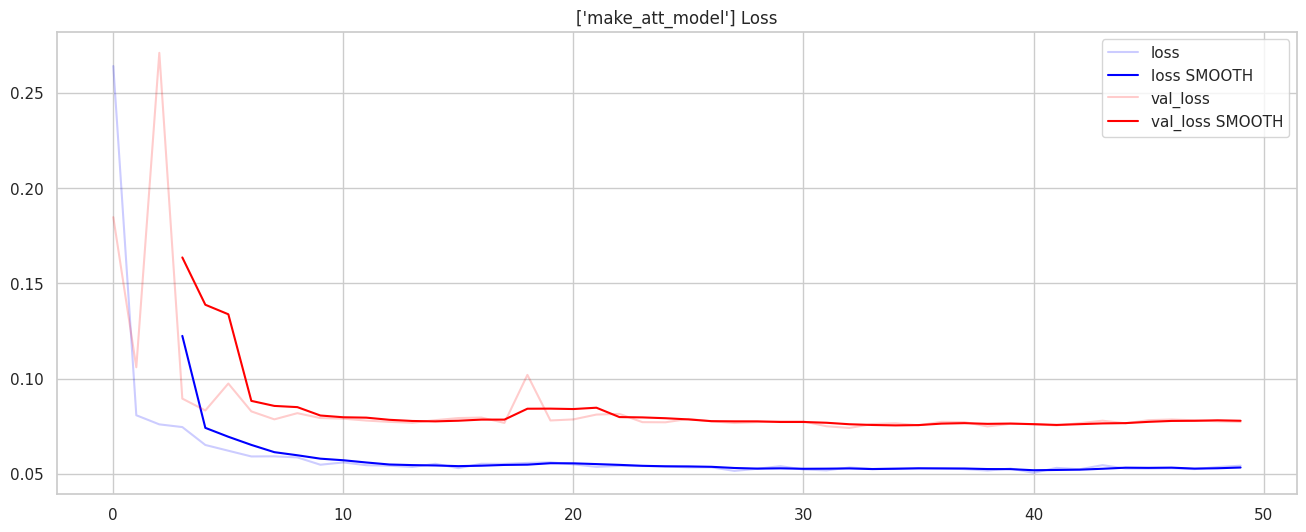

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


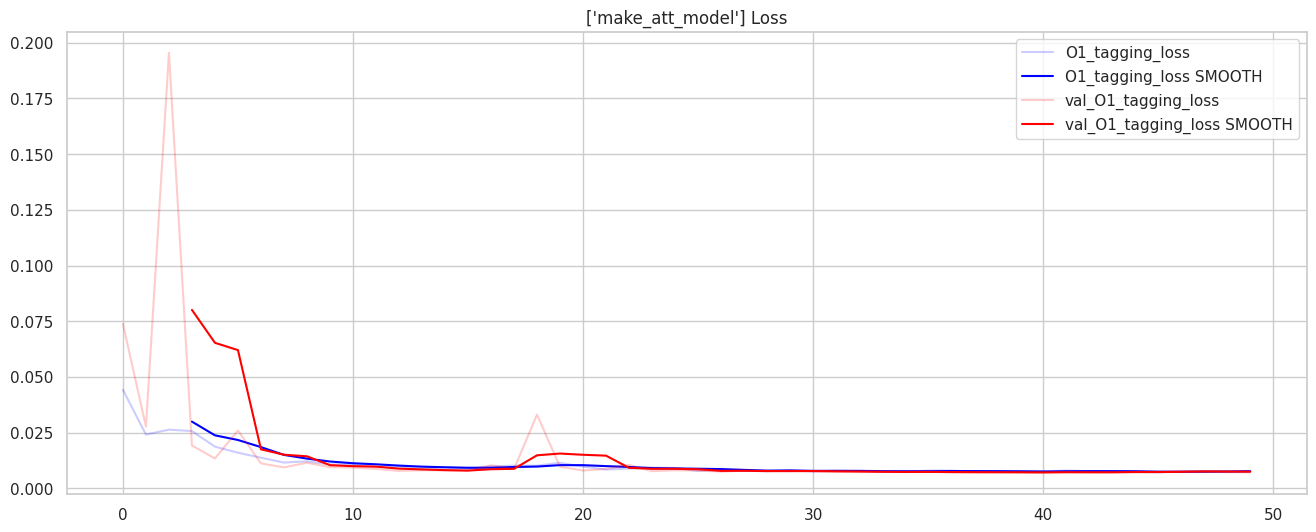

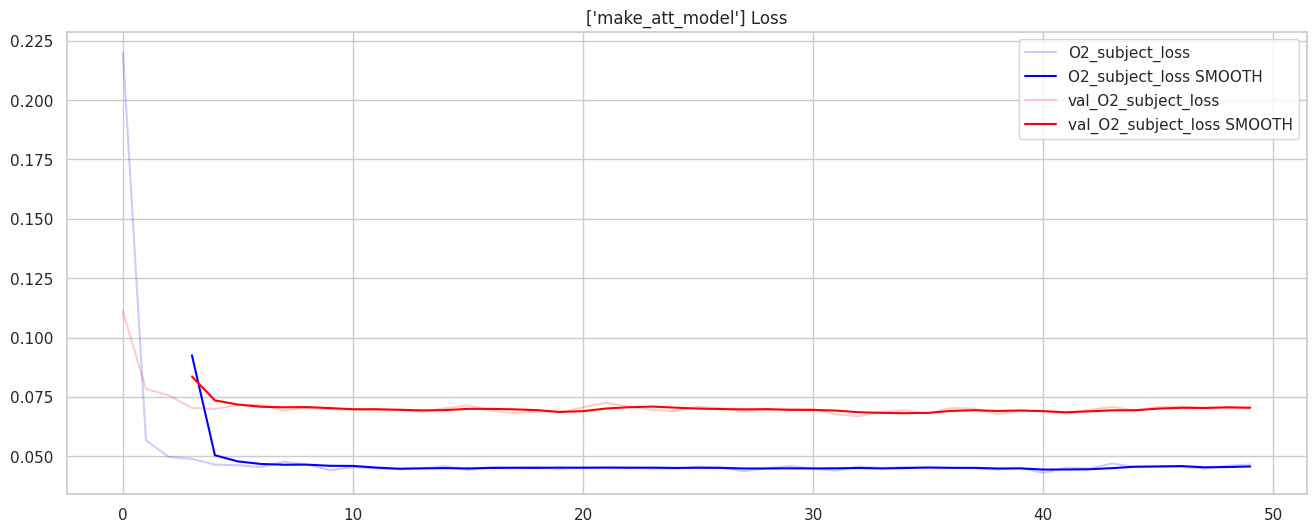

In [51]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [52]:
# umtm.stats
# semantic_map_keys_contract


5edbc62eda3678279fbcadf3


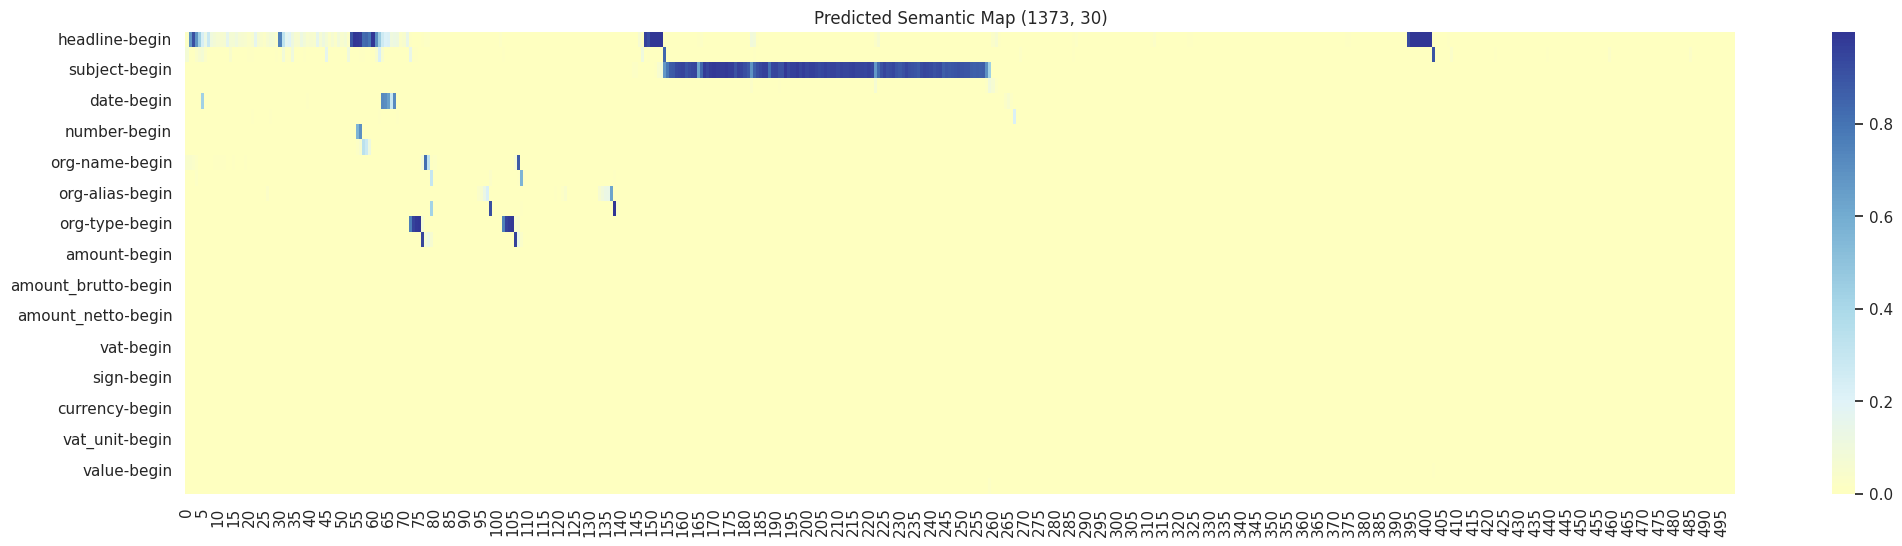

In [53]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [54]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [55]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'